In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

## GDrive setup
***- Only run if running on Google Colab***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set directory to location of OULAD dataset in google drive

In [ ]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [ ]:
ls

all_f1.pdf            learning_behaviour_f1.pdf
all_npv.pdf           learning_behaviour_npv.pdf
anonymisedOUDataSet/  pass_fail_rate_modules.pdf
Deadline/             performance_f1.pdf
demographic_f1.pdf    performance_npv.pdf
demographic_npv.pdf   StudentAssessmentDaysDeadline.csv


### Load dataset and split by module

In [ ]:
if 'google.colab' in sys.modules:
  path = 'Deadline'
else:
  path = '../../dataset/Deadline'

# Module BBB

## Setup

### Load dataset and remove column features that are not used in module

In [ ]:
deadline_list = [0, 50, 100, 150, 200, 250]
df = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_BBB_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # pass course = 0 | fail course = 1
  temp['final_result'] = temp['final_result'].replace({1:1, 2:0, 3:0})
  df[i] = temp

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
df[0].head()

code_presentation  id_student gender               region  \
0             2013B       23629      F  East Anglian Region   
1             2013B       25107      F  East Anglian Region   
2             2013B       29144      M         South Region   
3             2013B       31663      M         North Region   
4             2013B       34229      F              Ireland   

       highest_education imd_band age_band  num_of_prev_attempts  \
0     Lower Than A Level   20-30%     0-35                     2   
1     Lower Than A Level   20-30%     0-35                     0   
2     Lower Than A Level   60-70%     0-35                     0   
3  A Level or Equivalent   30-40%    35-55                     0   
4  A Level or Equivalent    0-10%    35-55                     2   

   studied_credits disability  ...  glossary  homepage  oucontent  \
0               60          N  ...       0.0       2.0        0.0   
1              120          N  ...       0.0       1.0        0.0   
2              120          N  ...       0.0       5.0        1.0   
3               60          N  ...       1.0      10.3        1.0   
4              120          N  ...       0.0       4.0        0.0   

   ouelluminate  quiz  resource  sharedsubpage  subpage    url  mean_click  
0           0.0   0.0  0.000000              0     0.00  0.000    0.444444  
1           0.0   0.0  0.000000              0     0.00  0.000    0.111111  
2           0.0   0.0  1.000000              0     1.00  2.000    0.555556  
3           1.0   0.0  2.058824              0     2.75  3.125    1.349410  
4           0.0   0.0  1.000000              0     2.00  1.500    0.564815  

[5 rows x 22 columns]

In [ ]:
df[0].final_result.value_counts()

0    2939
1    1055
Name: final_result, dtype: int64

In [ ]:
df[0].code_presentation.value_counts()

2014J    1151
2013J    1144
2013B     910
2014B     789
Name: code_presentation, dtype: int64

## Helper functions

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### Plotting

In [ ]:
def plot_confusion_matrix(result):

  if len(result)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots((len(result)+count)//2,2, figsize=(25, 28))


  for value, ax in zip(result, axes.flatten()):

      sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Confusion Matrix\n');
      ax.set_xlabel('Predicted Values')
      ax.set_ylabel('Actual Values ');

      ax.set_xticklabels(['Fail','Pass'])
      ax.set_yticklabels(['Fail','Pass'])

      count+=1

  plt.tight_layout()

In [ ]:
def plot_days(deadline_list,result, title):
  result = np.array(result)
  plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
  plt_days = sns.lineplot(x=deadline_list,y=result[:,1],marker="o", label="F1 score")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Score")
  plt_days.set_title(title)

In [ ]:
def plot_days_compare(deadline_list,result,labels,title):
  for i in range(len(result)):
    result[i] = np.array(result[i])
    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=result[i][:,1],marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")
    
  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("F1 Score")
  plt_days.set_title(title)

In [ ]:
def plot_days_compare_npv(deadline_list,result,labels,title):
 
  for i in range(len(result)):   
    npv = []

    for j in result[i][:,4]:
      tn, fp, fn, tp = j.ravel()

      # Prevent zero division error
      if fn == 0:
        npv.append(0)
      else:
        npv.append(tn/(tn+fn))

    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")
    
  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Negative Predictive Value")
  plt_days.set_title(title)

In [ ]:
def plot_correlation_matrix(result, Y_test= None):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  temp = {}
  for i in result.keys():
    temp[i] = result[i].copy()
    if Y_test:
      temp[i]['final_result'] = Y_train[i] 

  count= 0
  for value, ax in zip(temp, axes.flatten()):

      corr = temp[value].corr()

      sns.heatmap(corr, annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Correlation Matrix\n');

      count+=1

  plt.tight_layout()

In [ ]:
def plot_feature_importance(feature_results):

  if len(feature_results)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots(len(feature_results)//2,2, figsize=(25, 33))

  for value, ax in zip(feature_results, axes.flatten()):
   
    importance = permutation_importance(value[0], value[1], value[2])

    feature_names = tuned_model.feature_names_in_

    ax.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation='vertical')
    ax.set_title(f'\nDay {count*50}: Feature Importance\n');

    count+=1
  


### Split dataframe

In [ ]:
def split_dataset(df_day, train_code_presentation, test_code_presentation):   
  test_df = df_day.loc[df_day['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation','id_student'], axis = 1)

  Y_test = test_df['final_result']
  X_test = test_df.drop('final_result', axis=1)

  train_df = df_day.loc[df_day['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation','id_student'], axis = 1)

  Y_train = train_df['final_result']
  X_train = train_df.drop('final_result', axis=1)

  
  return X_train, X_test, Y_train, Y_test


In [ ]:

def split_dataset_single_presentation(df_day, code_presentation):

  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation','id_student'], axis = 1)
  
  Y = df_cp['final_result']
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(X,Y, random_state=RANDOM_SEED)


### Evaluate models

In [ ]:
def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [ ]:
def evaluate_search(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    acc, f1, prec, recall, conf = evaluation_summary(predictions, test_labels)
    print('Accuracy = {:0.2f}%, F1 Score = {:0.2f}%.'.format(acc, f1))
    
    return acc

### Split dataframe by demographic data | performance data | learning behaviour data

In [ ]:
df[0].columns

Index(['code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'forumng', 'glossary',
       'homepage', 'oucontent', 'ouelluminate', 'quiz', 'resource',
       'sharedsubpage', 'subpage', 'url', 'mean_click'],
      dtype='object')

In [ ]:
def split_dataframe_by_data_type(input_df, column_types, include_final_result=True):
  demographic_columns = ['gender', 'region', 'highest_education', 'imd_band','age_band', 'disability']
  prev_uni_experience_columns = ['num_of_prev_attempts','studied_credits']
  all_performance_columns = ['score','weighted_score']
  performance_columns = set(input_df.columns).intersection(set(all_performance_columns))
  all_learning_behaviour_columns = ['mean_click','resource','subpage','oucontent','url','forumng','quiz','page','oucollaborate','questionnaire','ouwiki','dataplus','externalquiz','homepage','ouelluminate','glossary','dualpane','repeatactivity','htmlactivity','sharedsubpage','folder']
  learning_behaviour_columns = set(input_df.columns).intersection(set(all_learning_behaviour_columns))

  final_result_column = ['final_result']

  type_dict = {"demographic":demographic_columns, "prev_uni_experience":prev_uni_experience_columns, "performance":performance_columns,"learning_behaviour":learning_behaviour_columns, "final_result":final_result_column}

  columns_used = ['code_presentation', 'id_student']
  for i in column_types:
    columns_used.extend(type_dict[i])
  
  if include_final_result:
    columns_used.extend(final_result_column)

  output_df = input_df[columns_used]

  return output_df

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

### Encode data

In [ ]:
def encode_data(df, train, test=None):
  X_train, X_test, Y_train, Y_test = {},{},{},{}

  for i in df.keys():
    if test != None:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], train, test)
    else:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], train)
    
    
    cols_to_drop = X_train[i].nunique()
    cols_to_drop = list(cols_to_drop.loc[cols_to_drop.values==1].index)


    X_train[i] = X_train[i].drop(cols_to_drop, axis=1)
    X_test[i] = X_test[i].drop(cols_to_drop, axis=1)

  for i in df.keys():
    categorical_features = X_train[i].select_dtypes(include="object").columns
    numerical_features = X_train[i].select_dtypes(exclude="object").columns
    print(categorical_features, numerical_features)
    preprocessing_transformer = make_column_transformer(
      (OneHotEncoder(), categorical_features),
      (MinMaxScaler(), numerical_features))  

    try:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)
    except:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
          columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
          index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)

  return X_train, X_test, Y_train, Y_test

## Feature correlation
 

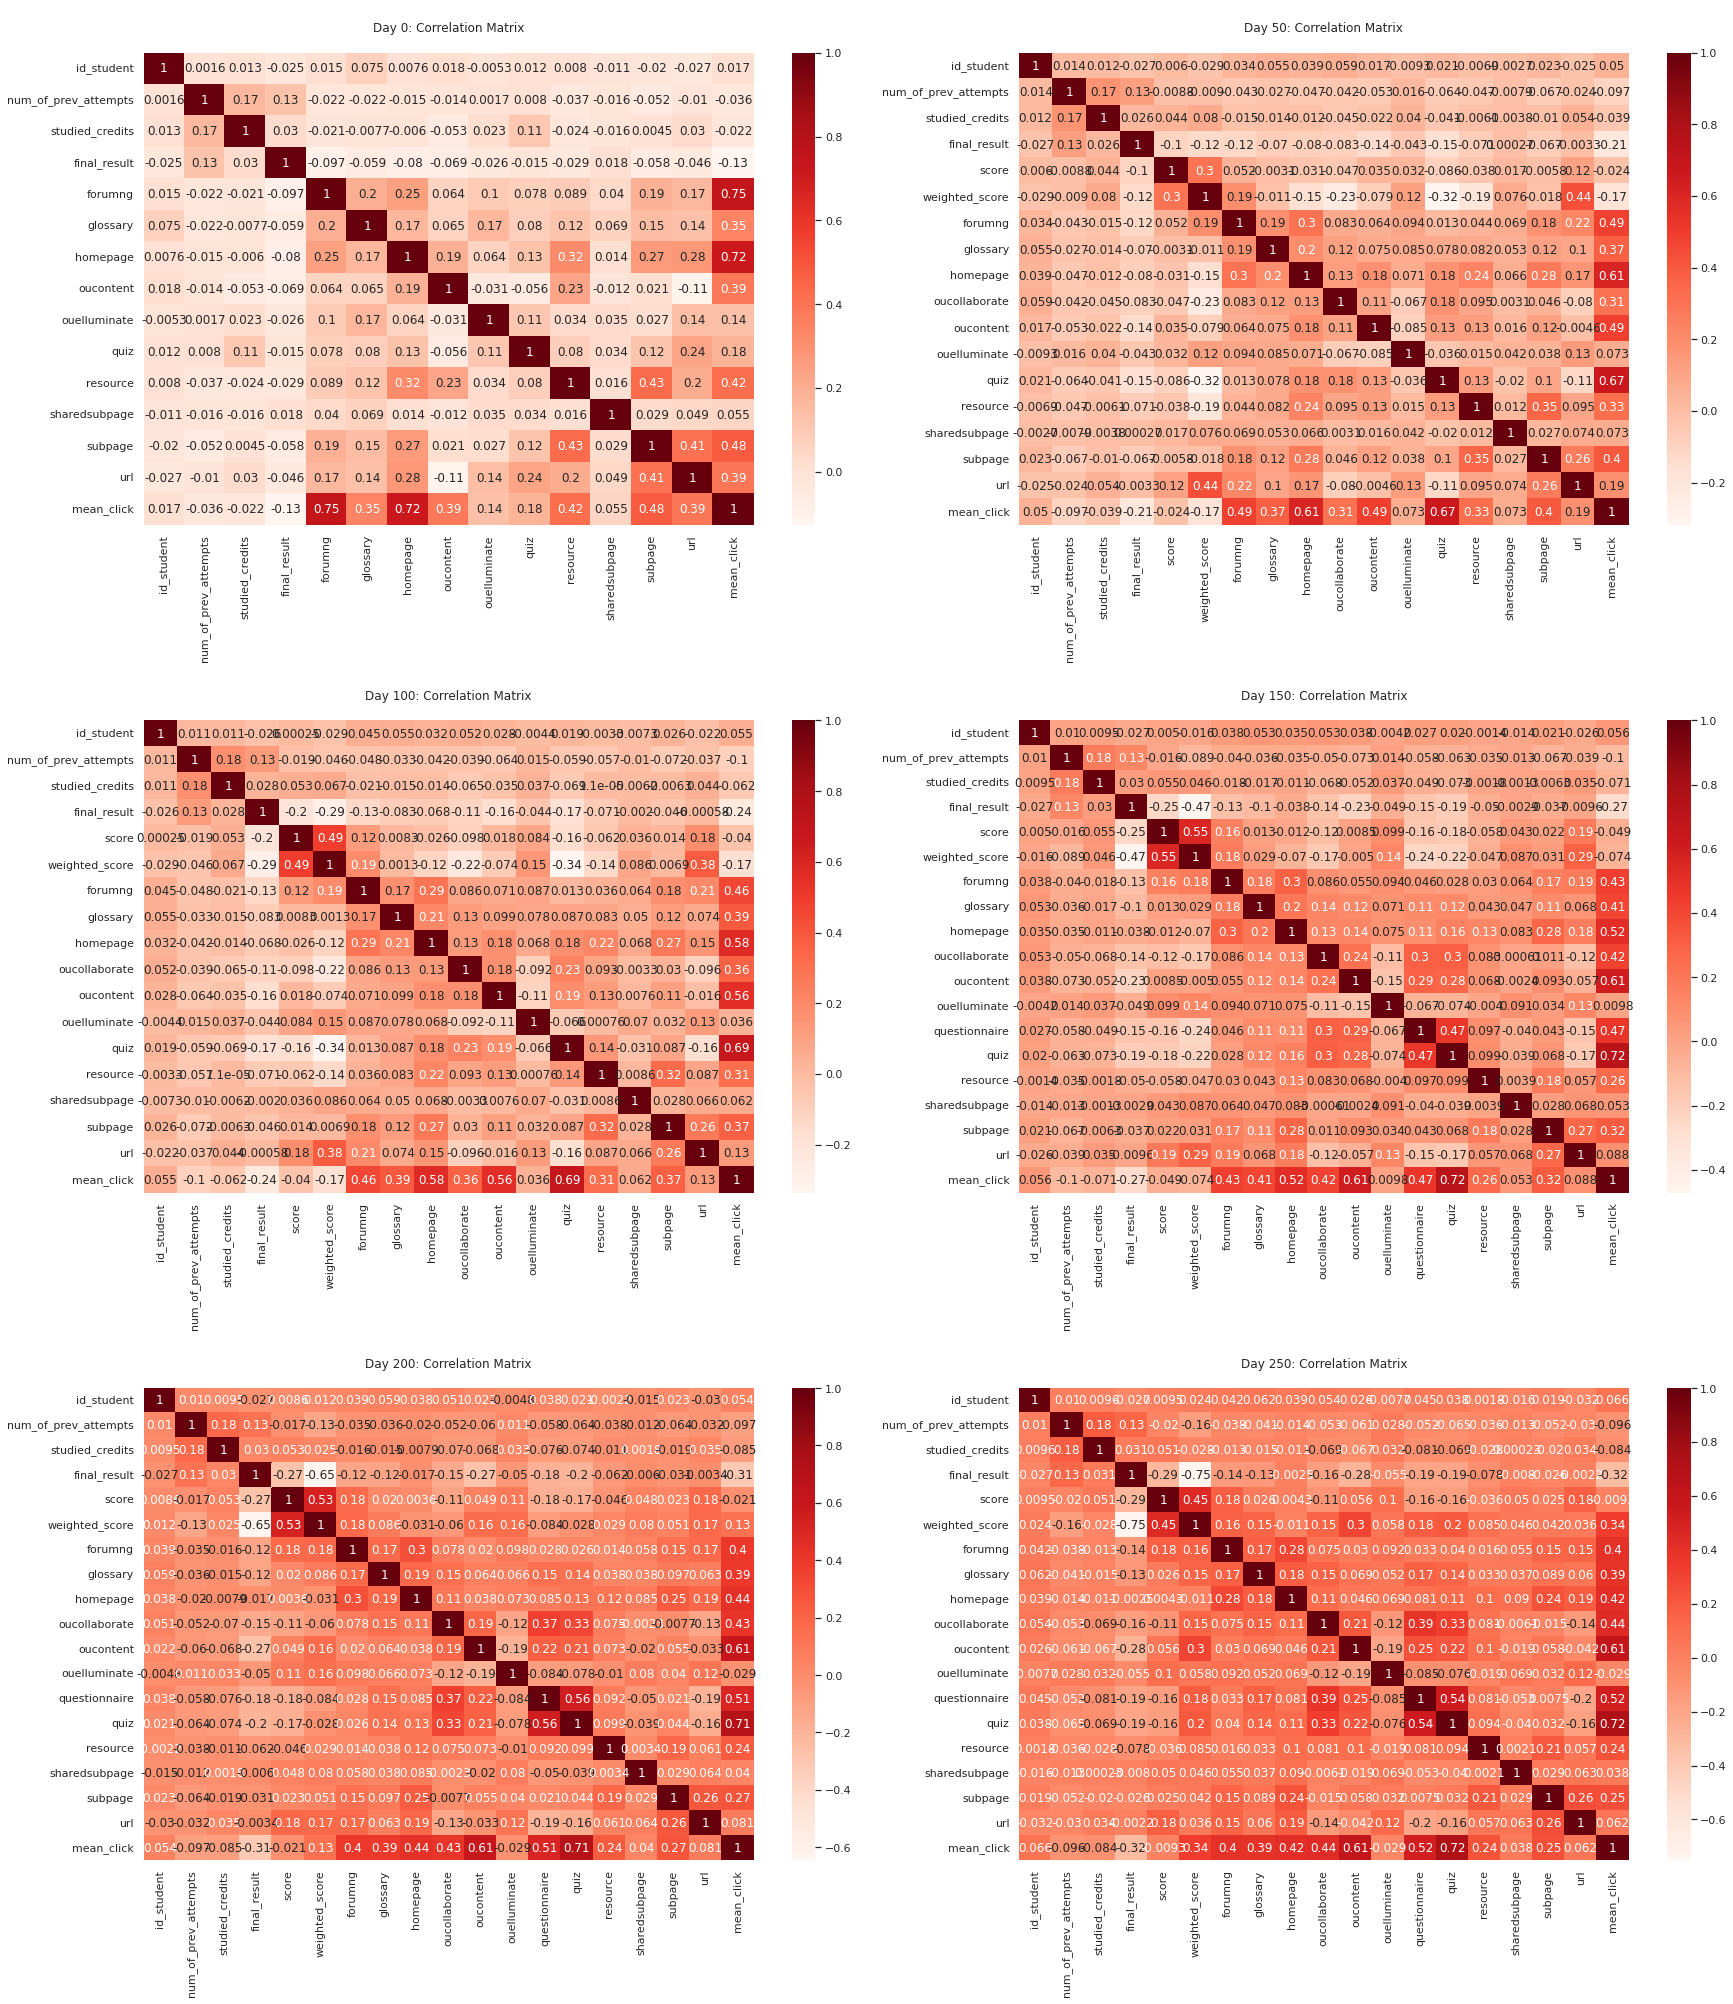

In [ ]:
plot_correlation_matrix(df)

## Make predictions

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFdr, SelectFpr
from sklearn.decomposition import PCA

### 2013J | 2014J predictions

#### Demographic data

##### Prepare data for prediction

In [ ]:
demographic_df = {}
for i in df.keys():
  demographic_df[i] = split_dataframe_by_data_type(df[i], ['demographic'], include_final_result=True)

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(demographic_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')


In [ ]:
X_train[0].shape

(1144, 35)

###### Undersampling

In [ ]:
Y_train[0].value_counts()

0    841
1    303
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({0: 841, 1: 303})
Resample dataset shape Counter({0: 303, 1: 303})
Sampling for day 50
Original dataset shape: Counter({0: 1053, 1: 414})
Resample dataset shape Counter({0: 414, 1: 414})
Sampling for day 100
Original dataset shape: Counter({0: 1060, 1: 417})
Resample dataset shape Counter({0: 417, 1: 417})
Sampling for day 150
Original dataset shape: Counter({0: 1063, 1: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 200
Original dataset shape: Counter({0: 1063, 1: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 250
Original dataset shape: Counter({0: 1064, 1: 421})
Resample dataset shape Counter({0: 421, 1: 421})


###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [ ]:
X_train[250]

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1480  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1481  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1482  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1483  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1484  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   

       14   15   16   17   18   19  
0     0.0  0.0  0.0  1.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  1.0  1.0  
2     1.0  0.0  0.0  1.0  0.0  1.0  
3     0.0  0.0  0.0  0.0  1.0  0.0  
4     0.0  0.0  0.0  1.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  
1480  0.0  0.0  0.0  1.0  0.0  0.0  
1481  0.0  0.0  0.0  0.0  1.0  0.0  
1482  0.0  0.0  0.0  1.0  0.0  1.0  
1483  0.0  0.0  0.0  1.0  0.0  0.0  
1484  0.0  0.0  0.0  1.0  0.0  0.0  

[1485 rows x 20 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

demographic_results_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_du.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.476
Best parameters set:
Accuracy: 0.5178105994787141, F1 Score: 0.33212996389891697, Precision: 0.24, Recall: 0.5390625


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.434
Best parameters set:
Accuracy: 0.5082304526748971, F1 Score: 0.32037914691943126, Precision: 0.23150684931506849, Recall: 0.52


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.453
Best parameters set:
Accuracy: 0.508130081300813, F1 Score: 0.32276119402985076, Precision: 0.23410013531799728, Recall: 0.5195195195195195


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.469
Best parameters set:
Accuracy: 0.5064

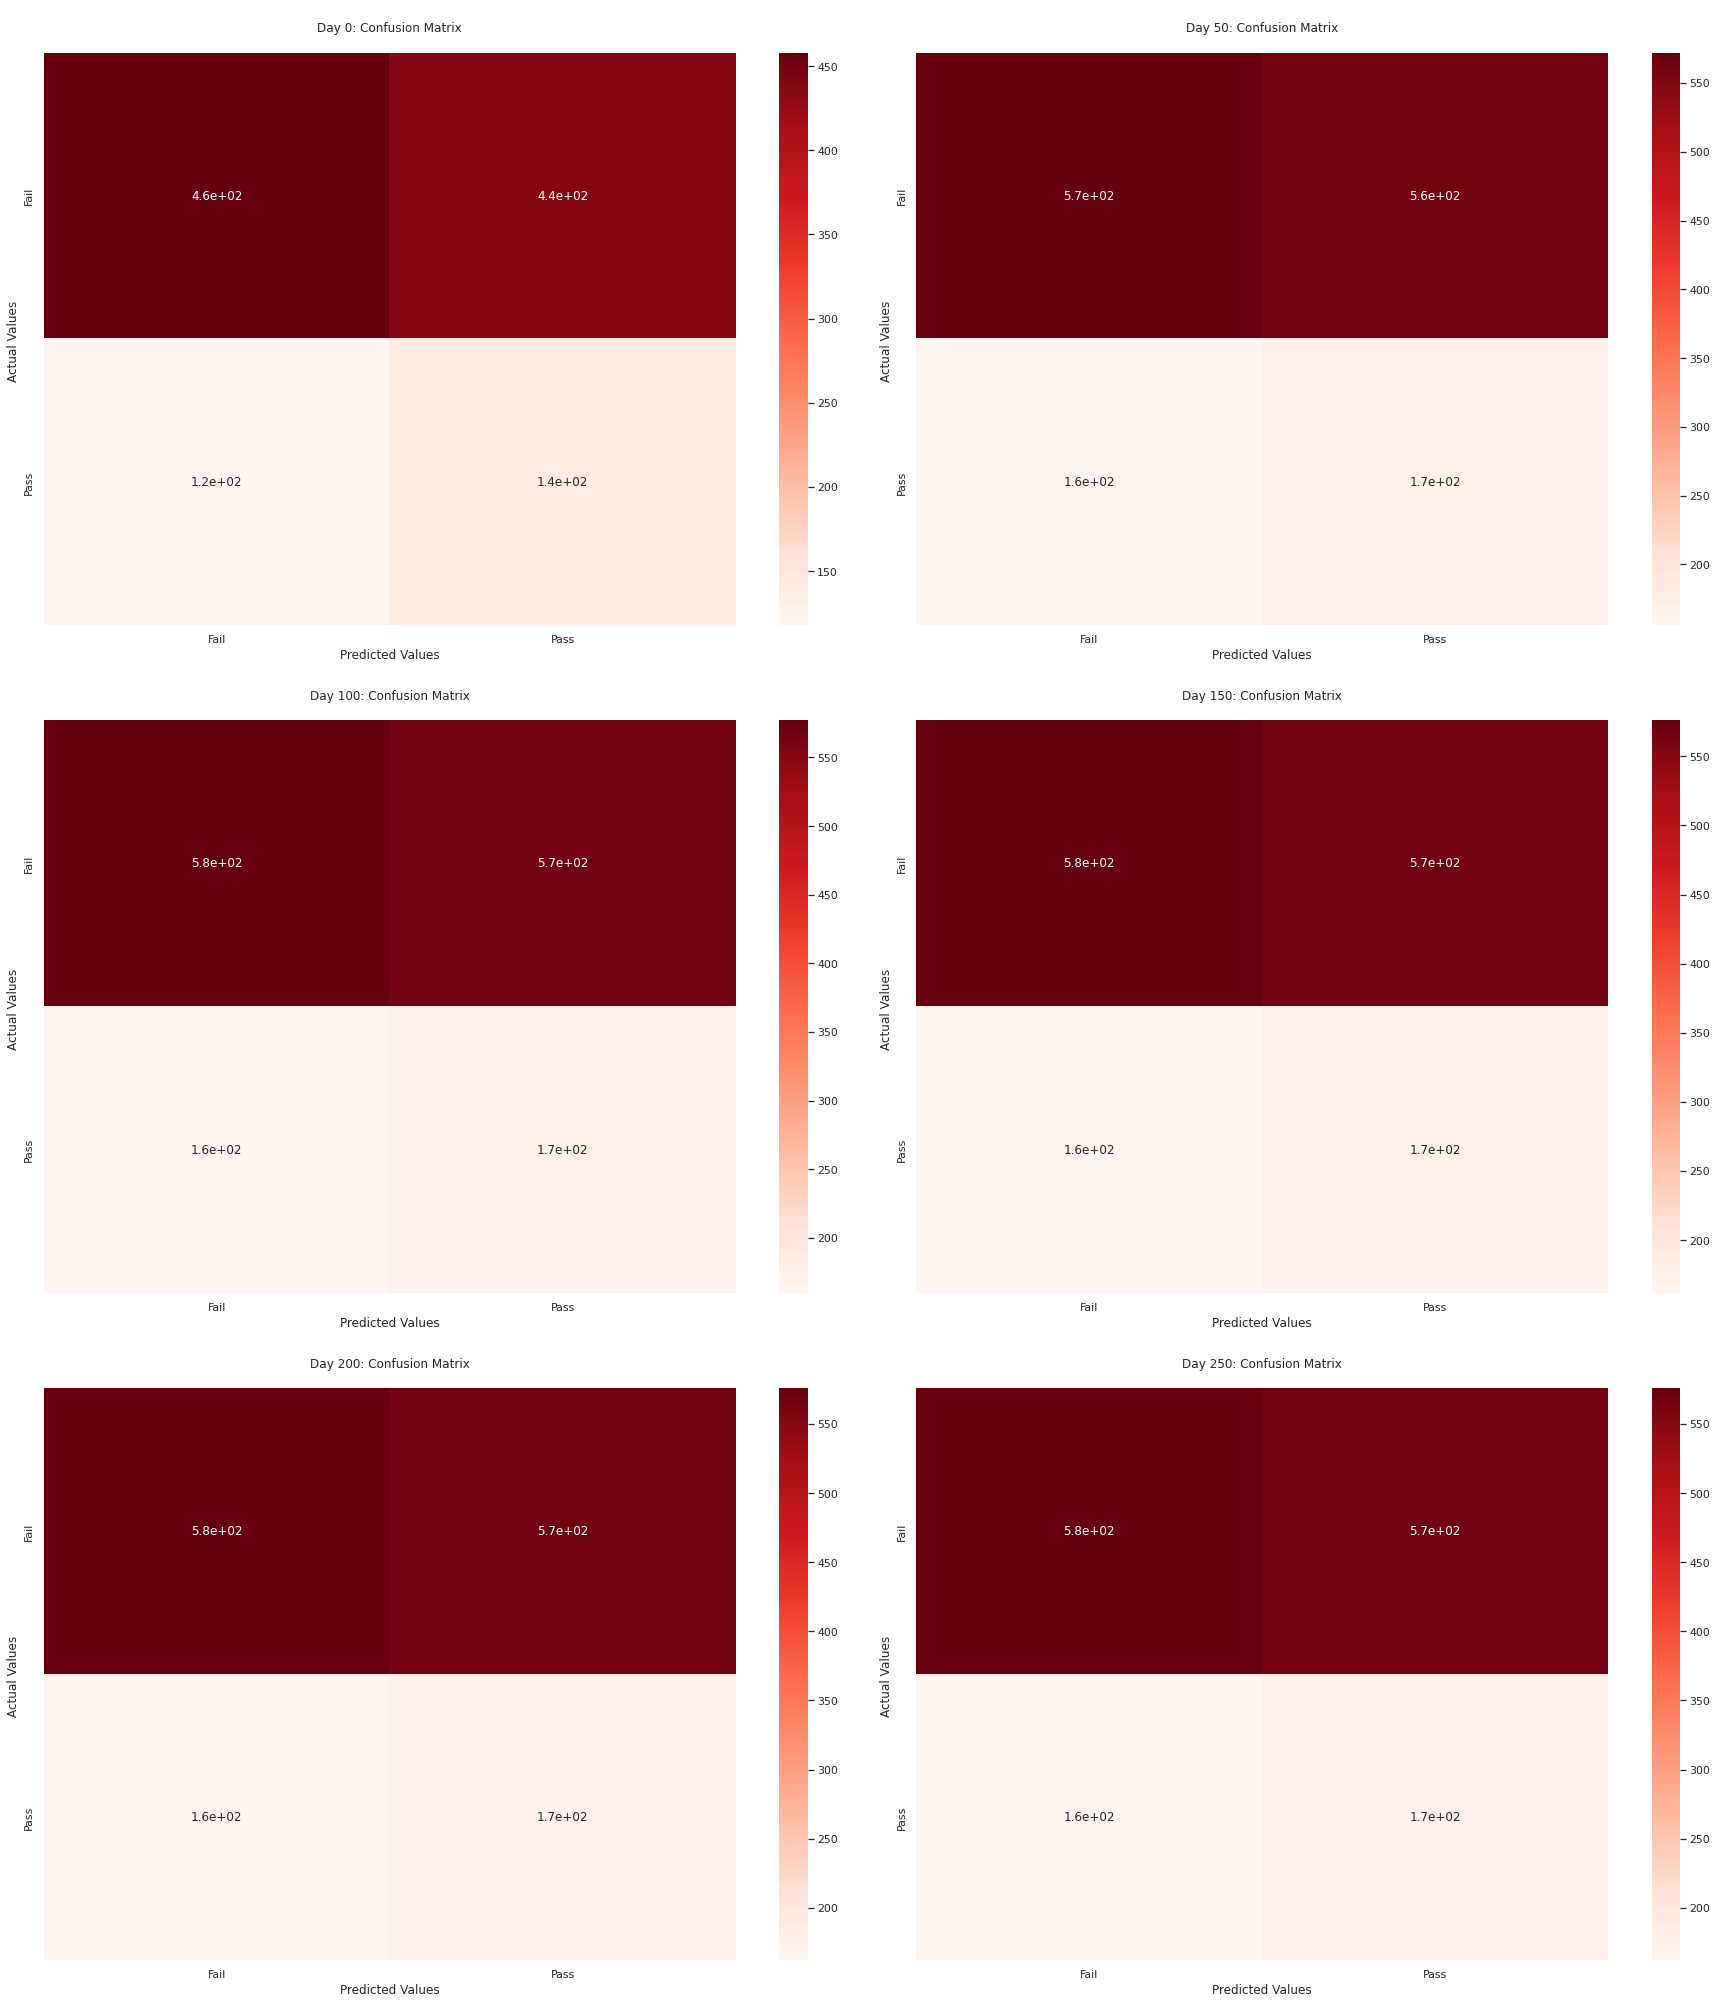

In [ ]:
plot_confusion_matrix(demographic_results_du)

##### NaiveBayes

BernoulliNB is used as it is specfically designed for binary/boolean features.

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB

demographic_results_nb = []

pipeline = Pipeline([
    ('clf', BernoulliNB(binarize=None)),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_nb.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.601
Best parameters set:
Accuracy: 0.73501303214596, F1 Score: 0.33839479392624733, Precision: 0.3804878048780488, Recall: 0.3046875


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.561
Best parameters set:
Accuracy: 0.7304526748971193, F1 Score: 0.32124352331606215, Precision: 0.3661417322834646, Recall: 0.28615384615384615


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.558
Best parameters set:
Accuracy: 0.7303523035230353, F1 Score: 0.3277027027027027, Precision: 0.3745173745173745, Recall: 0.2912912912912913


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.556
Best paramet

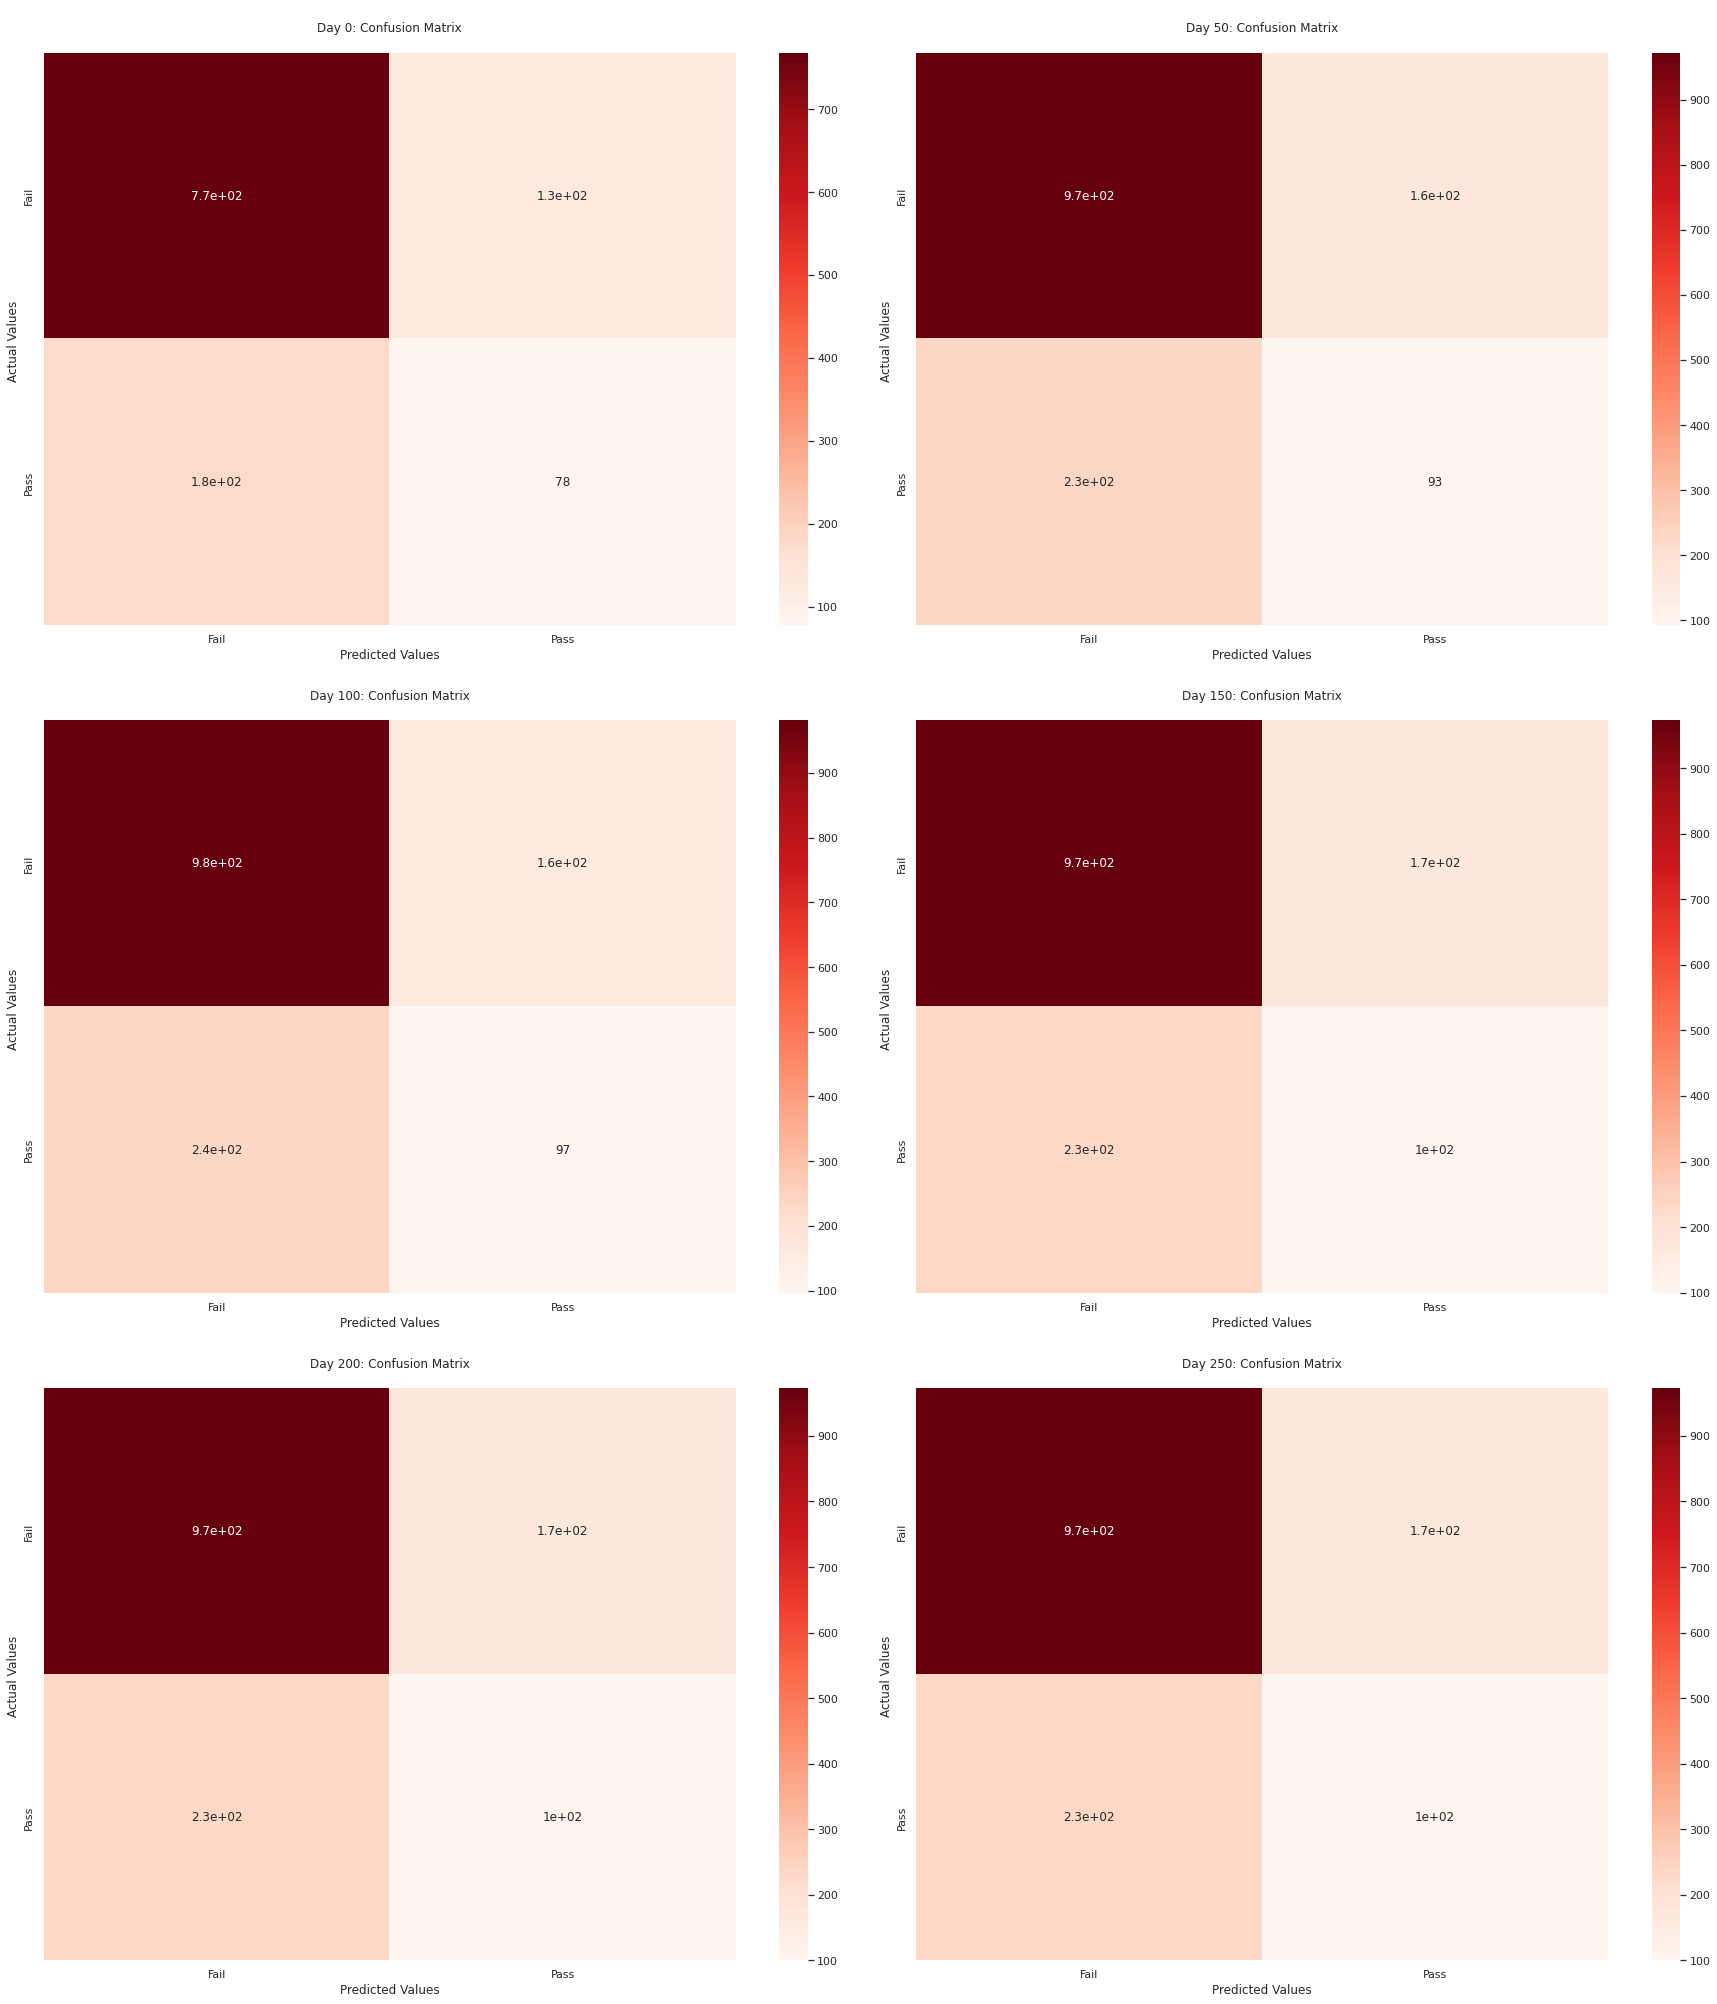

In [ ]:
plot_confusion_matrix(demographic_results_nb)

##### LogisticRegression

ovr is used for binary problems

In [ ]:
from sklearn.linear_model import LogisticRegression

demographic_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr')),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lr.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.567
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7584708948740226, F1 Score: 0.17261904761904762, Precision: 0.3625, Recall: 0.11328125


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.522
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7517146776406035, F1 Score: 0.16203703703703703, Precision: 0.32710280373831774, Recall: 0.1076923076923077


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.517
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7506775067750677, F1 Score: 0.167420814479638, Precision: 0.3394495412844037, Recall: 0.1111111111111111


Day 150
Pe

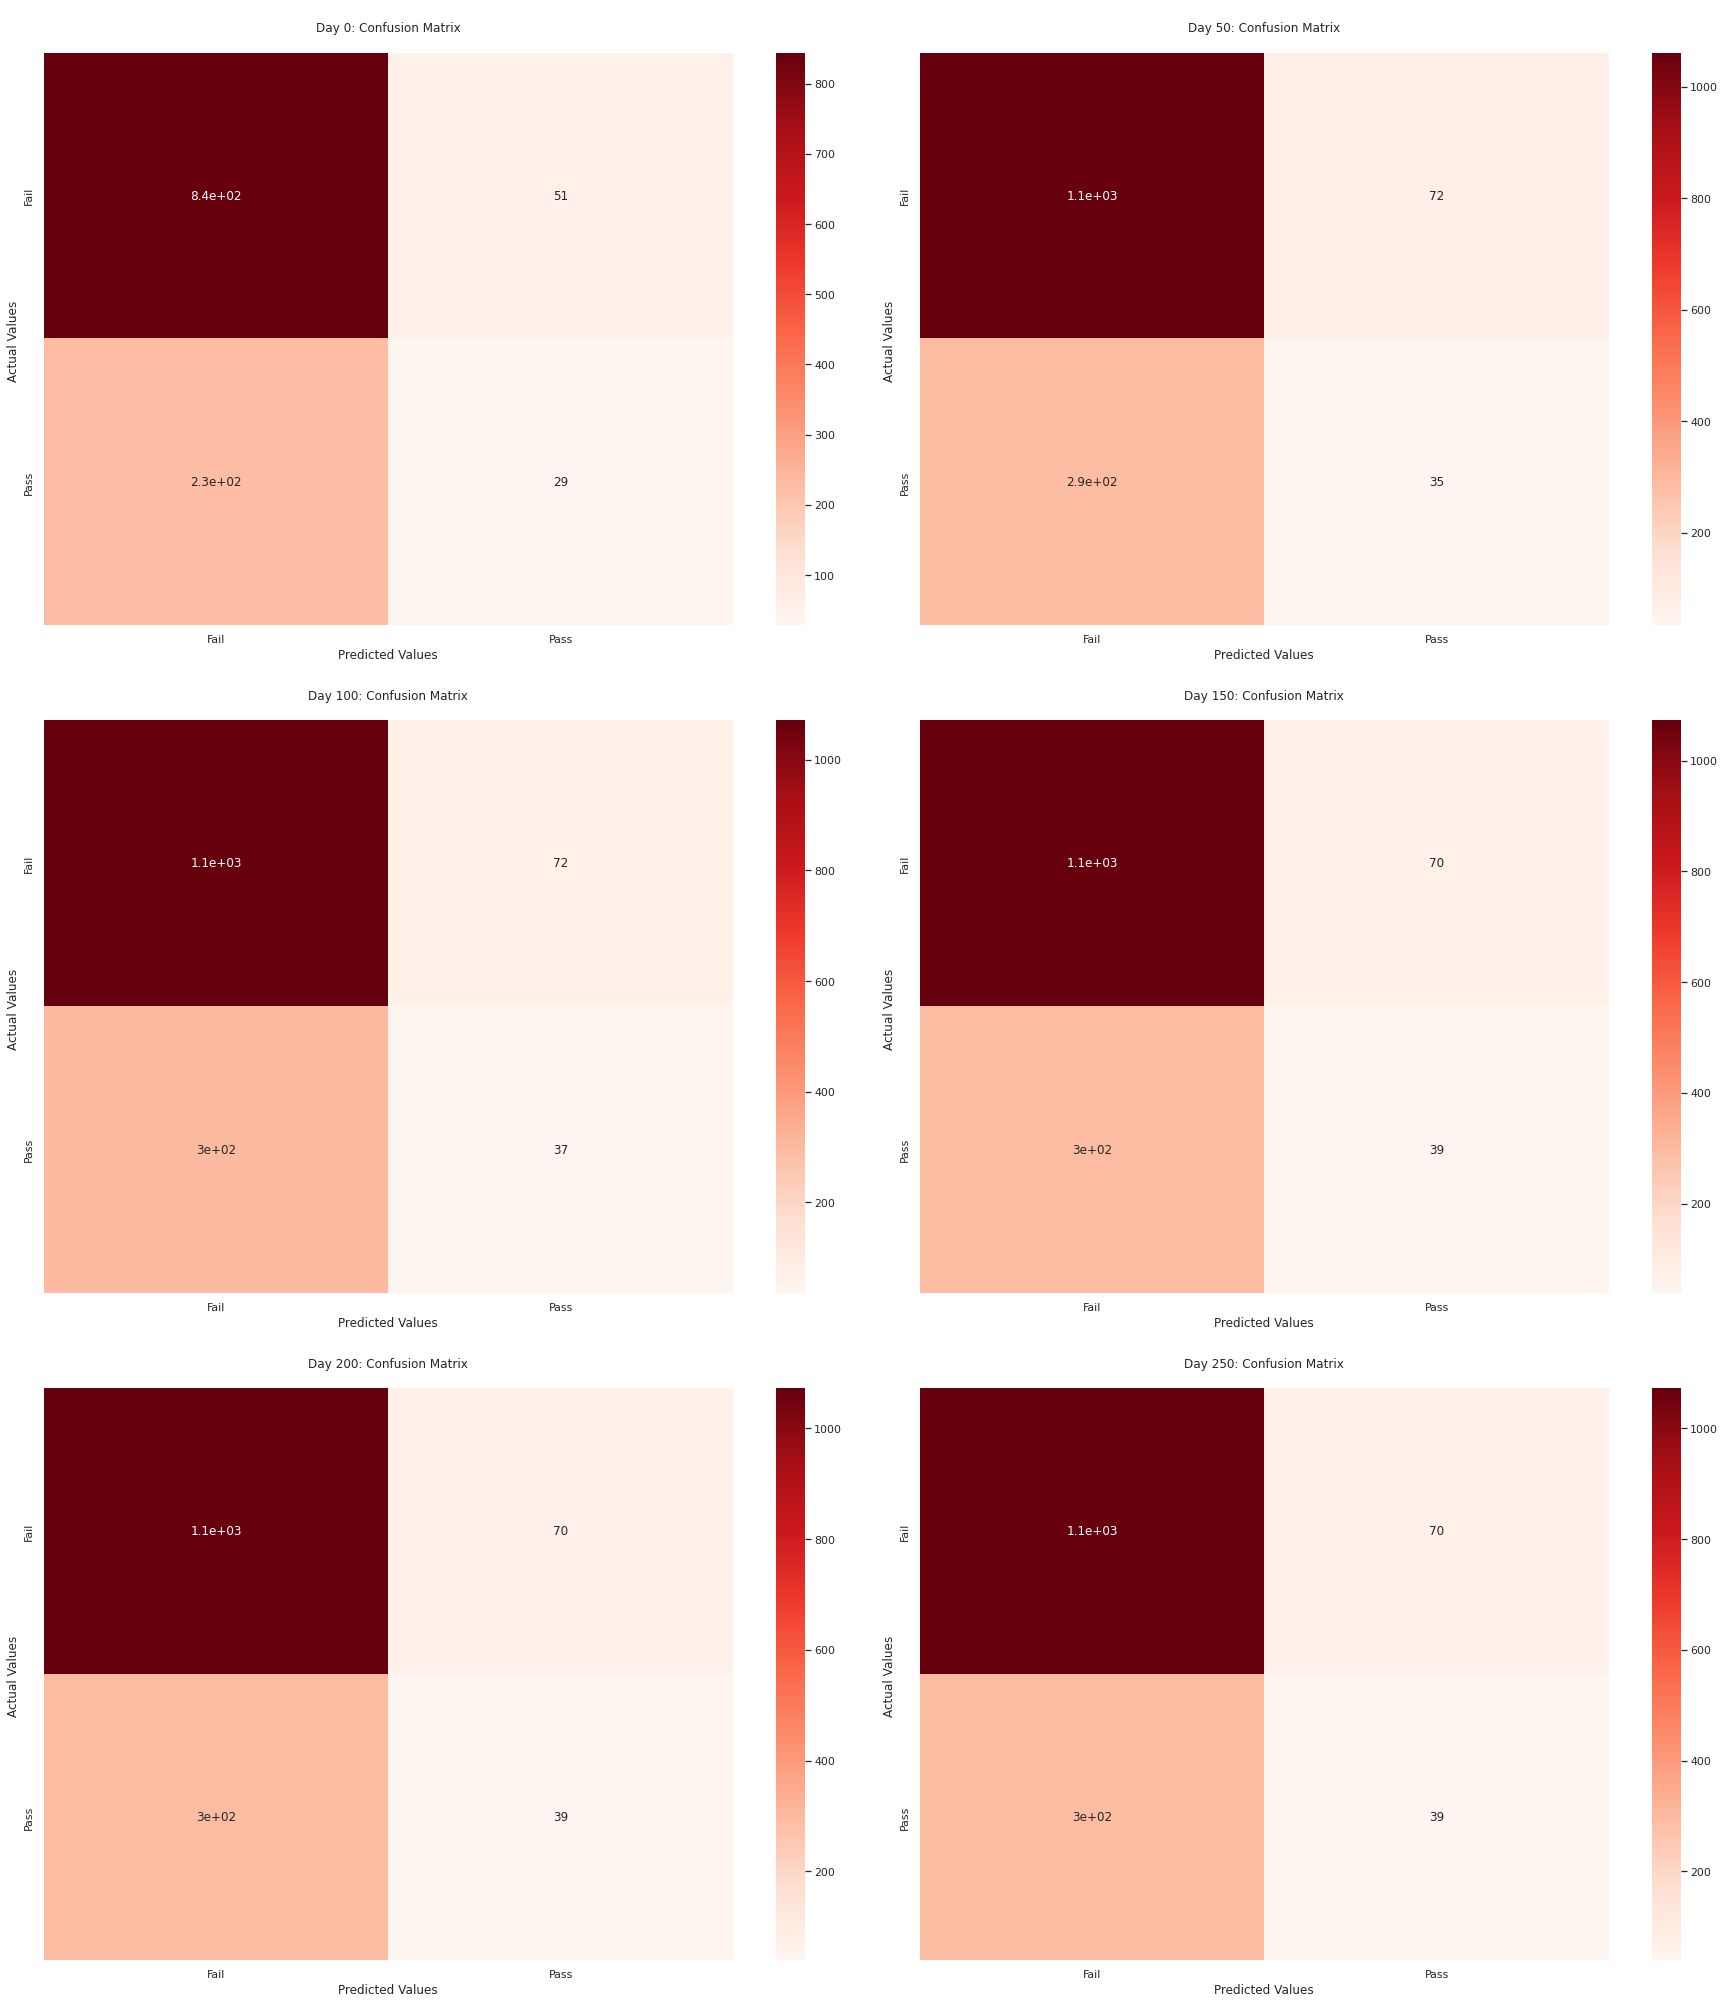

In [ ]:
plot_confusion_matrix(demographic_results_lr)

##### WeightedLogisticRegression

In [ ]:
demographic_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr', class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.578
Best parameters set:
Accuracy: 0.6133796698523023, F1 Score: 0.39946018893387314, Precision: 0.30515463917525776, Recall: 0.578125


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.569
Best parameters set:
Accuracy: 0.5946502057613169, F1 Score: 0.3772391991570074, Precision: 0.28685897435897434, Recall: 0.5507692307692308


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.574
Best parameters set:
Accuracy: 0.5968834688346883, F1 Score: 0.38722966014418125, Precision: 0.2946708463949843, Recall: 0.5645645645645646


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.564
Best param

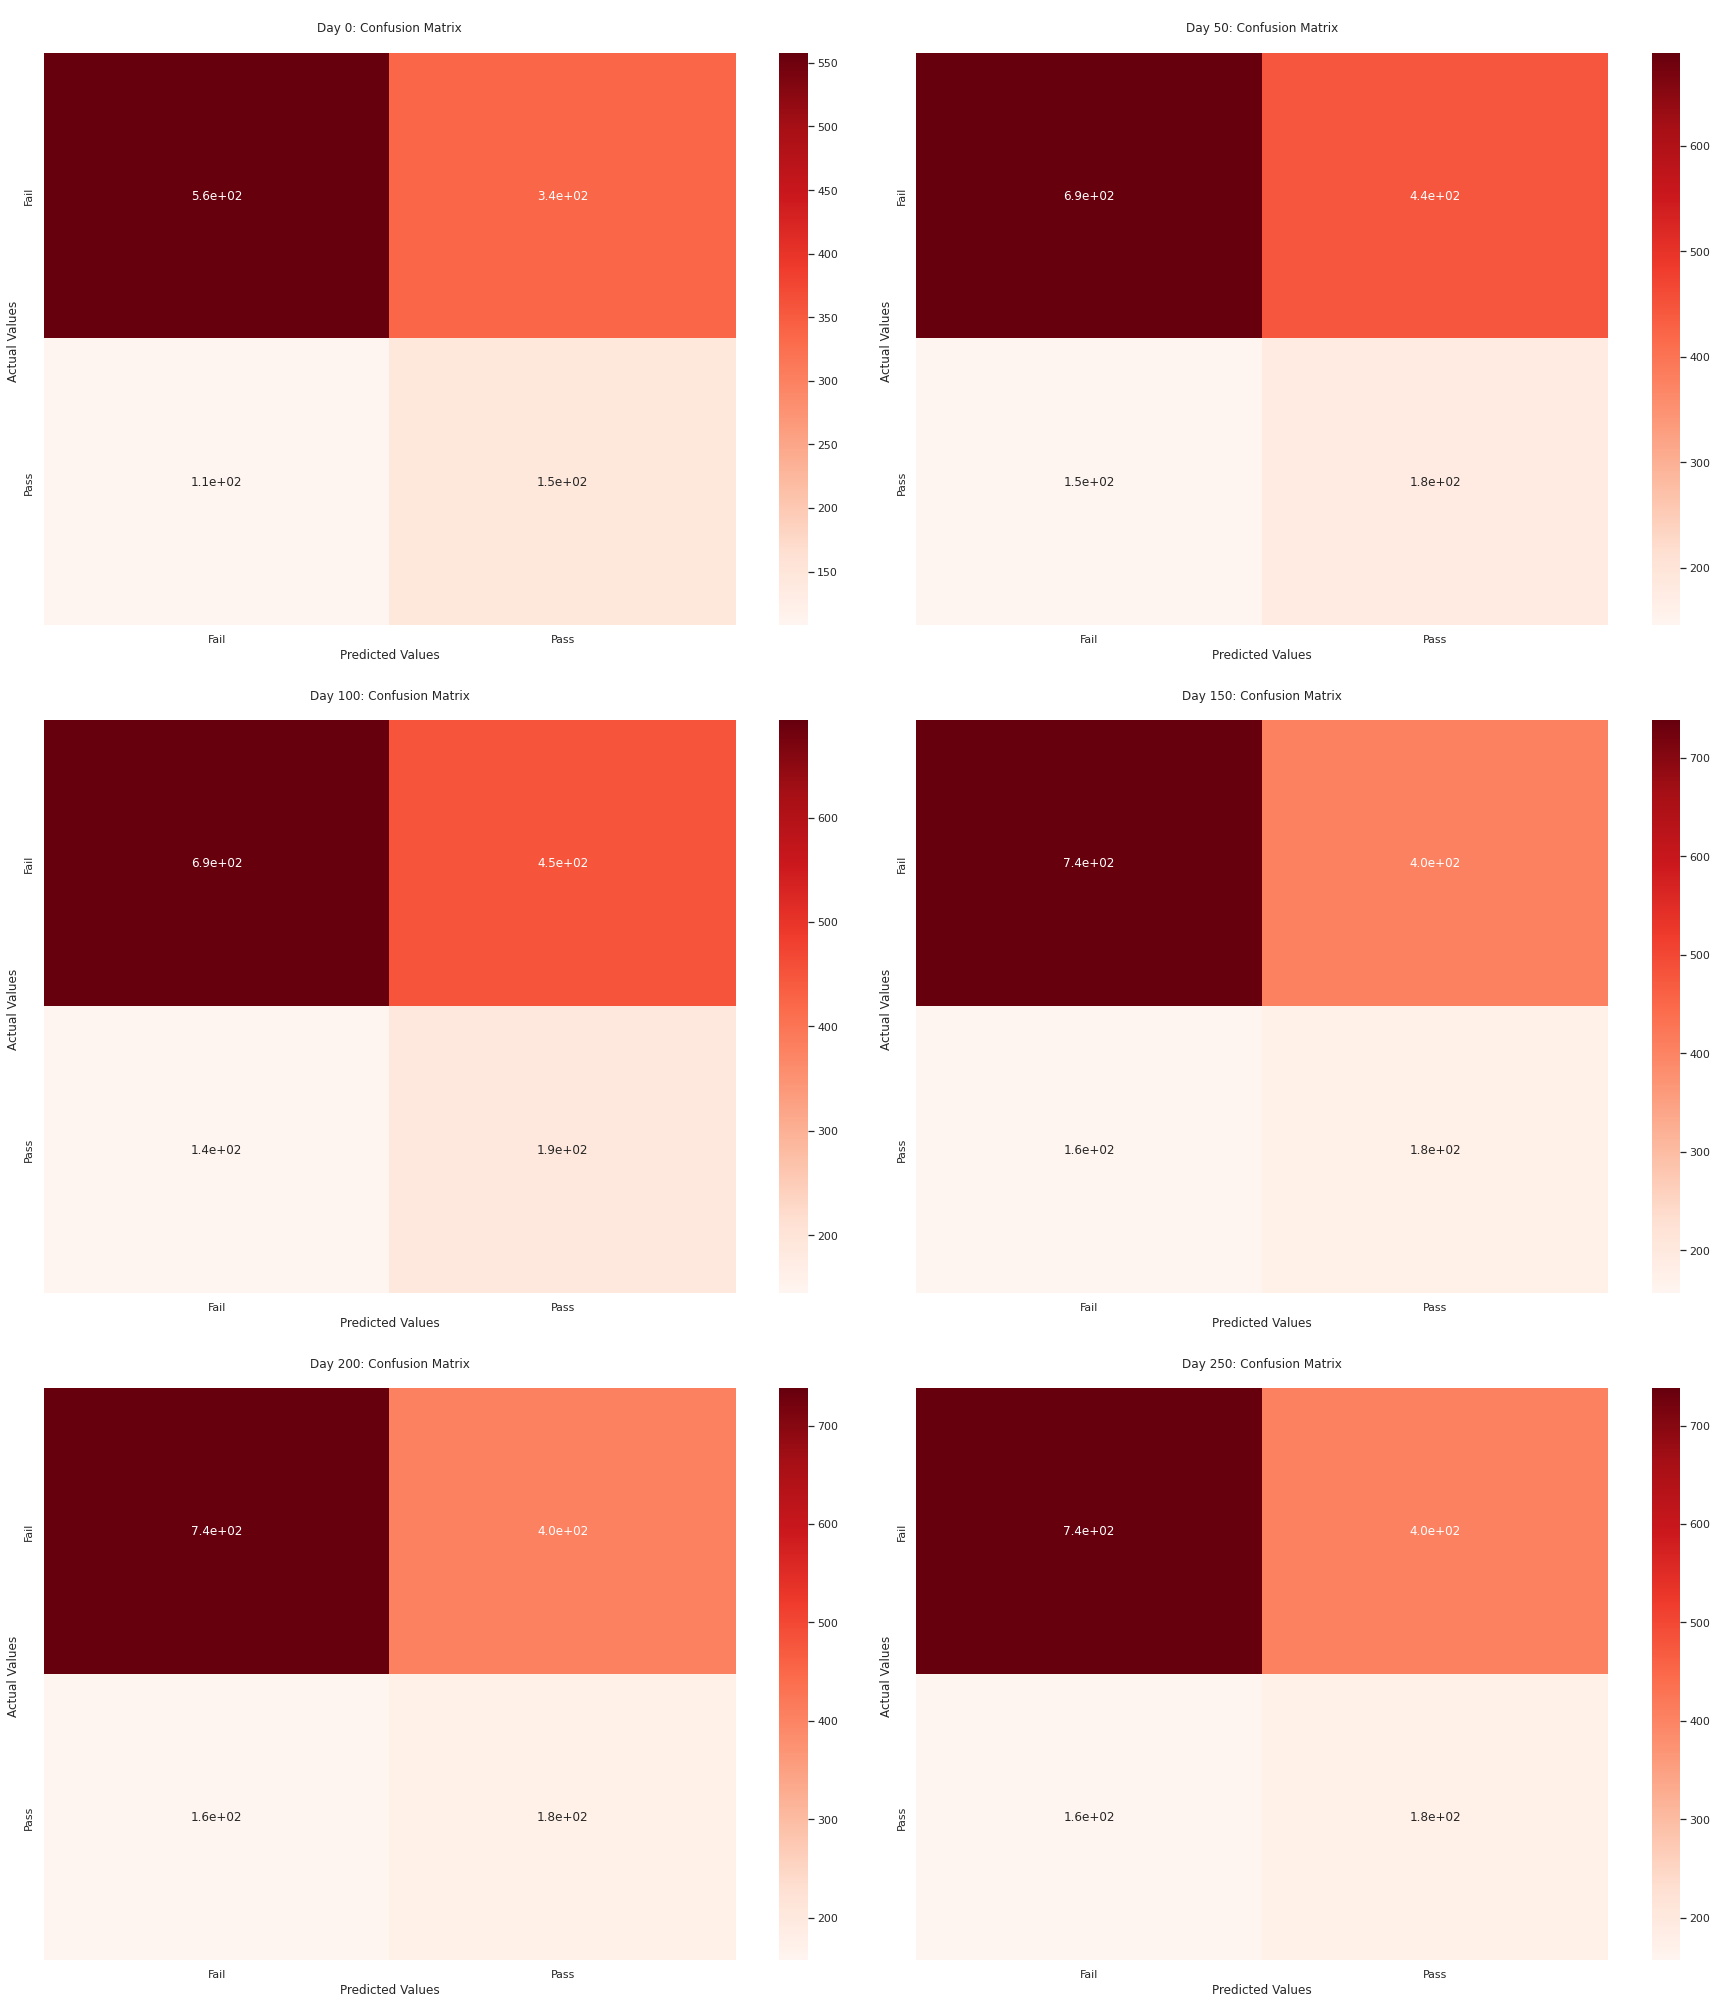

In [ ]:
plot_confusion_matrix(demographic_results_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

demographic_results_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_rf.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.591
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.6490008688097306, F1 Score: 0.3667711598746082, Precision: 0.306282722513089, Recall: 0.45703125


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.560
Best parameters set:
	clf__n_estimators: 80
Accuracy: 0.6255144032921811, F1 Score: 0.3651162790697674, Precision: 0.29345794392523367, Recall: 0.48307692307692307


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.554
Best parameters set:
	clf__n_estimators: 70
Ac

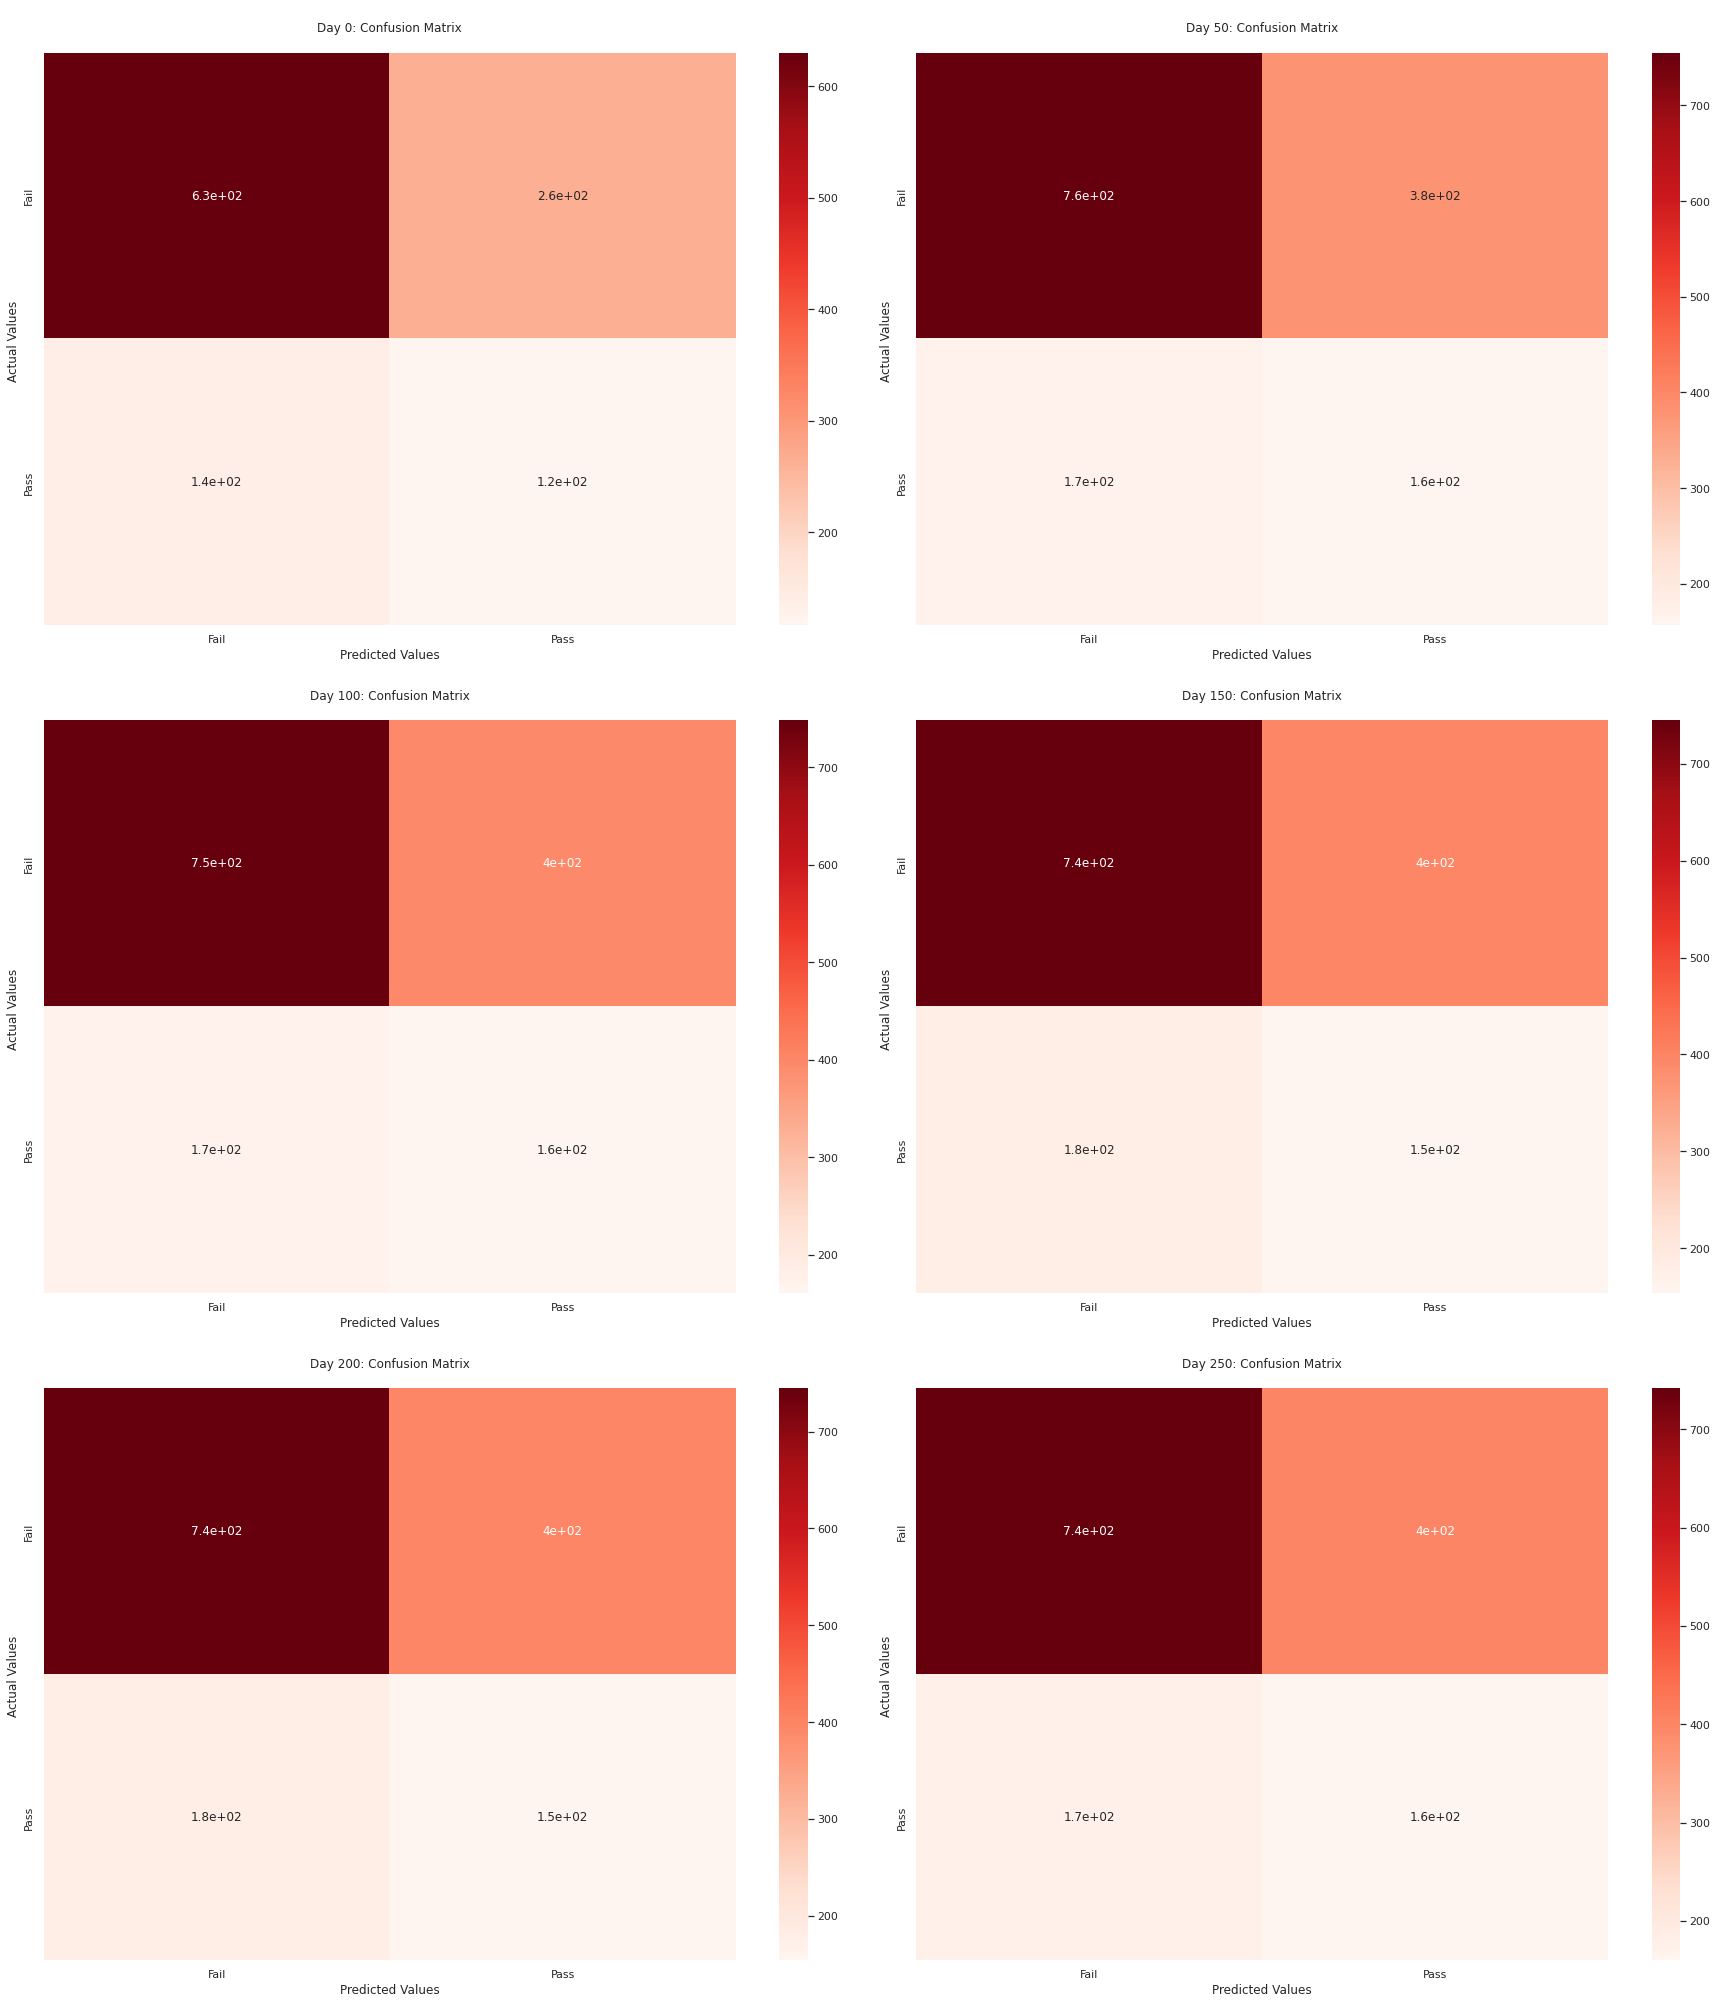

In [ ]:
plot_confusion_matrix(demographic_results_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

demographic_results_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_ab.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.572
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.7471763683753258, F1 Score: 0.18487394957983191, Precision: 0.32673267326732675, Recall: 0.12890625


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.525
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.7599451303155007, F1 Score: 0.12060301507537691, Precision: 0.3287671232876712, Recall: 0.07384615384615385


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.522
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.7513550135501355, F1 

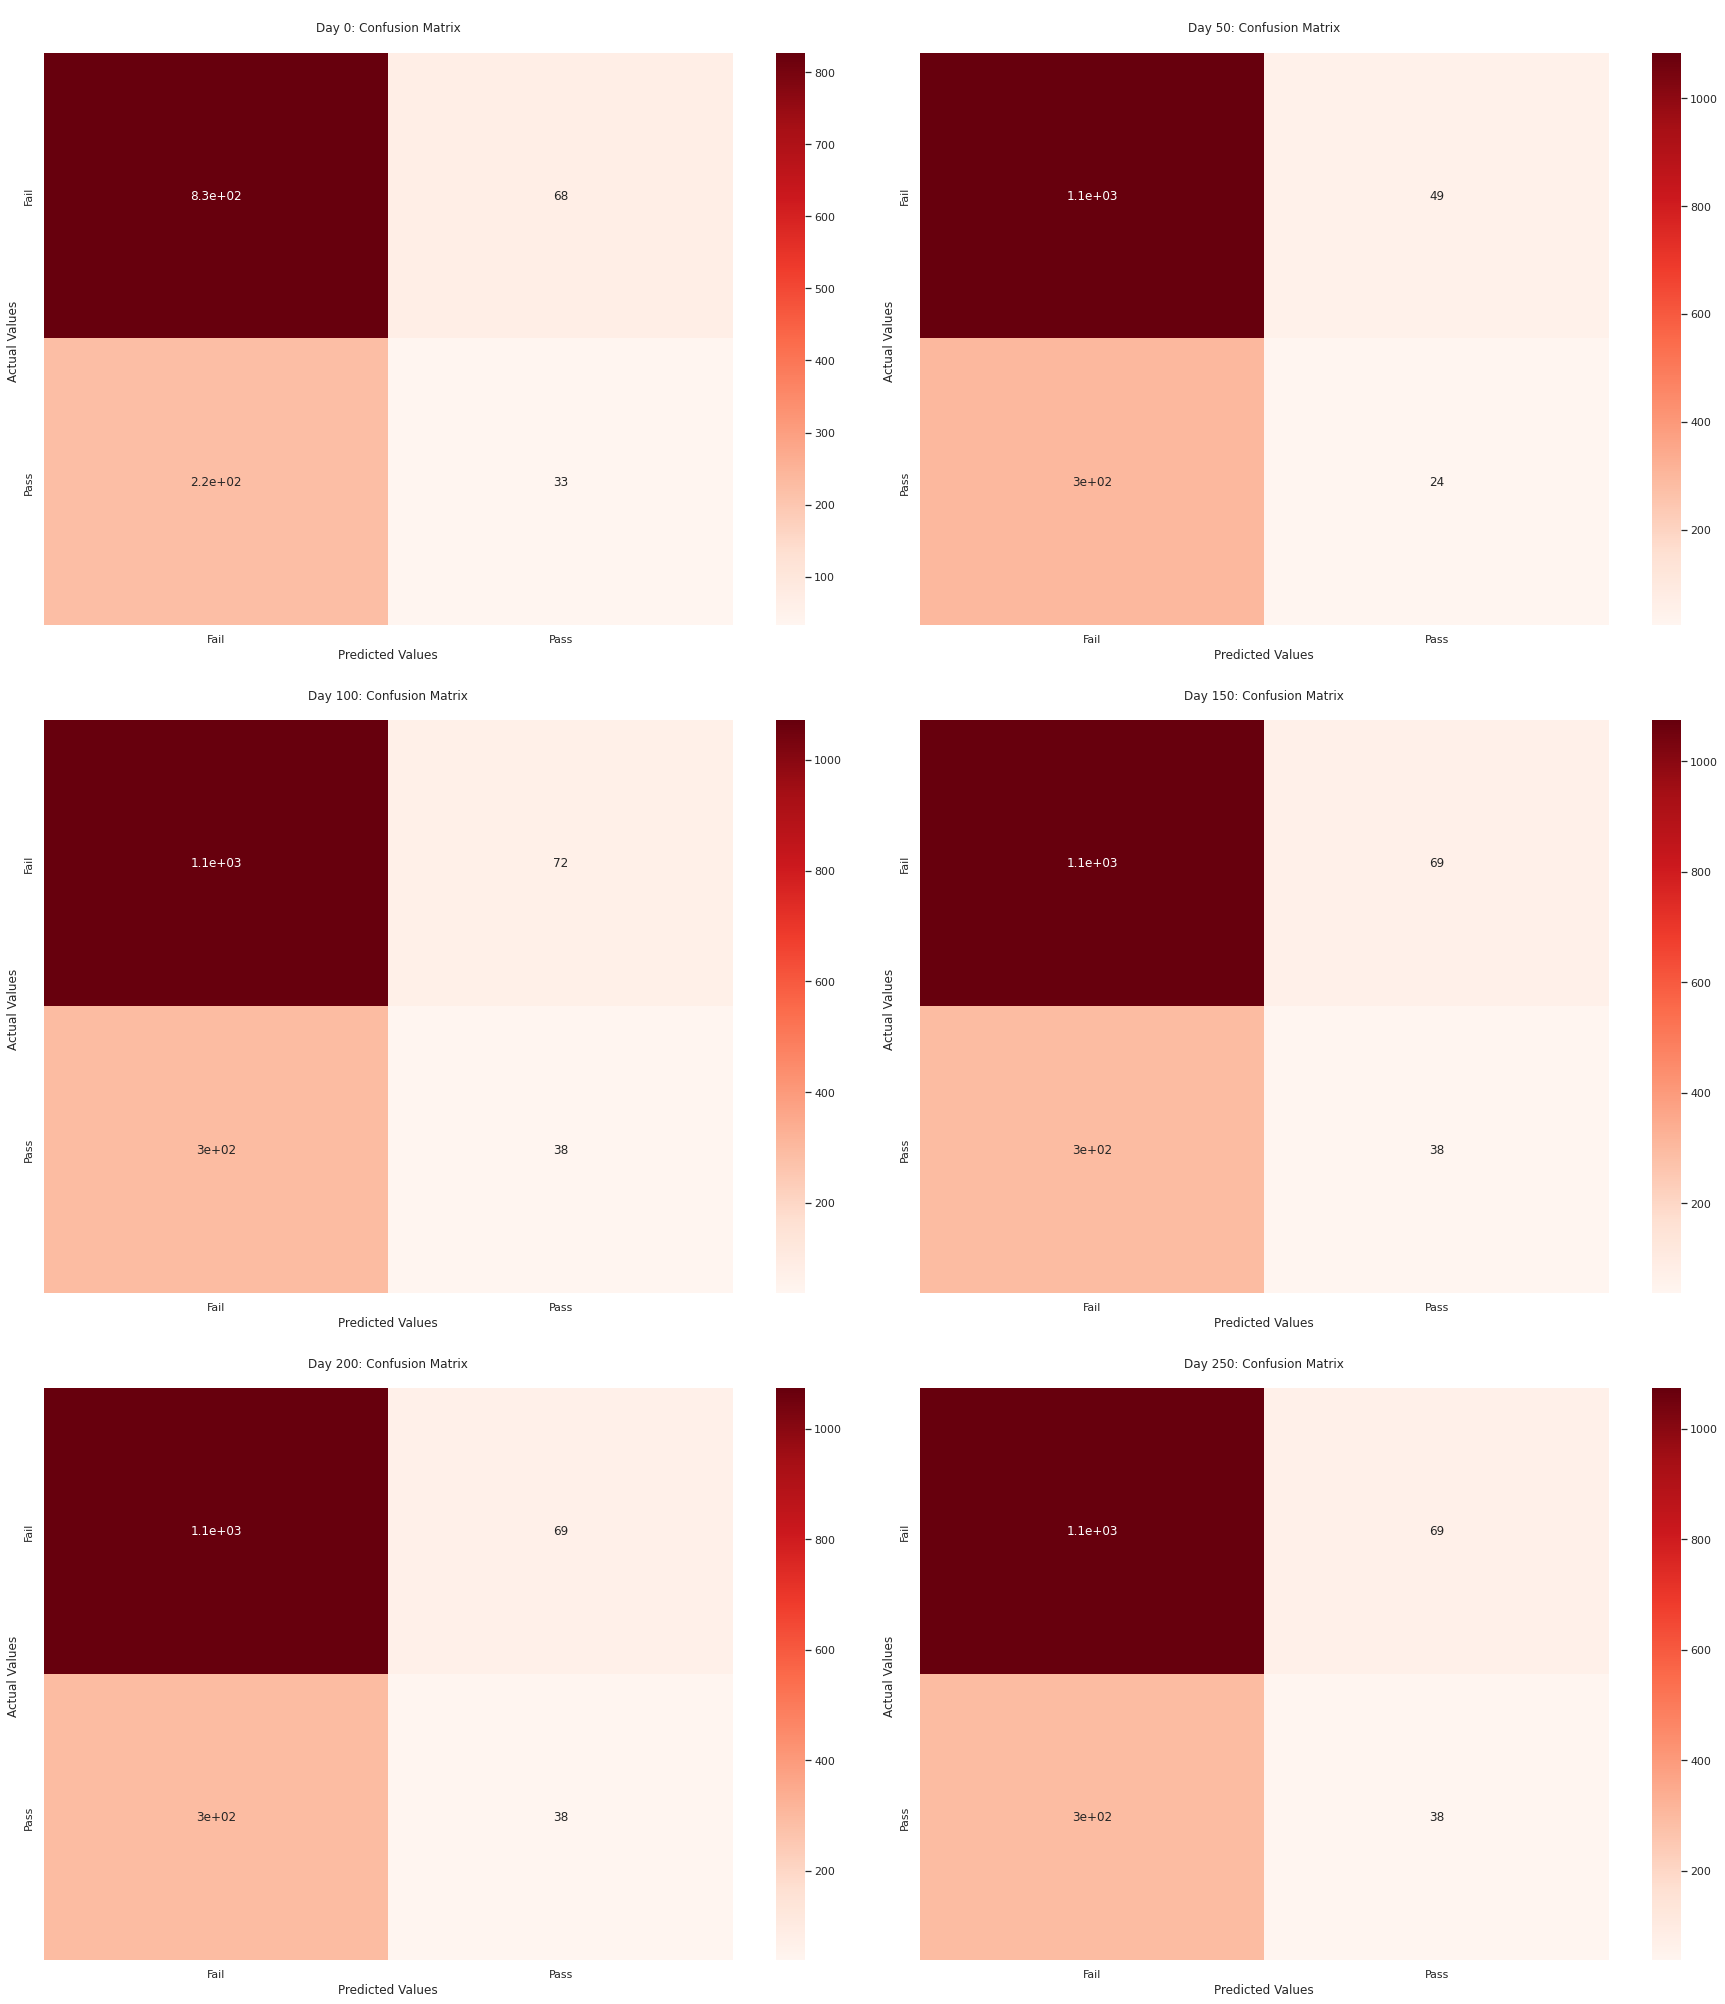

In [ ]:
plot_confusion_matrix(demographic_results_ab)

##### Plot results overview

In [ ]:
demographic_classifier_results = [demographic_results_du, demographic_results_nb, demographic_results_lr, demographic_results_lrw, demographic_results_rf, demographic_results_ab]
demographic_classifier_labels = ["Dummy Classifier","Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

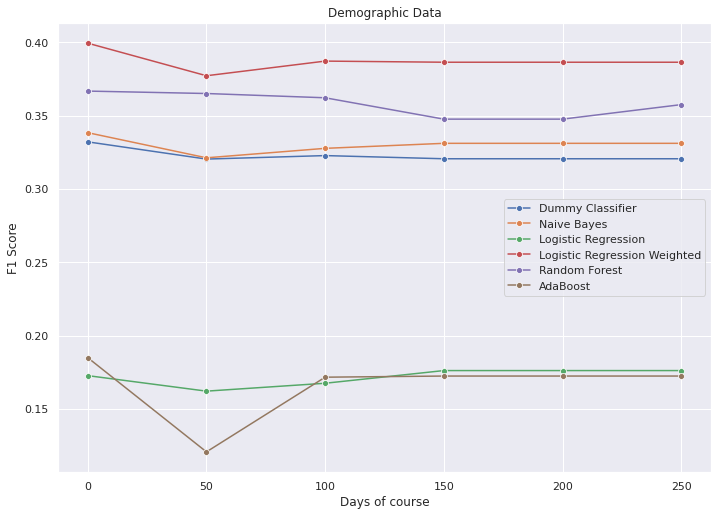

In [ ]:
plot_days_compare(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

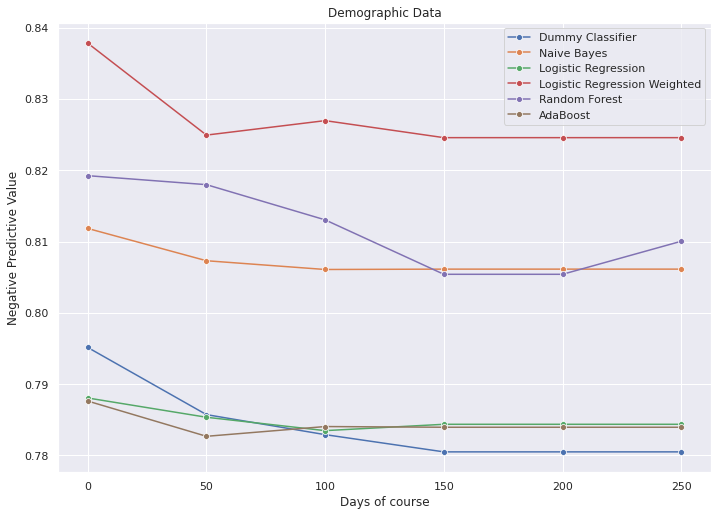

In [ ]:
plot_days_compare_npv(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

#### Learning behaviour data

##### Prepare data for prediction

In [ ]:
learning_behaviour_df = {}
for i in df.keys():
  learning_behaviour_df[i] = split_dataframe_by_data_type(df[i], ['learning_behaviour'], include_final_result=True)

In [ ]:
learning_behaviour_df[250]

code_presentation  id_student  questionnaire  oucollaborate       url  \
0                2013B       23629       0.000000       0.000000  0.000000   
1                2013B       25107       0.000000       0.000000  1.076923   
2                2013B       29144       0.000000       0.000000  1.218750   
3                2013B       31663       0.000000       0.000000  1.806452   
4                2013B       34229       0.000000       0.000000  1.125000   
...                ...         ...            ...            ...       ...   
5130             2014J     2688945       1.333333       2.750000  0.000000   
5131             2014J     2692969       0.000000       1.833333  1.000000   
5132             2014J     2694919       0.000000       1.000000  1.000000   
5133             2014J     2698577       0.000000       1.666667  1.000000   
5134             2014J     2698588       0.000000       1.000000  1.000000   

      homepage  resource  mean_click   forumng       quiz  glossary   subpage  \
0     2.250000  1.000000    0.619571  3.863636   2.777778       0.0  2.500000   
1     7.289474  1.769231    1.171028  5.303448   2.481481       2.0  1.500000   
2     4.557377  1.325926    0.865871  3.223140   3.095238       1.0  1.896996   
3     6.095455  1.608392    1.106714  4.207955   3.357143       1.0  1.933884   
4     3.680000  1.119048    1.342644  3.324675   2.500000      13.0  2.104167   
...        ...       ...         ...       ...        ...       ...       ...   
5130  2.860465  1.222222    1.581449  1.000000  16.000000       0.0  1.500000   
5131  3.803738  1.443038    1.302715  2.582192  10.324324       1.0  1.571429   
5132  2.980392  1.250000    5.584503  7.588235  93.571429       0.0  2.000000   
5133  5.513514  1.266667    1.285652  5.150000   6.363636       0.0  2.375000   
5134  3.777778  1.361111    0.763940  2.695652   0.000000       0.0  2.235294   

      ouelluminate  sharedsubpage  oucontent  final_result  
0            0.000            0.0   0.000000             1  
1            1.000            0.0   1.000000             0  
2            0.000            0.0   1.000000             1  
3            1.125            0.0   1.000000             0  
4            0.000            0.0   0.000000             0  
...            ...            ...        ...           ...  
5130         0.000            0.0   4.962963             0  
5131         0.000            0.0   2.496241             0  
5132         0.000            0.0   2.300000             0  
5133         0.000            0.0   2.377551             1  
5134         0.000            0.0   3.208955             0  

[5135 rows x 16 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(learning_behaviour_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['url', 'homepage', 'resource', 'mean_click', 'forumng', 'quiz',
       'glossary', 'subpage', 'sharedsubpage', 'oucontent'],
      dtype='object')
Index([], dtype='object') Index(['oucollaborate', 'url', 'homepage', 'resource', 'mean_click', 'forumng',
       'quiz', 'glossary', 'subpage', 'sharedsubpage', 'oucontent'],
      dtype='object')
Index([], dtype='object') Index(['oucollaborate', 'url', 'homepage', 'resource', 'mean_click', 'forumng',
       'quiz', 'glossary', 'subpage', 'sharedsubpage', 'oucontent'],
      dtype='object')
Index([], dtype='object') Index(['oucollaborate', 'url', 'homepage', 'resource', 'mean_click', 'forumng',
       'quiz', 'glossary', 'subpage', 'sharedsubpage', 'oucontent'],
      dtype='object')
Index([], dtype='object') Index(['oucollaborate', 'url', 'homepage', 'resource', 'mean_click', 'forumng',
       'quiz', 'glossary', 'subpage', 'sharedsubpage', 'oucontent'],
      dtype='object')
Index([], dtype='object') Index(

###### Undersampling

In [ ]:
Y_train[0].value_counts()

0    841
1    303
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({0: 841, 1: 303})
Resample dataset shape Counter({0: 303, 1: 303})
Sampling for day 50
Original dataset shape: Counter({0: 1053, 1: 414})
Resample dataset shape Counter({0: 414, 1: 414})
Sampling for day 100
Original dataset shape: Counter({0: 1060, 1: 417})
Resample dataset shape Counter({0: 417, 1: 417})
Sampling for day 150
Original dataset shape: Counter({0: 1063, 1: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 200
Original dataset shape: Counter({0: 1063, 1: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 250
Original dataset shape: Counter({0: 1064, 1: 421})
Resample dataset shape Counter({0: 421, 1: 421})


###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train[i].index)
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test[i].index)

In [ ]:
X_train[250]

mean_click   forumng      quiz  glossary  oucontent
1135    0.407342  0.105587  0.236594  0.090909   0.244444
1136    0.345807  0.077320  0.330045  0.181818   0.094444
1137    0.429784  0.384545  0.242653  0.000000   0.125000
1138    0.402270  0.180859  0.268950  0.000000   0.133333
1139    0.497011  0.159693  0.285884  0.000000   0.333333
...          ...       ...       ...       ...        ...
2615    0.042079  0.000000  0.000000  0.000000   0.000000
2616    0.503093  0.175356  0.274031  0.227273   0.176190
2617    0.376955  0.134021  0.262974  0.000000   0.283333
2618    0.372525  0.122423  0.273548  0.000000   0.122222
2619    0.598541  0.092047  0.357007  0.000000   0.550000

[1485 rows x 5 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

learning_behaviour_results_du = []
learning_behaviour_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_du.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.476
Best parameters set:
Accuracy: 0.5178105994787141, F1 Score: 0.33212996389891697, Precision: 0.24, Recall: 0.5390625


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.434
Best parameters set:
Accuracy: 0.5082304526748971, F1 Score: 0.32037914691943126, Precision: 0.23150684931506849, Recall: 0.52


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.453
Best parameters set:
Accuracy: 0.508130081300813, F1 Score: 0.32276119402985076, Precision: 0.23410013531799728, Recall: 0.5195195195195195


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.469
Best parameters set:
Accuracy: 0.5064

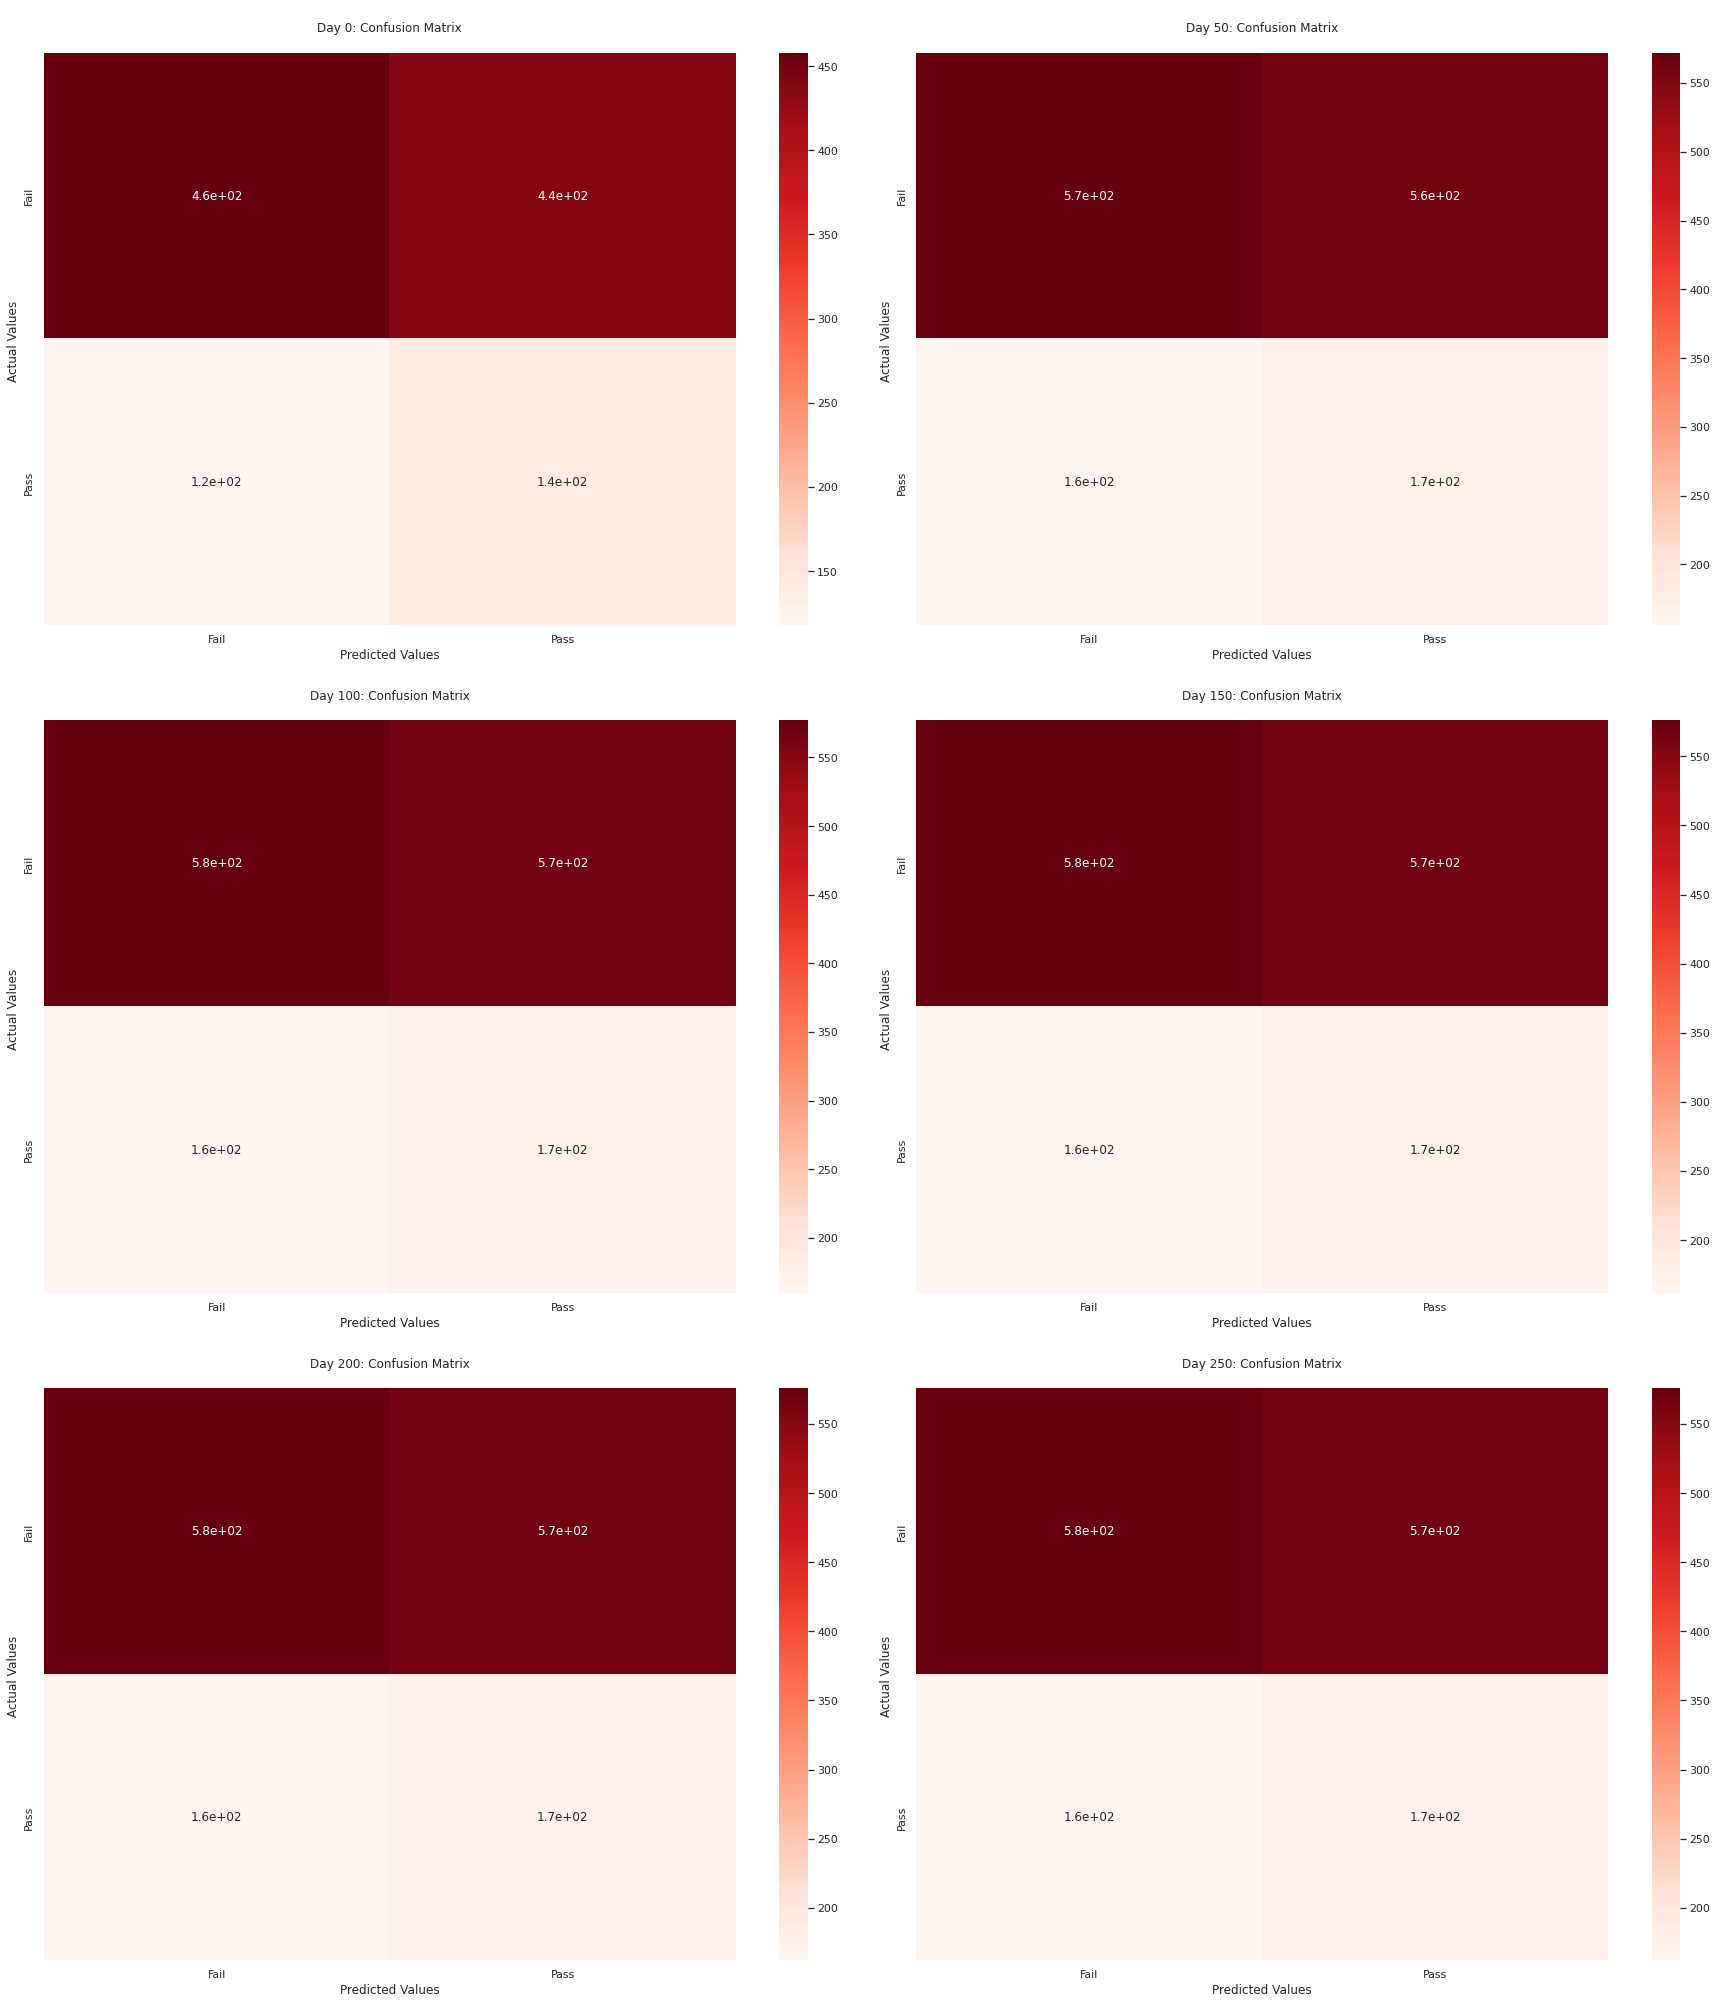

In [ ]:
plot_confusion_matrix(learning_behaviour_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

learning_behaviour_results_nb = []
learning_behaviour_features_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_nb.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_nb.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.466
Best parameters set:
Accuracy: 0.5056472632493484, F1 Score: 0.3467278989667049, Precision: 0.24552845528455283, Recall: 0.58984375


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.513
Best parameters set:
Accuracy: 0.6412894375857339, F1 Score: 0.33375796178343947, Precision: 0.2847826086956522, Recall: 0.40307692307692305


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.483
Best parameters set:
Accuracy: 0.4898373983739837, F1 Score: 0.2794258373205742, Precision: 0.2050561797752809, Recall: 0.43843843843843844


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.500
Best par

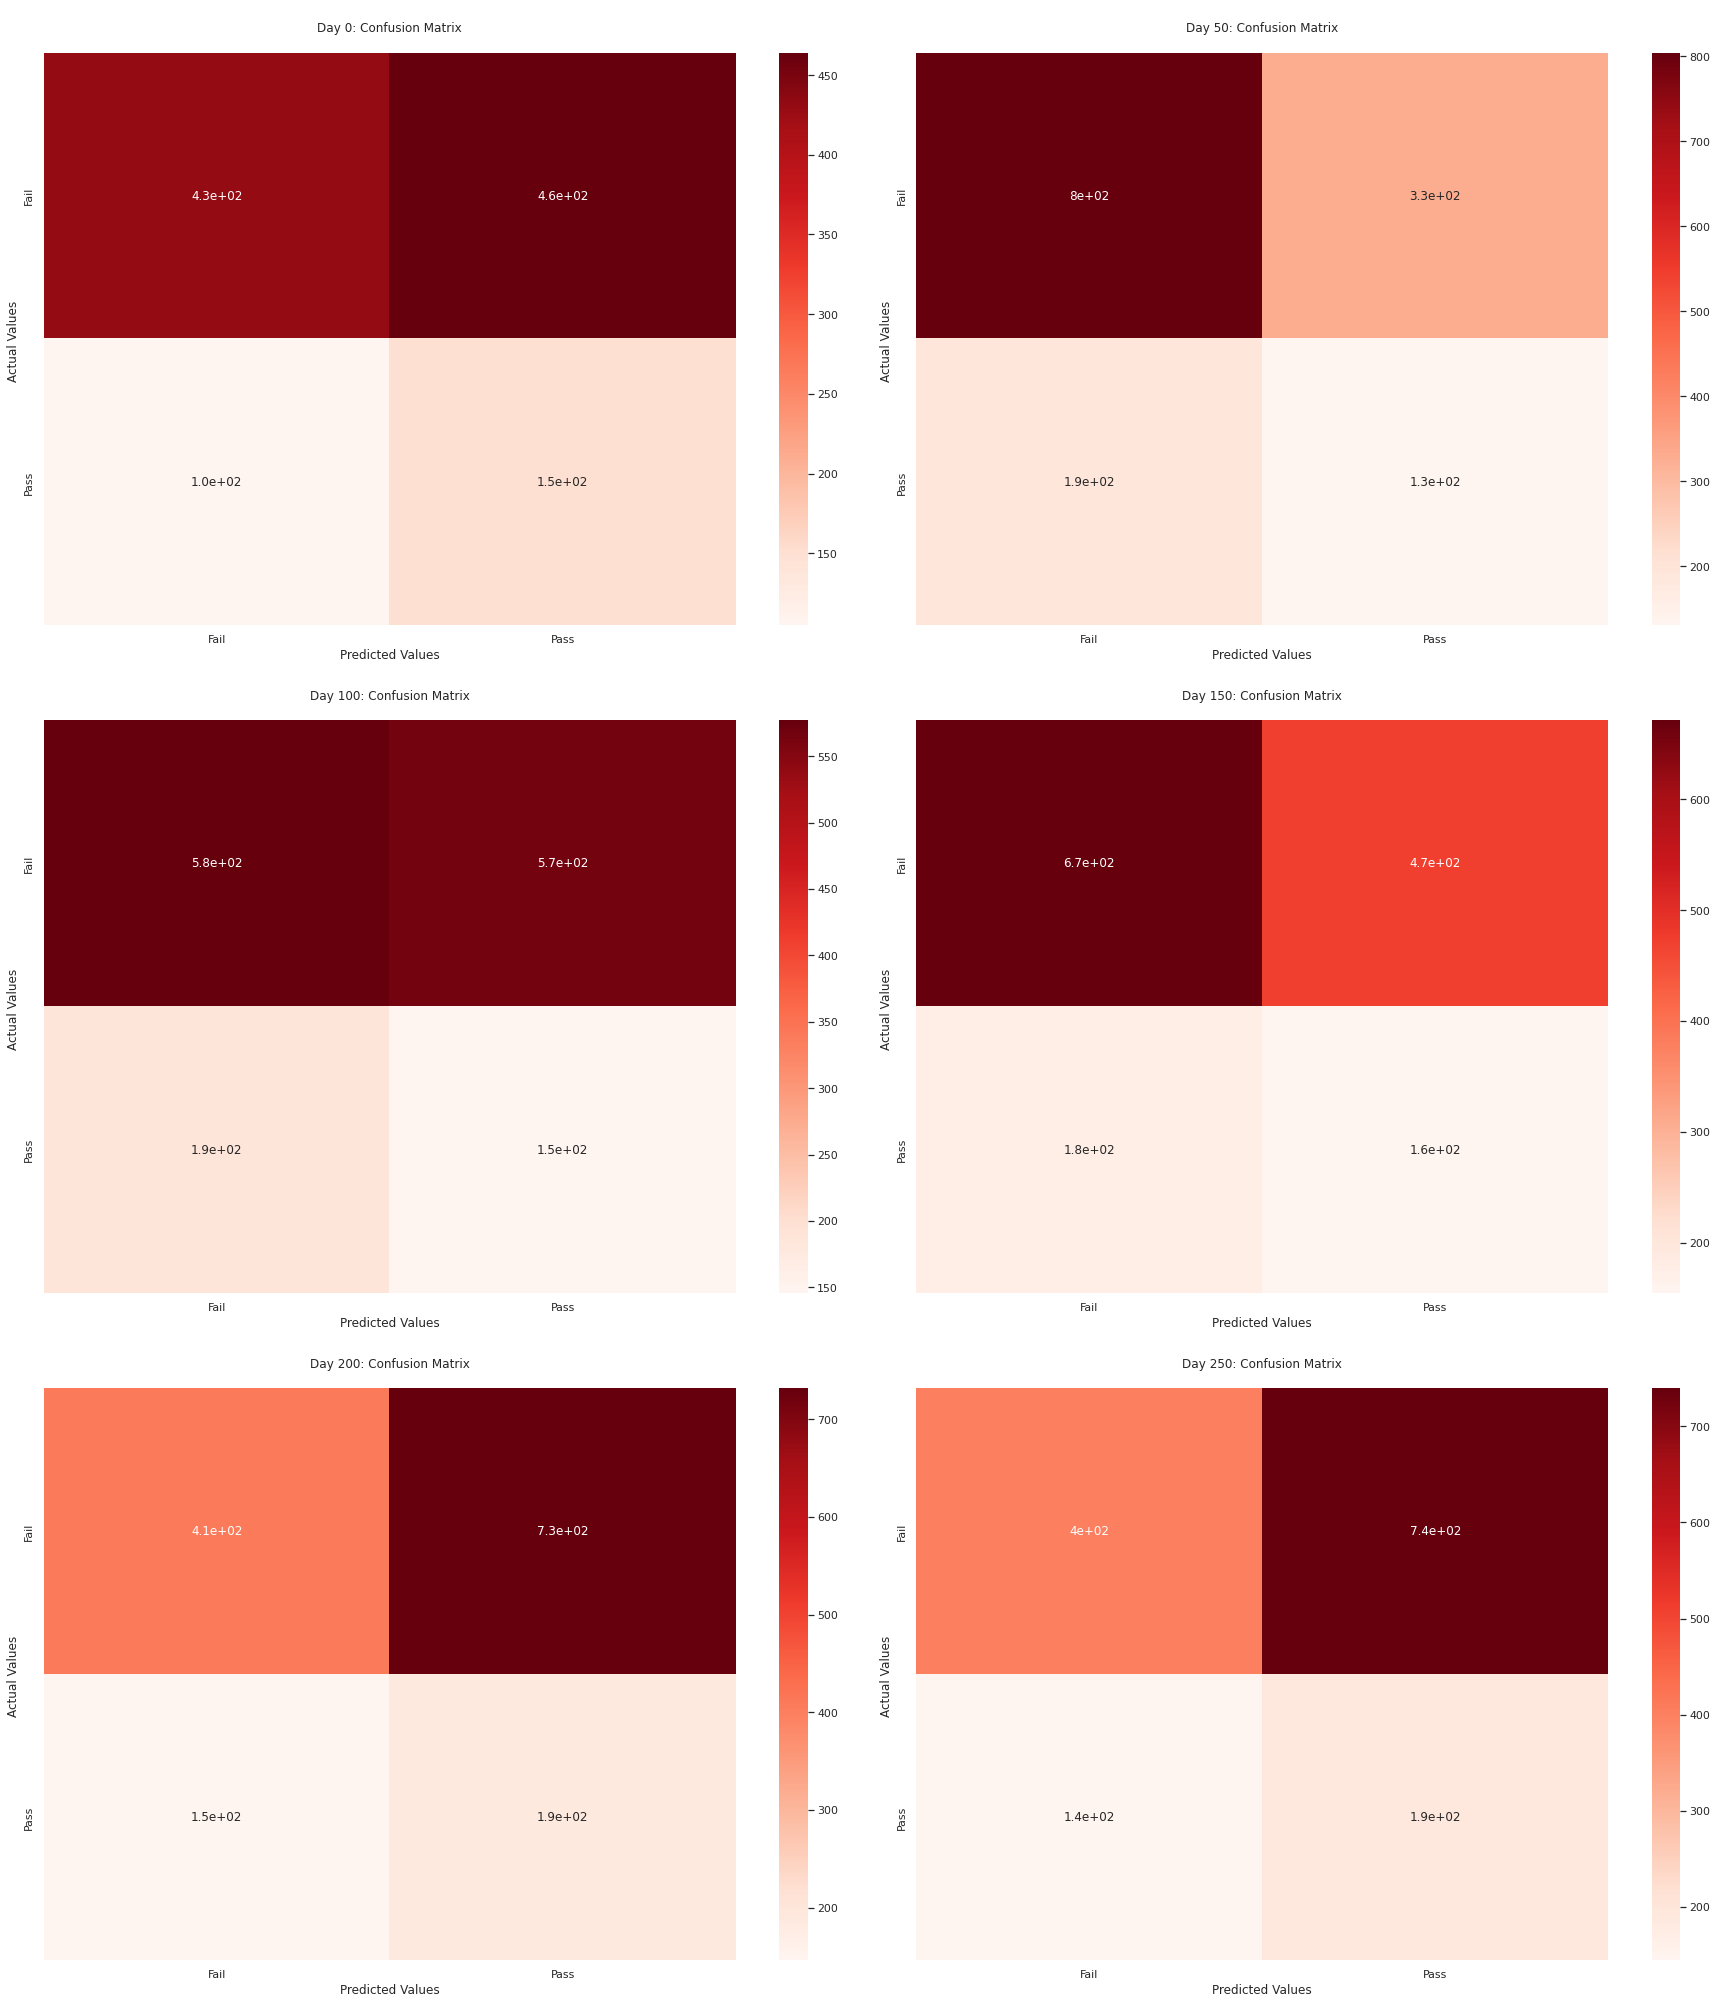

In [ ]:
plot_confusion_matrix(learning_behaviour_results_nb)

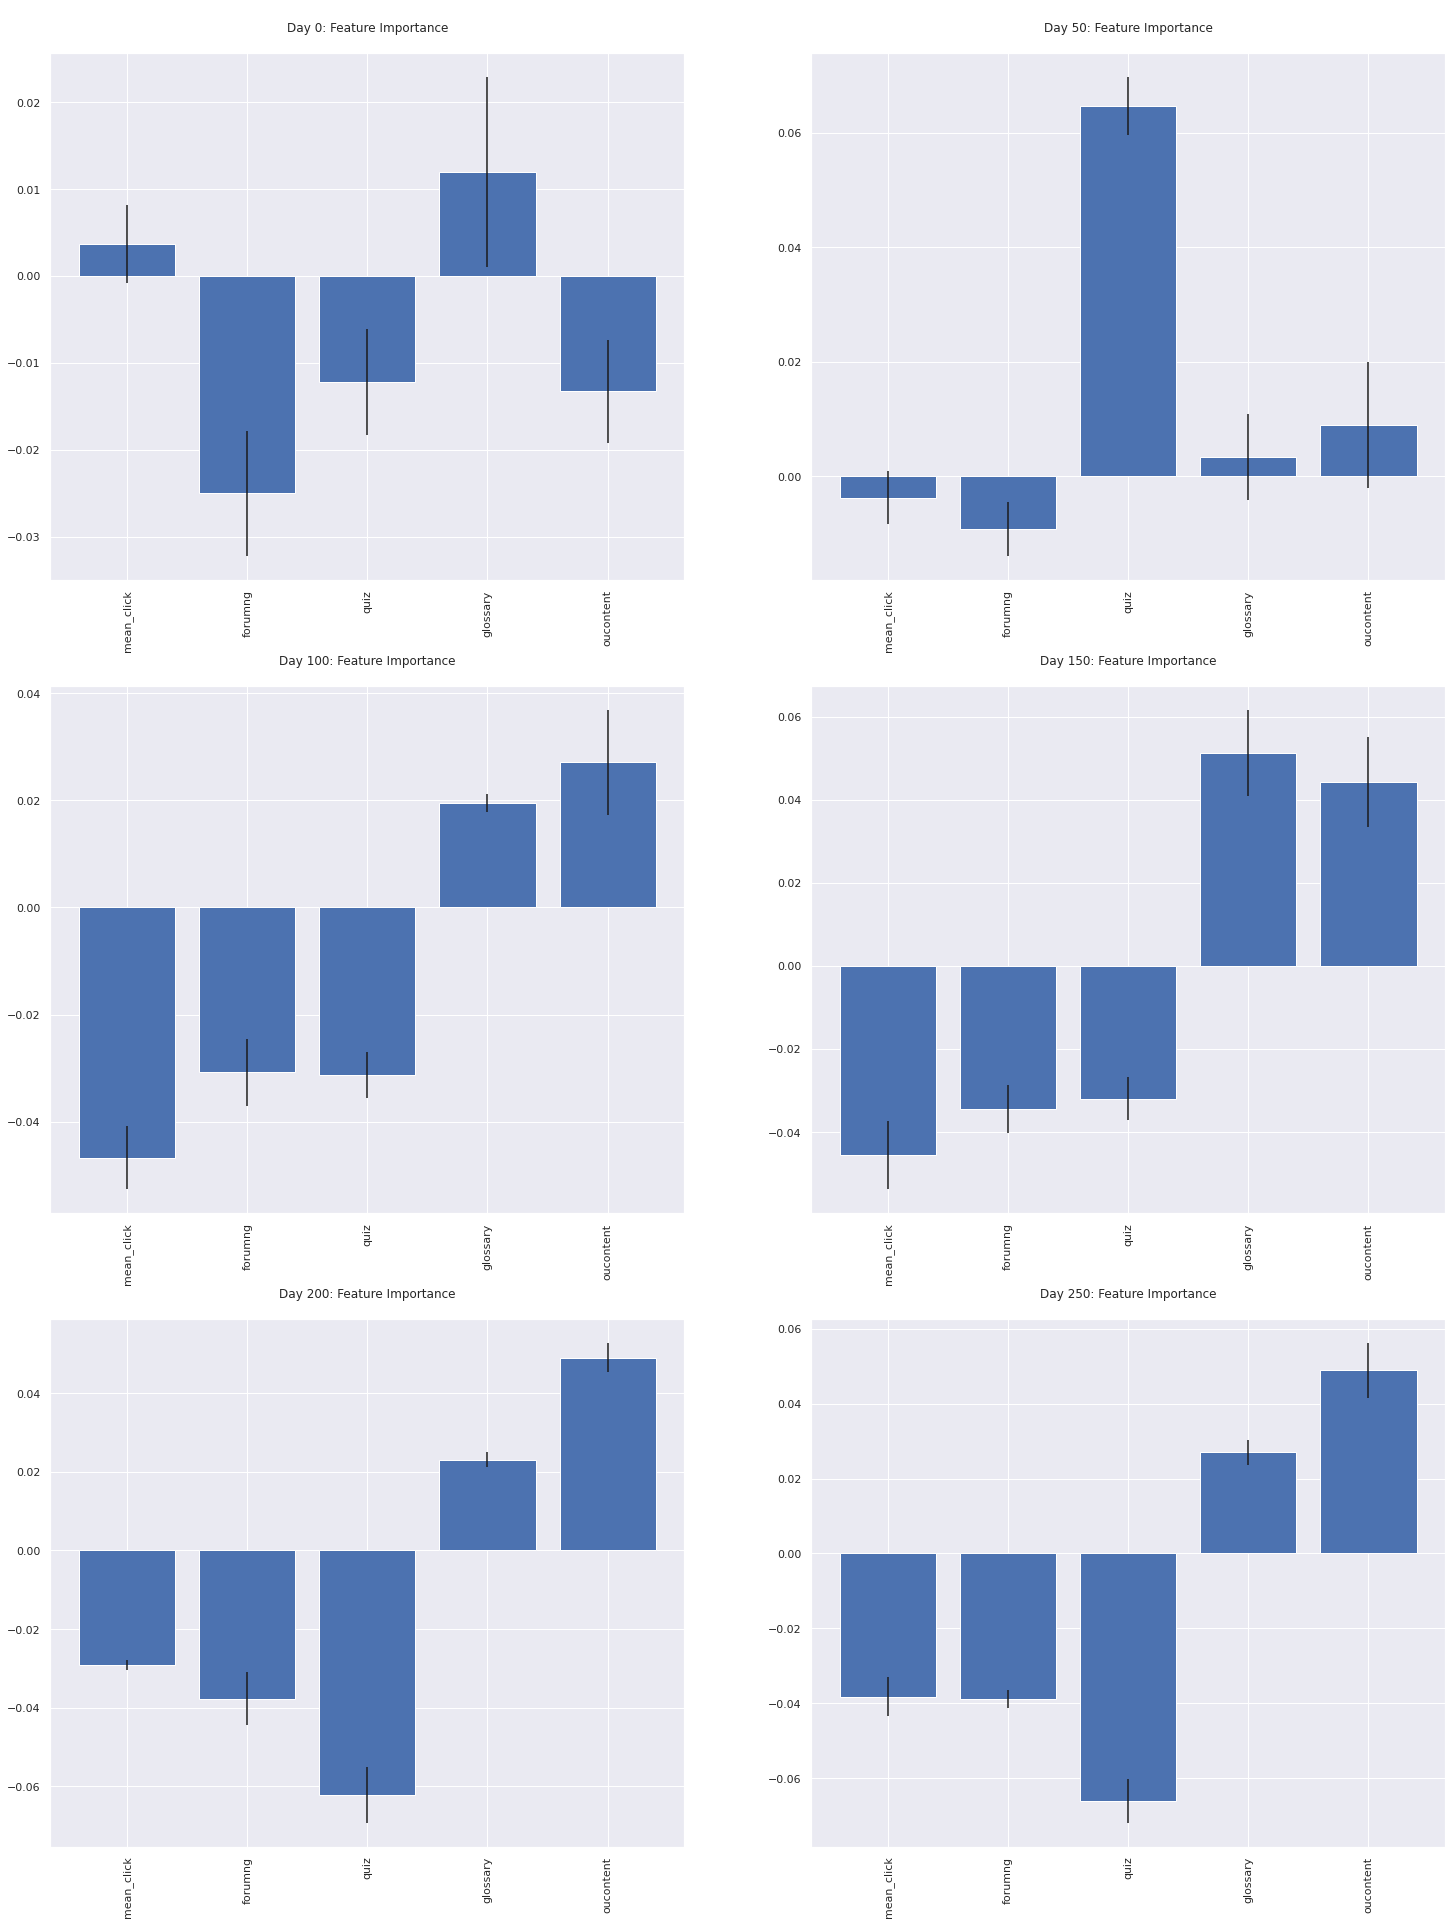

In [ ]:
plot_feature_importance(learning_behaviour_features_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

learning_behaviour_results_lr = []
learning_behiviour_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lr.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.424
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.7775847089487402, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.539
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7318244170096022, F1 Score: 0.3079646017699115, Precision: 0.3625, Recall: 0.2676923076923077


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.600
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7113821138211383, F1 Score: 0.4, Precision: 0.376657824933687, Recall: 0.4264264264264264


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.615
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7373053486797563, F1 Score: 0.4226190476190476, Precision: 0.42011834319526625, Recall: 0.4251497005988024


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.73

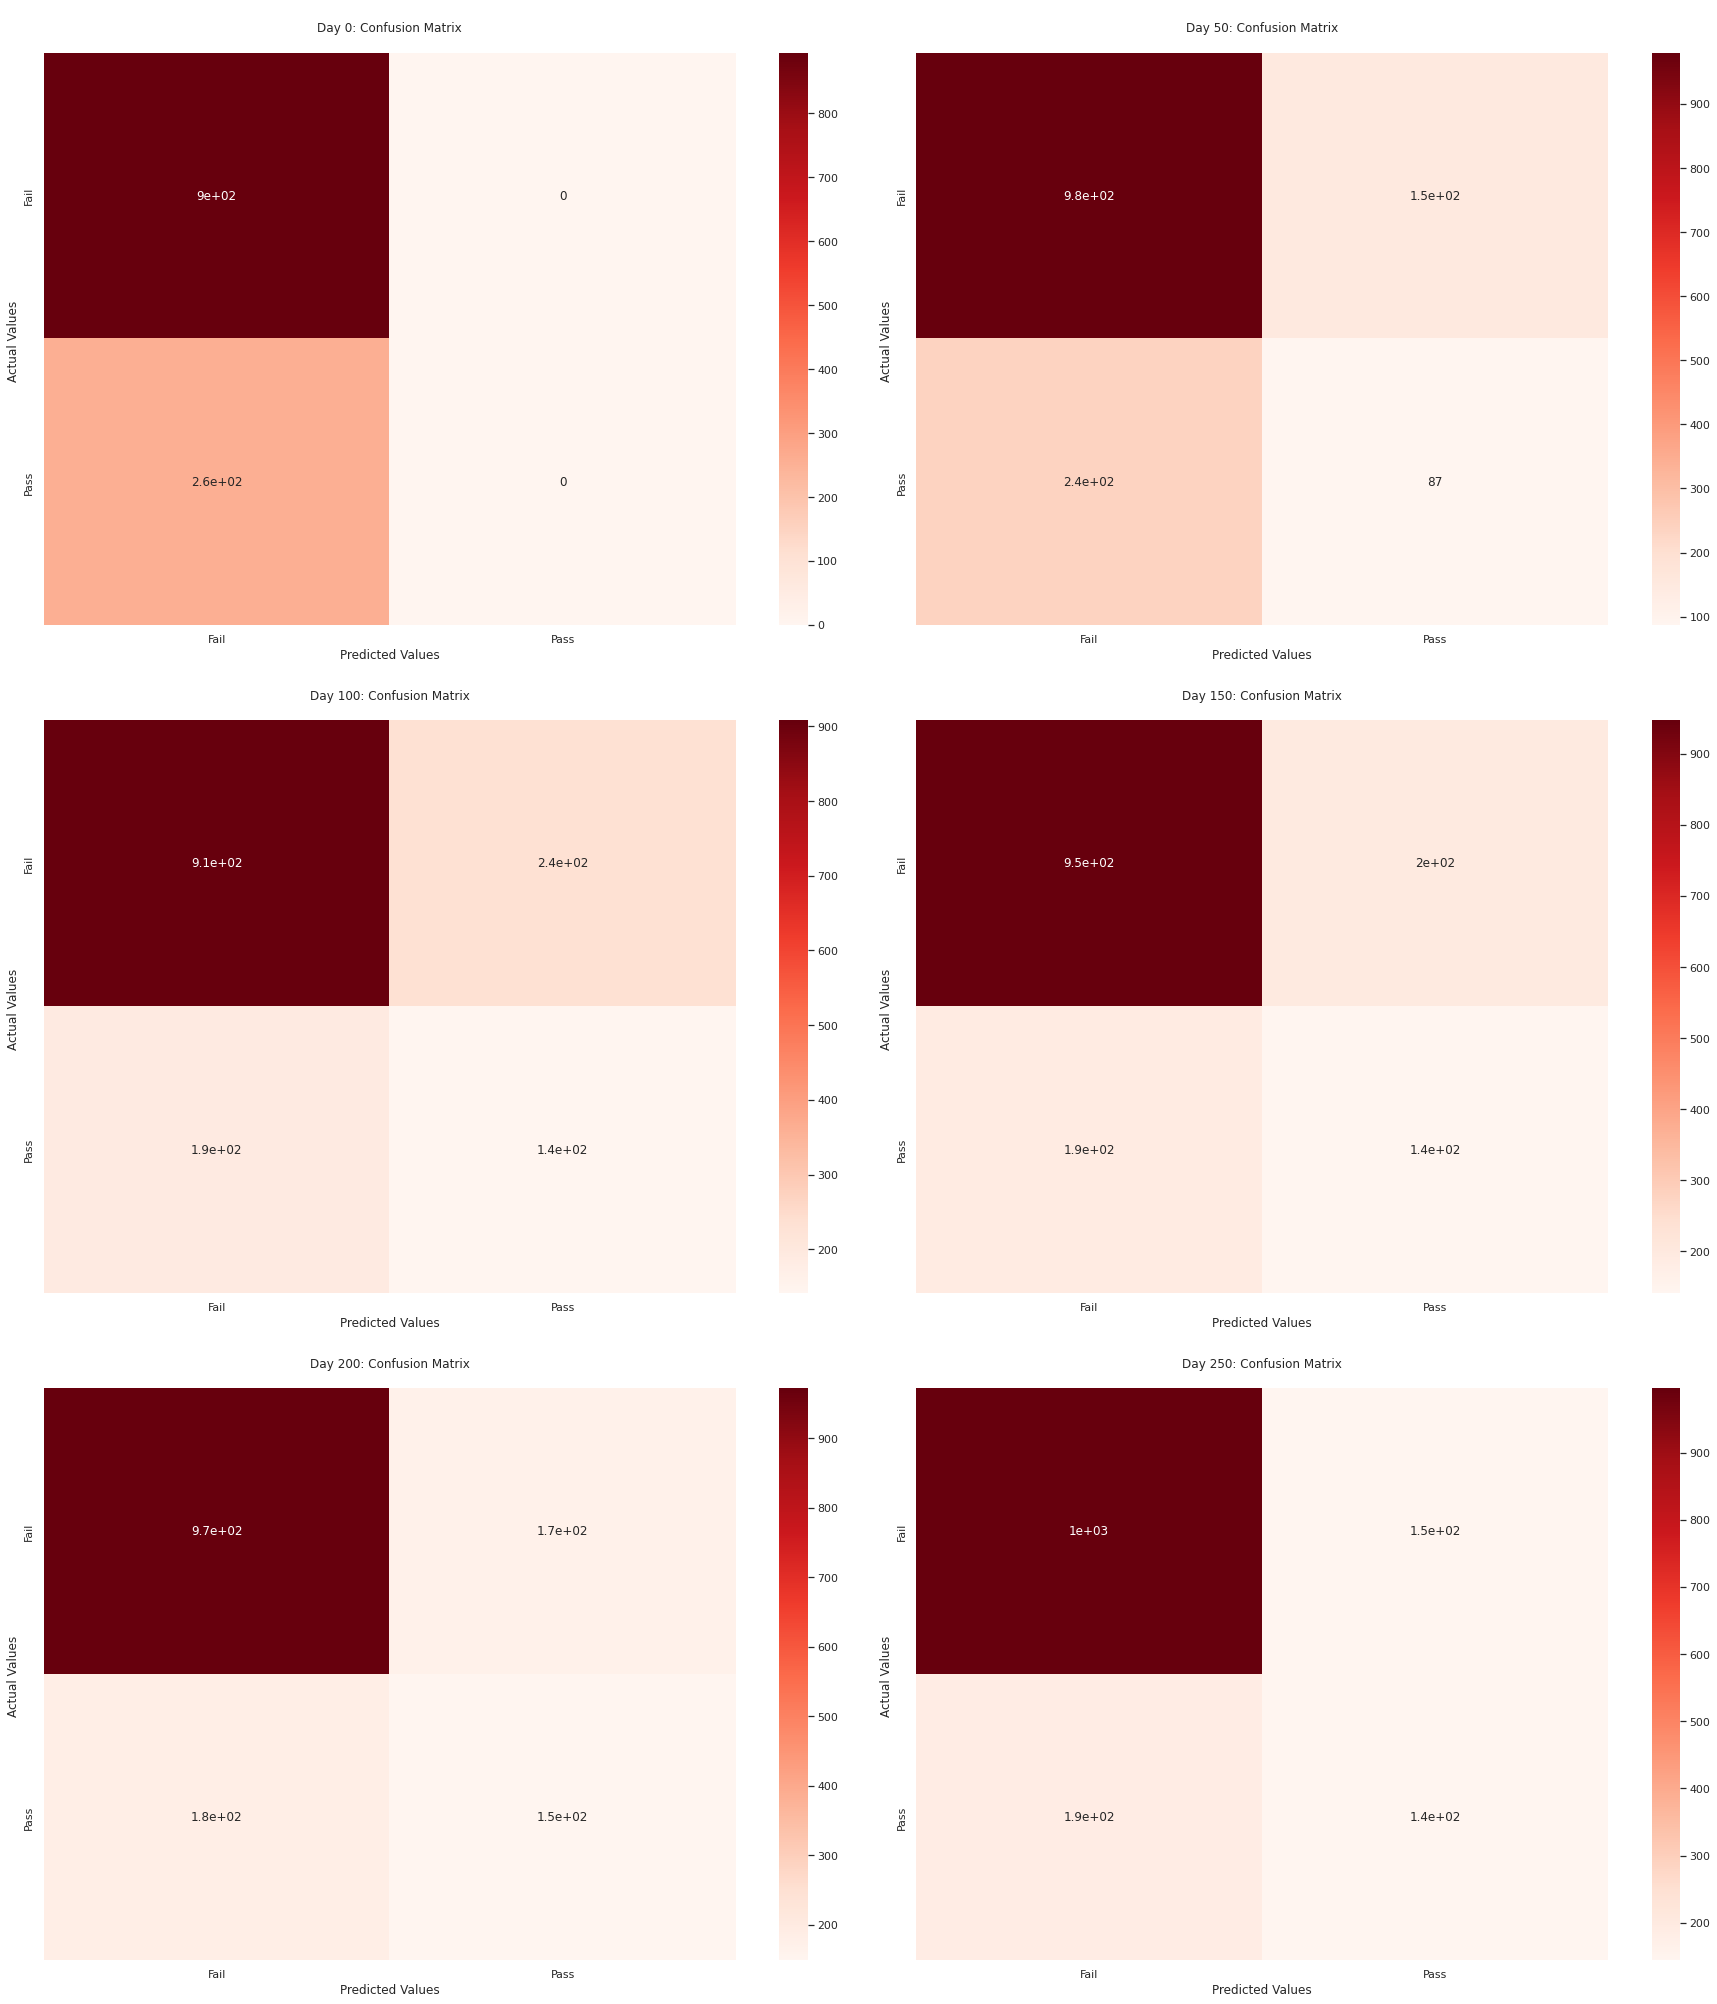

In [ ]:
plot_confusion_matrix(learning_behaviour_results_lr)

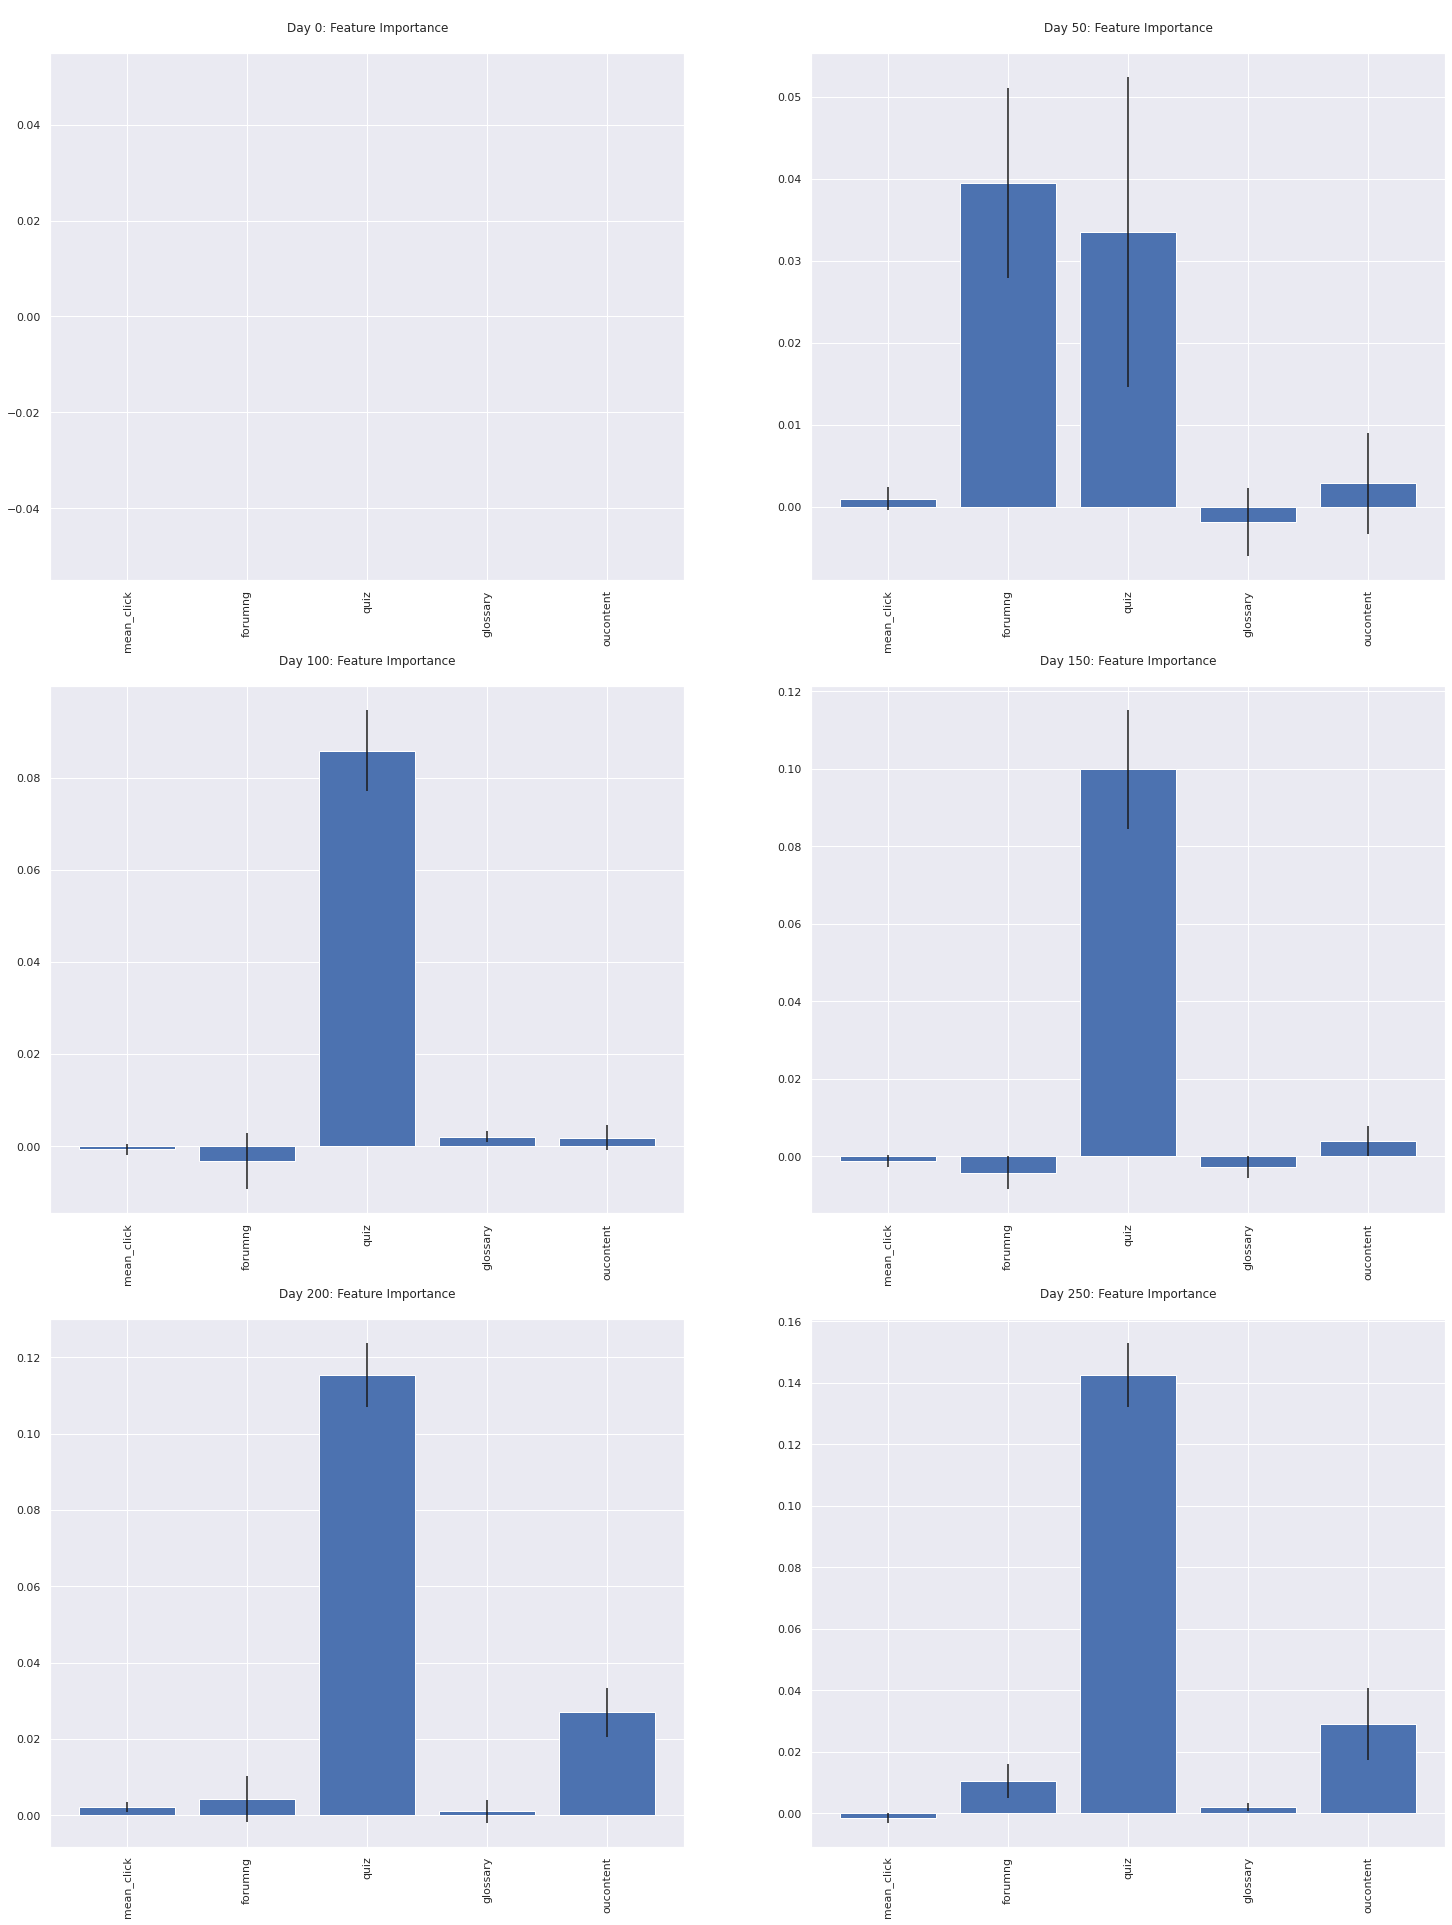

In [ ]:
plot_feature_importance(learning_behiviour_features_lr)

##### WeightedLogisticRegression

In [ ]:
learning_behaviour_results_lrw = []
learning_behaviour_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lrw.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_lrw.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.506
Best parameters set:
Accuracy: 0.45351867940920937, F1 Score: 0.3753723932472691, Precision: 0.25166444740346205, Recall: 0.73828125


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.612
Best parameters set:
Accuracy: 0.6042524005486969, F1 Score: 0.38288770053475935, Precision: 0.2934426229508197, Recall: 0.5507692307692308


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.602
Best parameters set:
Accuracy: 0.7025745257452575, F1 Score: 0.43933588761174974, Precision: 0.38222222222222224, Recall: 0.5165165165165165


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.624
Best pa

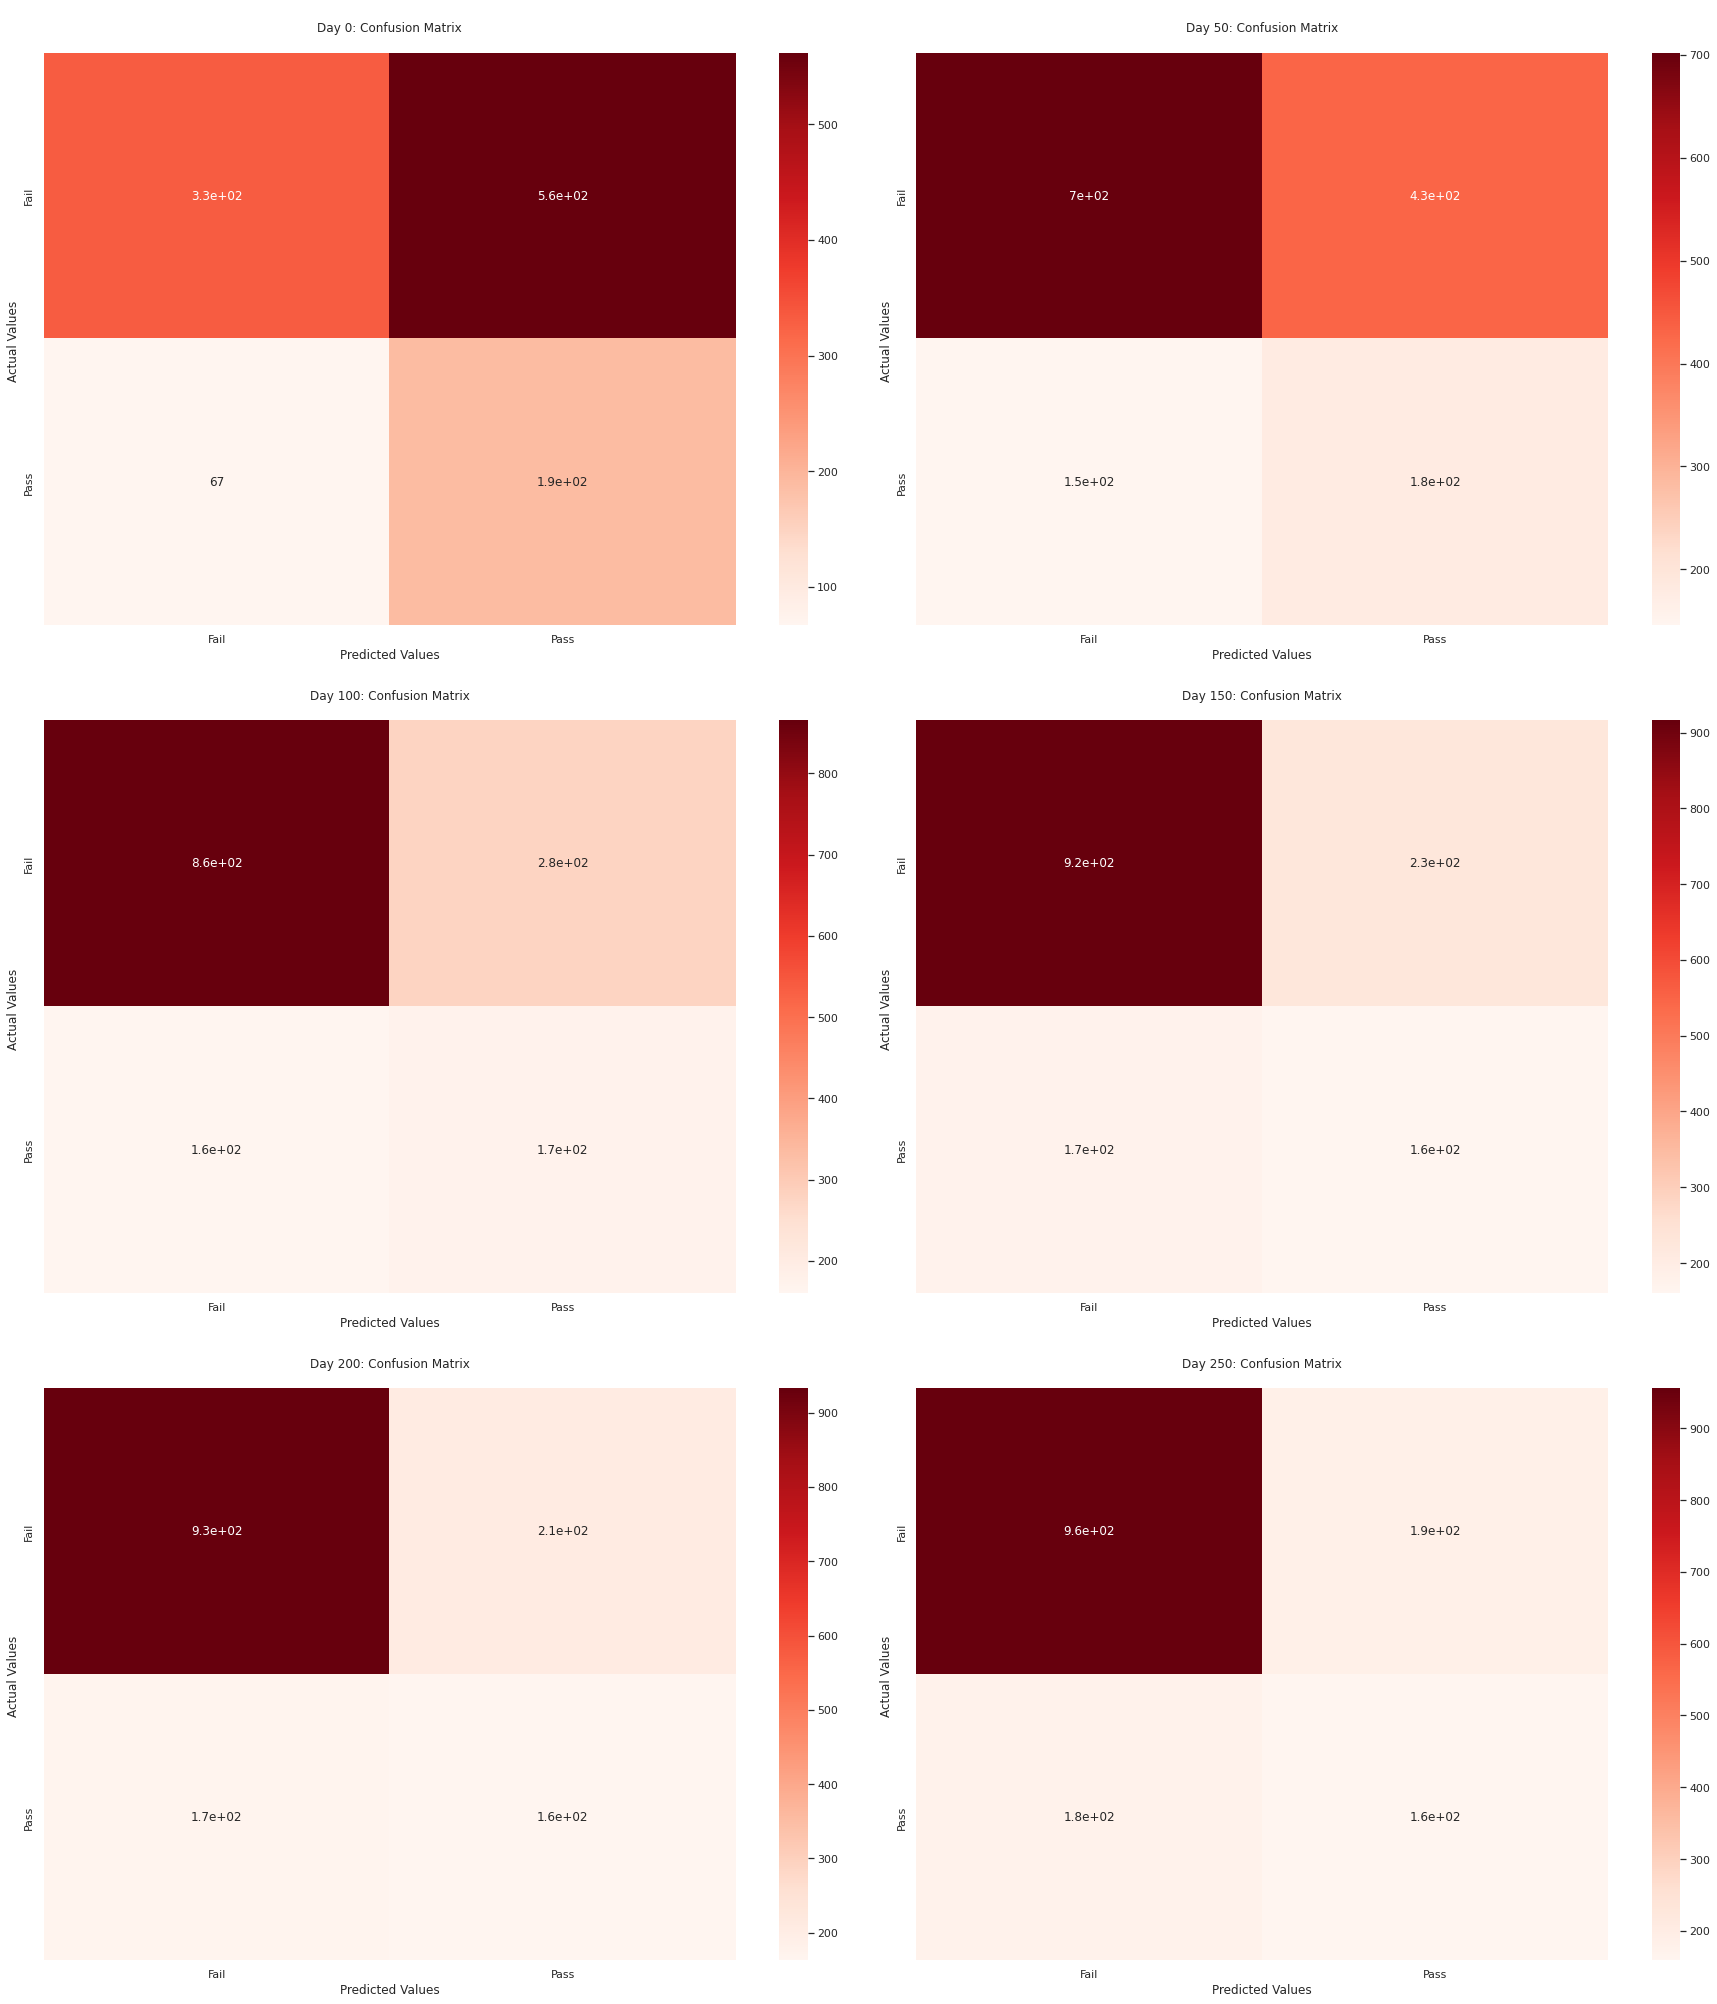

In [ ]:
plot_confusion_matrix(learning_behaviour_results_lrw)

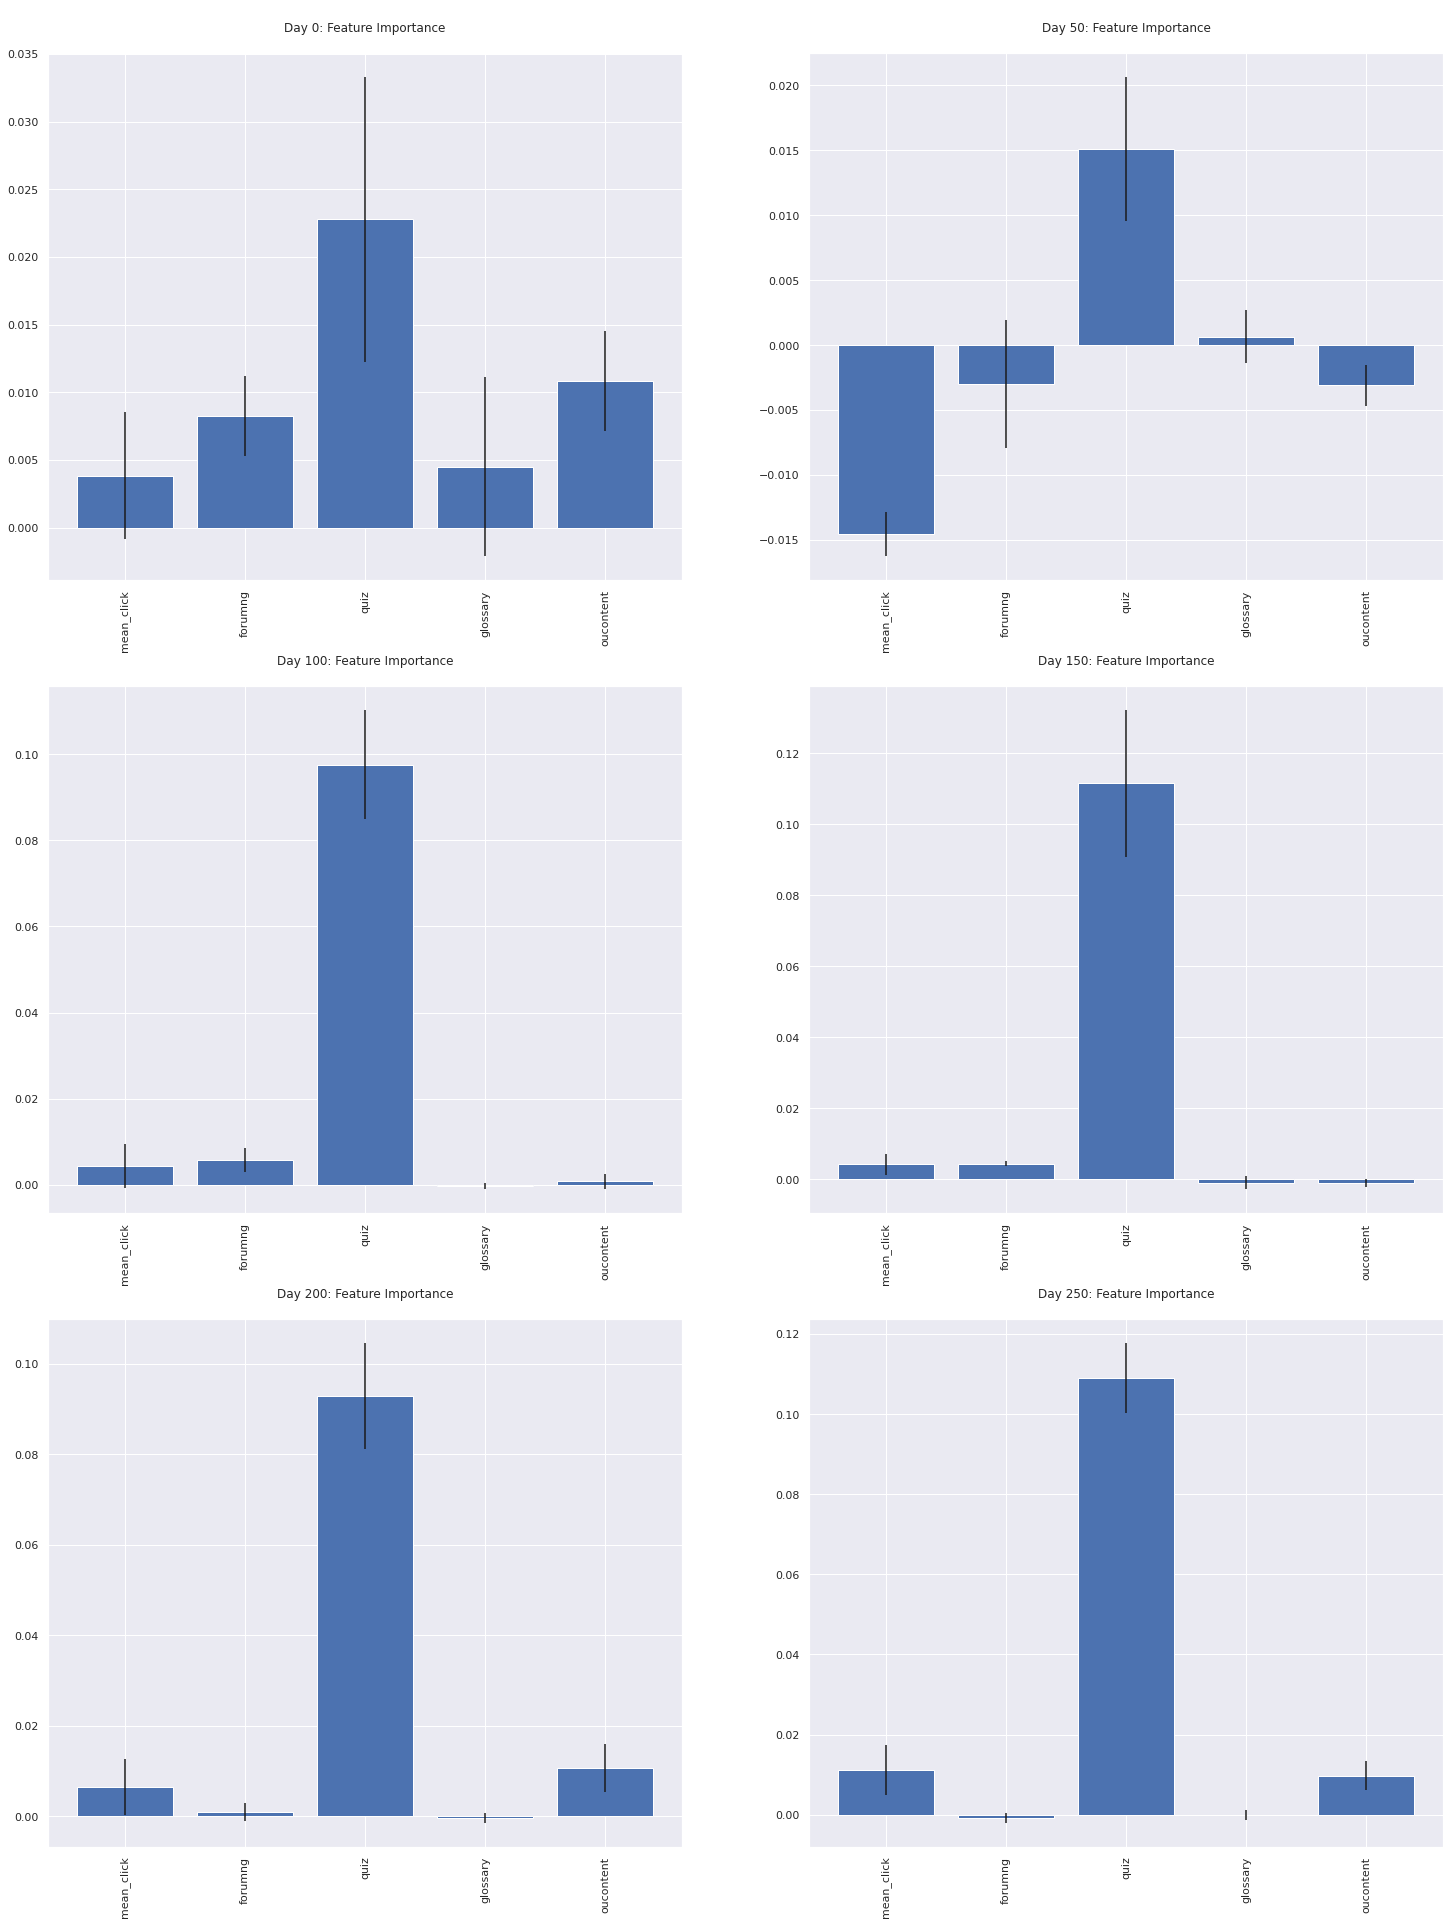

In [ ]:
plot_feature_importance(learning_behaviour_features_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

learning_behaviour_results_rf = []
learning_behaviour_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_rf.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.498
Best parameters set:
	clf__n_estimators: 80
Accuracy: 0.7324066029539531, F1 Score: 0.22999999999999998, Precision: 0.3194444444444444, Recall: 0.1796875


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.605
Best parameters set:
	clf__n_estimators: 100
Accuracy: 0.7181069958847737, F1 Score: 0.2430939226519337, Precision: 0.30275229357798167, Recall: 0.20307692307692307


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.646
Best parameters set:
	clf__n_estimators: 50


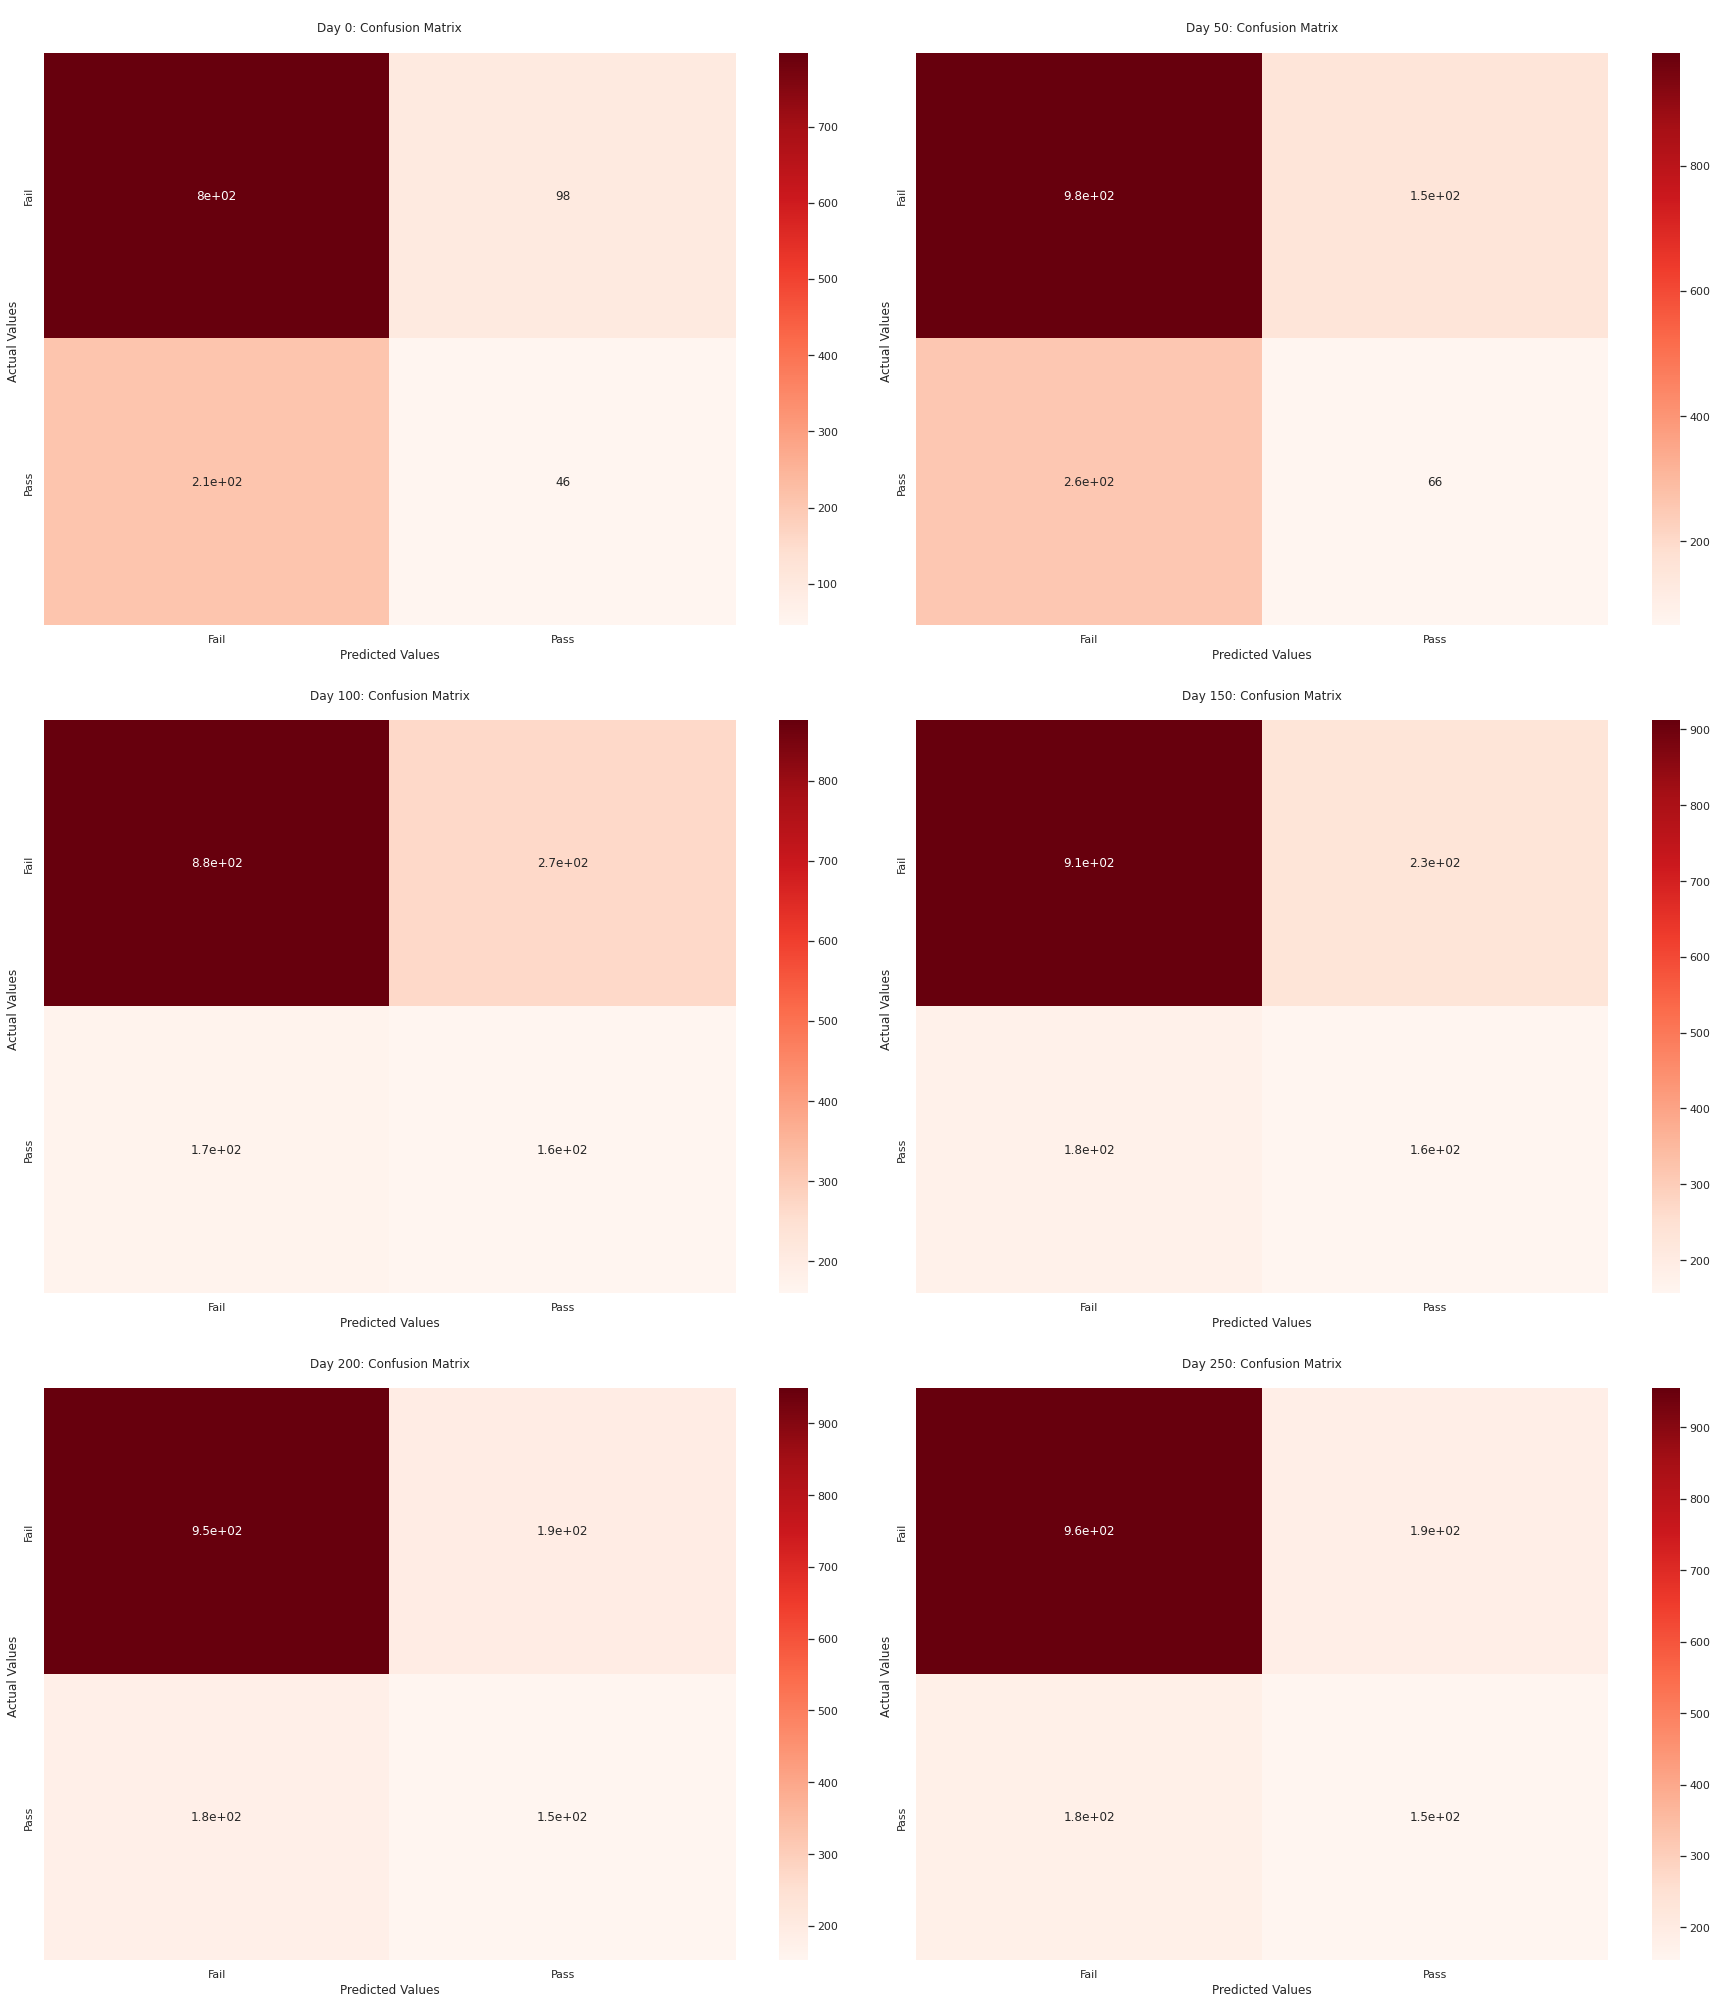

In [ ]:
plot_confusion_matrix(learning_behaviour_results_rf)

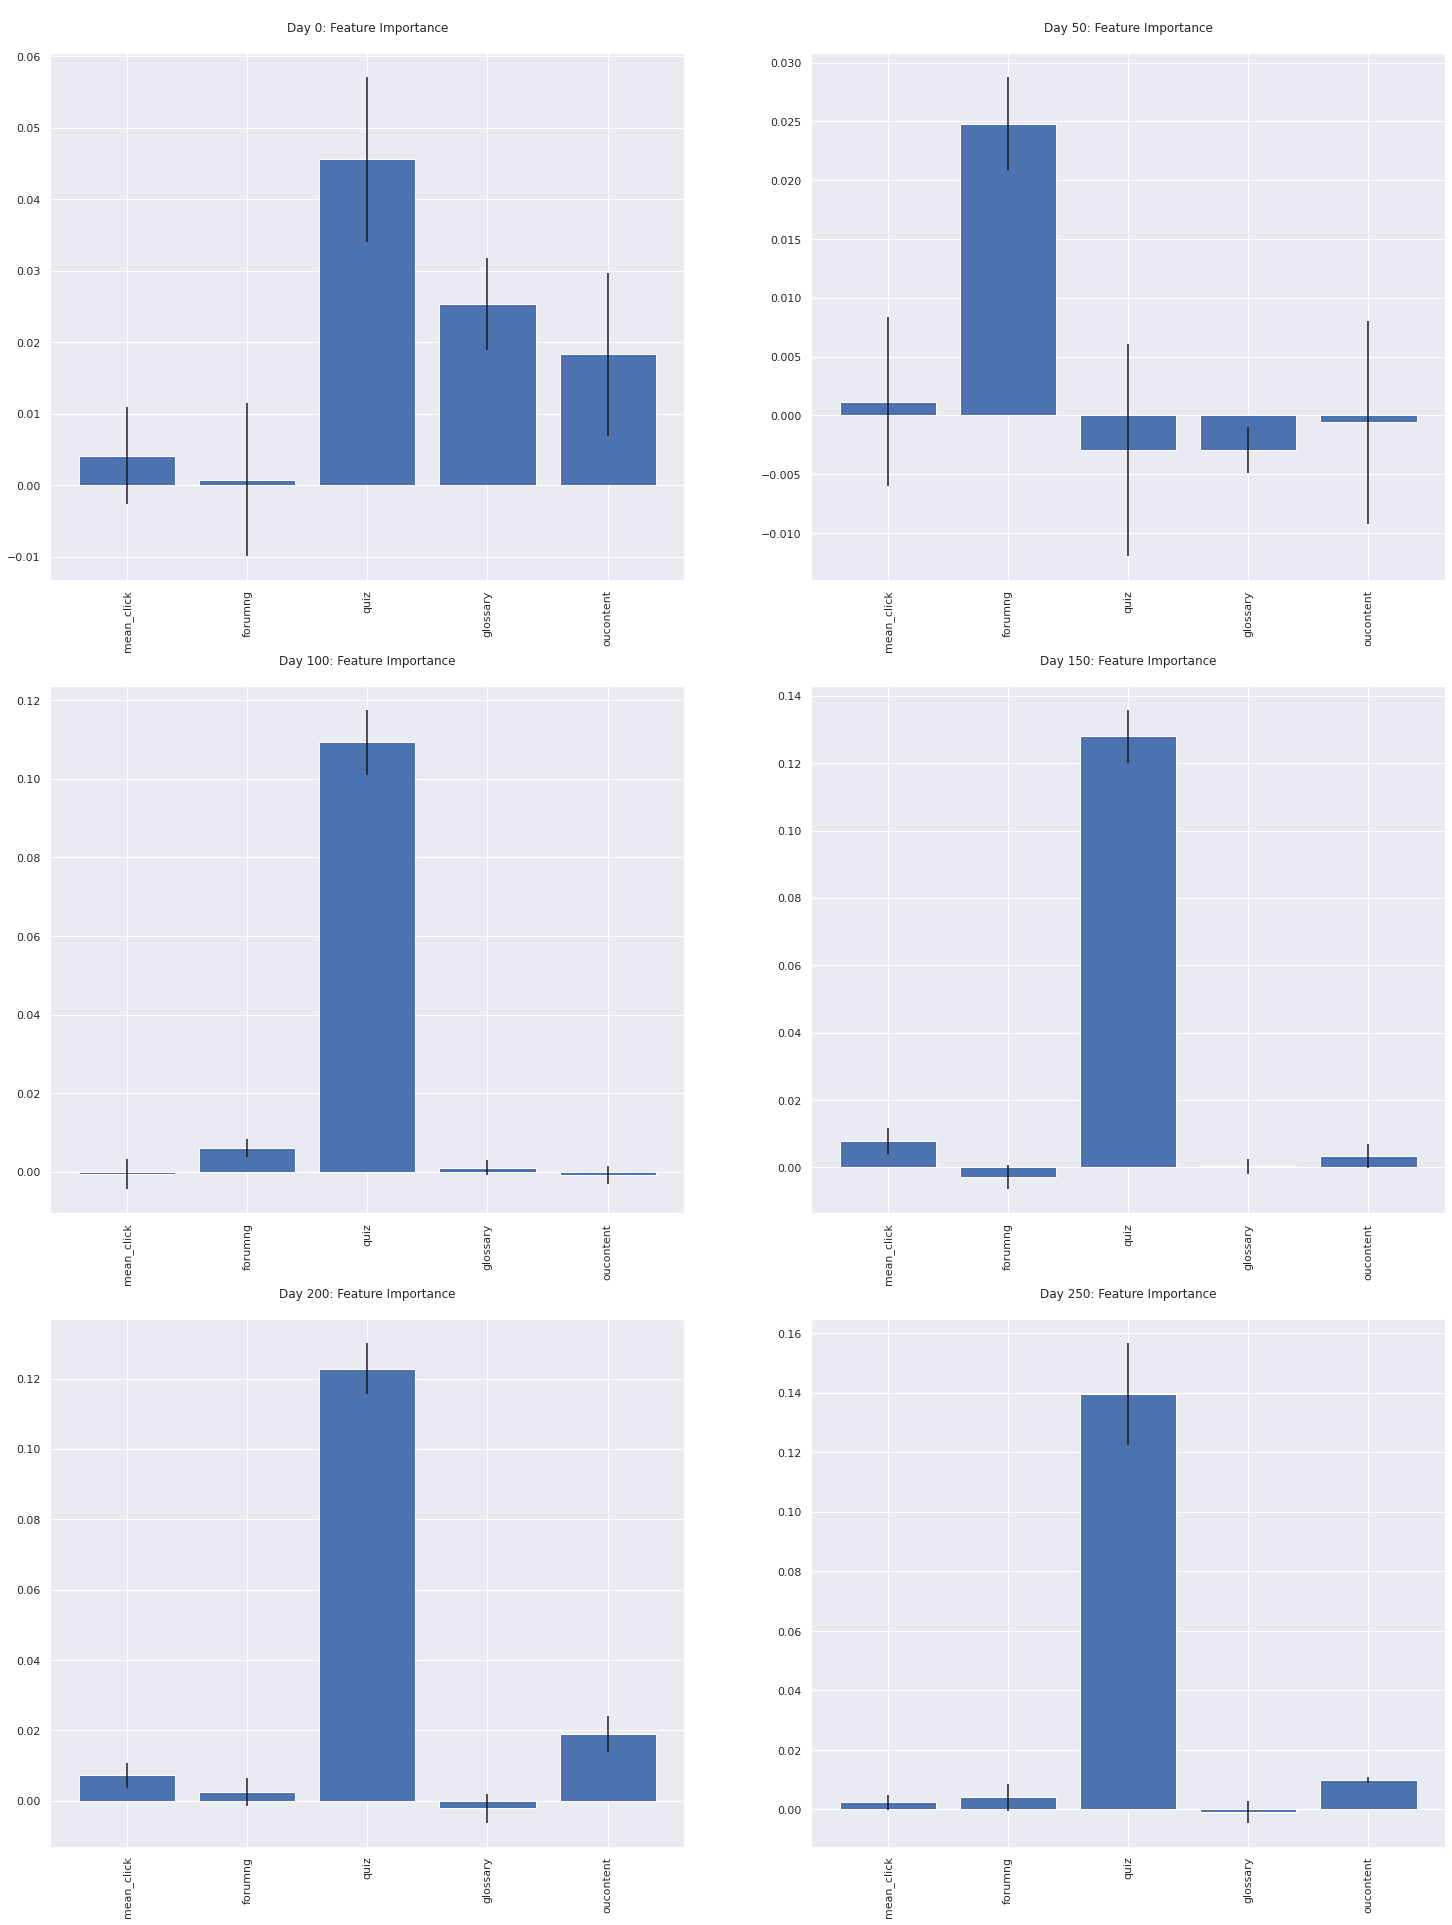

In [ ]:
plot_feature_importance(learning_behaviour_features_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

learning_behaviour_results_ab = []
learning_behiviour_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_ab.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_ab.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.459
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.7419635099913119, F1 Score: 0.0804953560371517, Precision: 0.19402985074626866, Recall: 0.05078125


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.583
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.6844993141289437, F1 Score: 0.3313953488372093, Precision: 0.3140495867768595, Recall: 0.3507692307692308


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.641
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.6964769647696477, F1 Score:

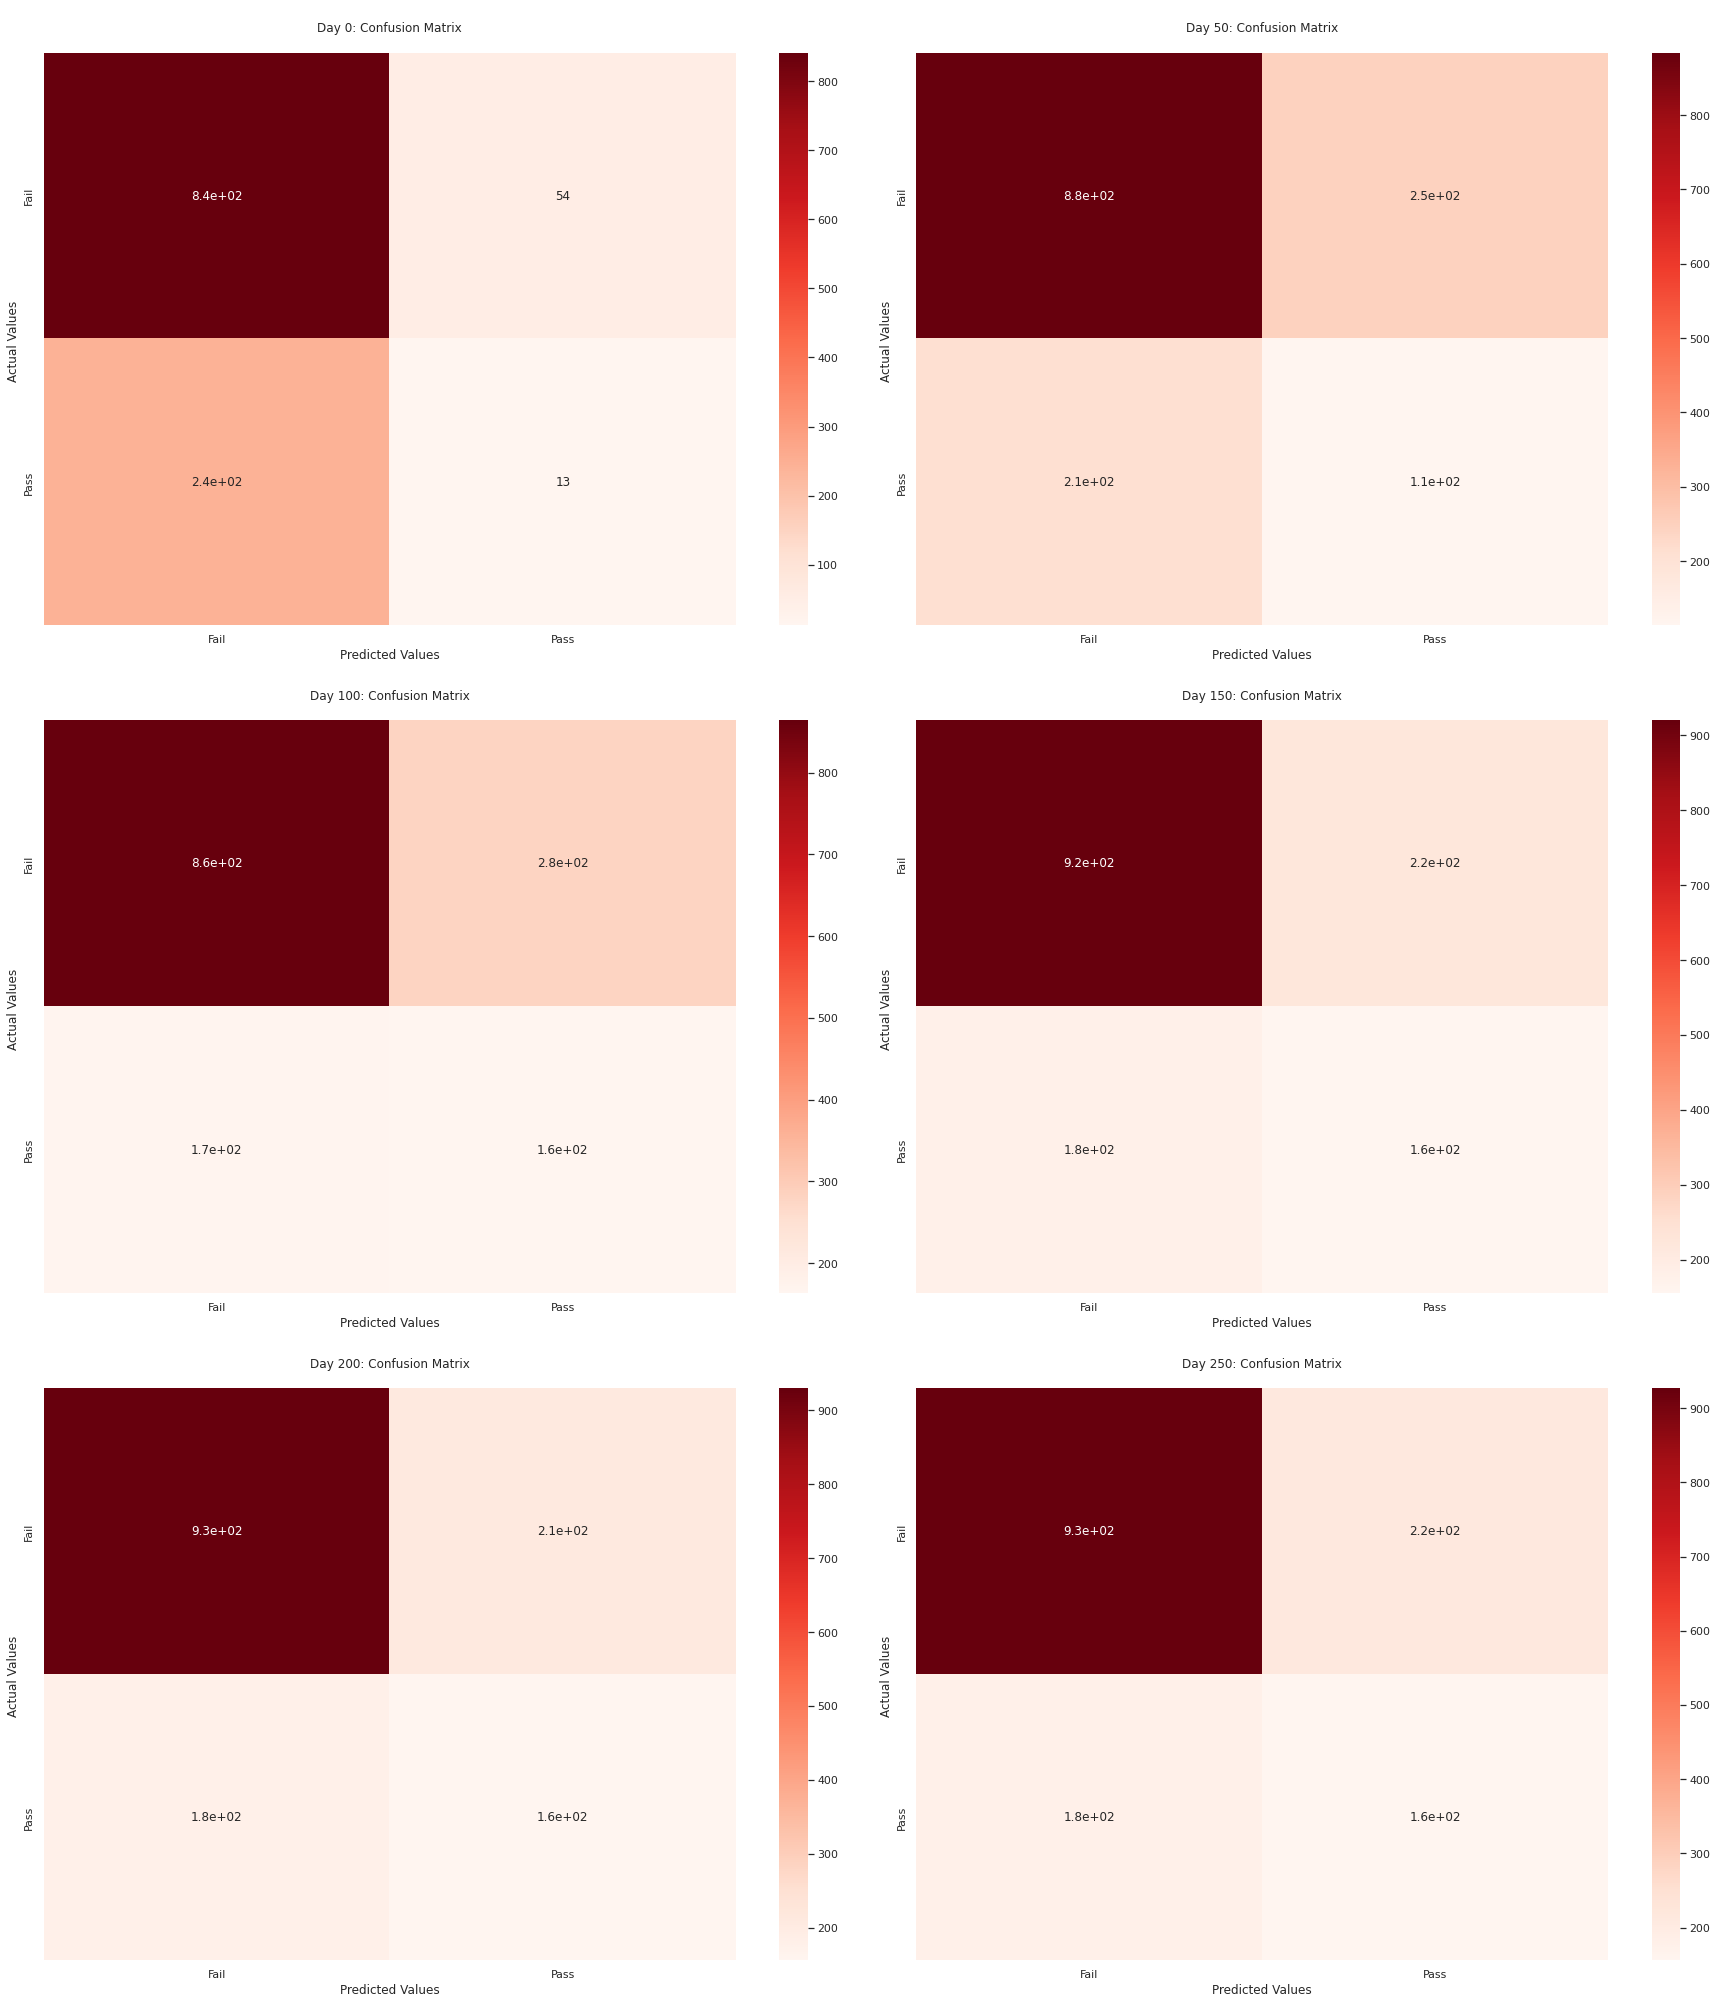

In [ ]:
plot_confusion_matrix(learning_behaviour_results_ab)

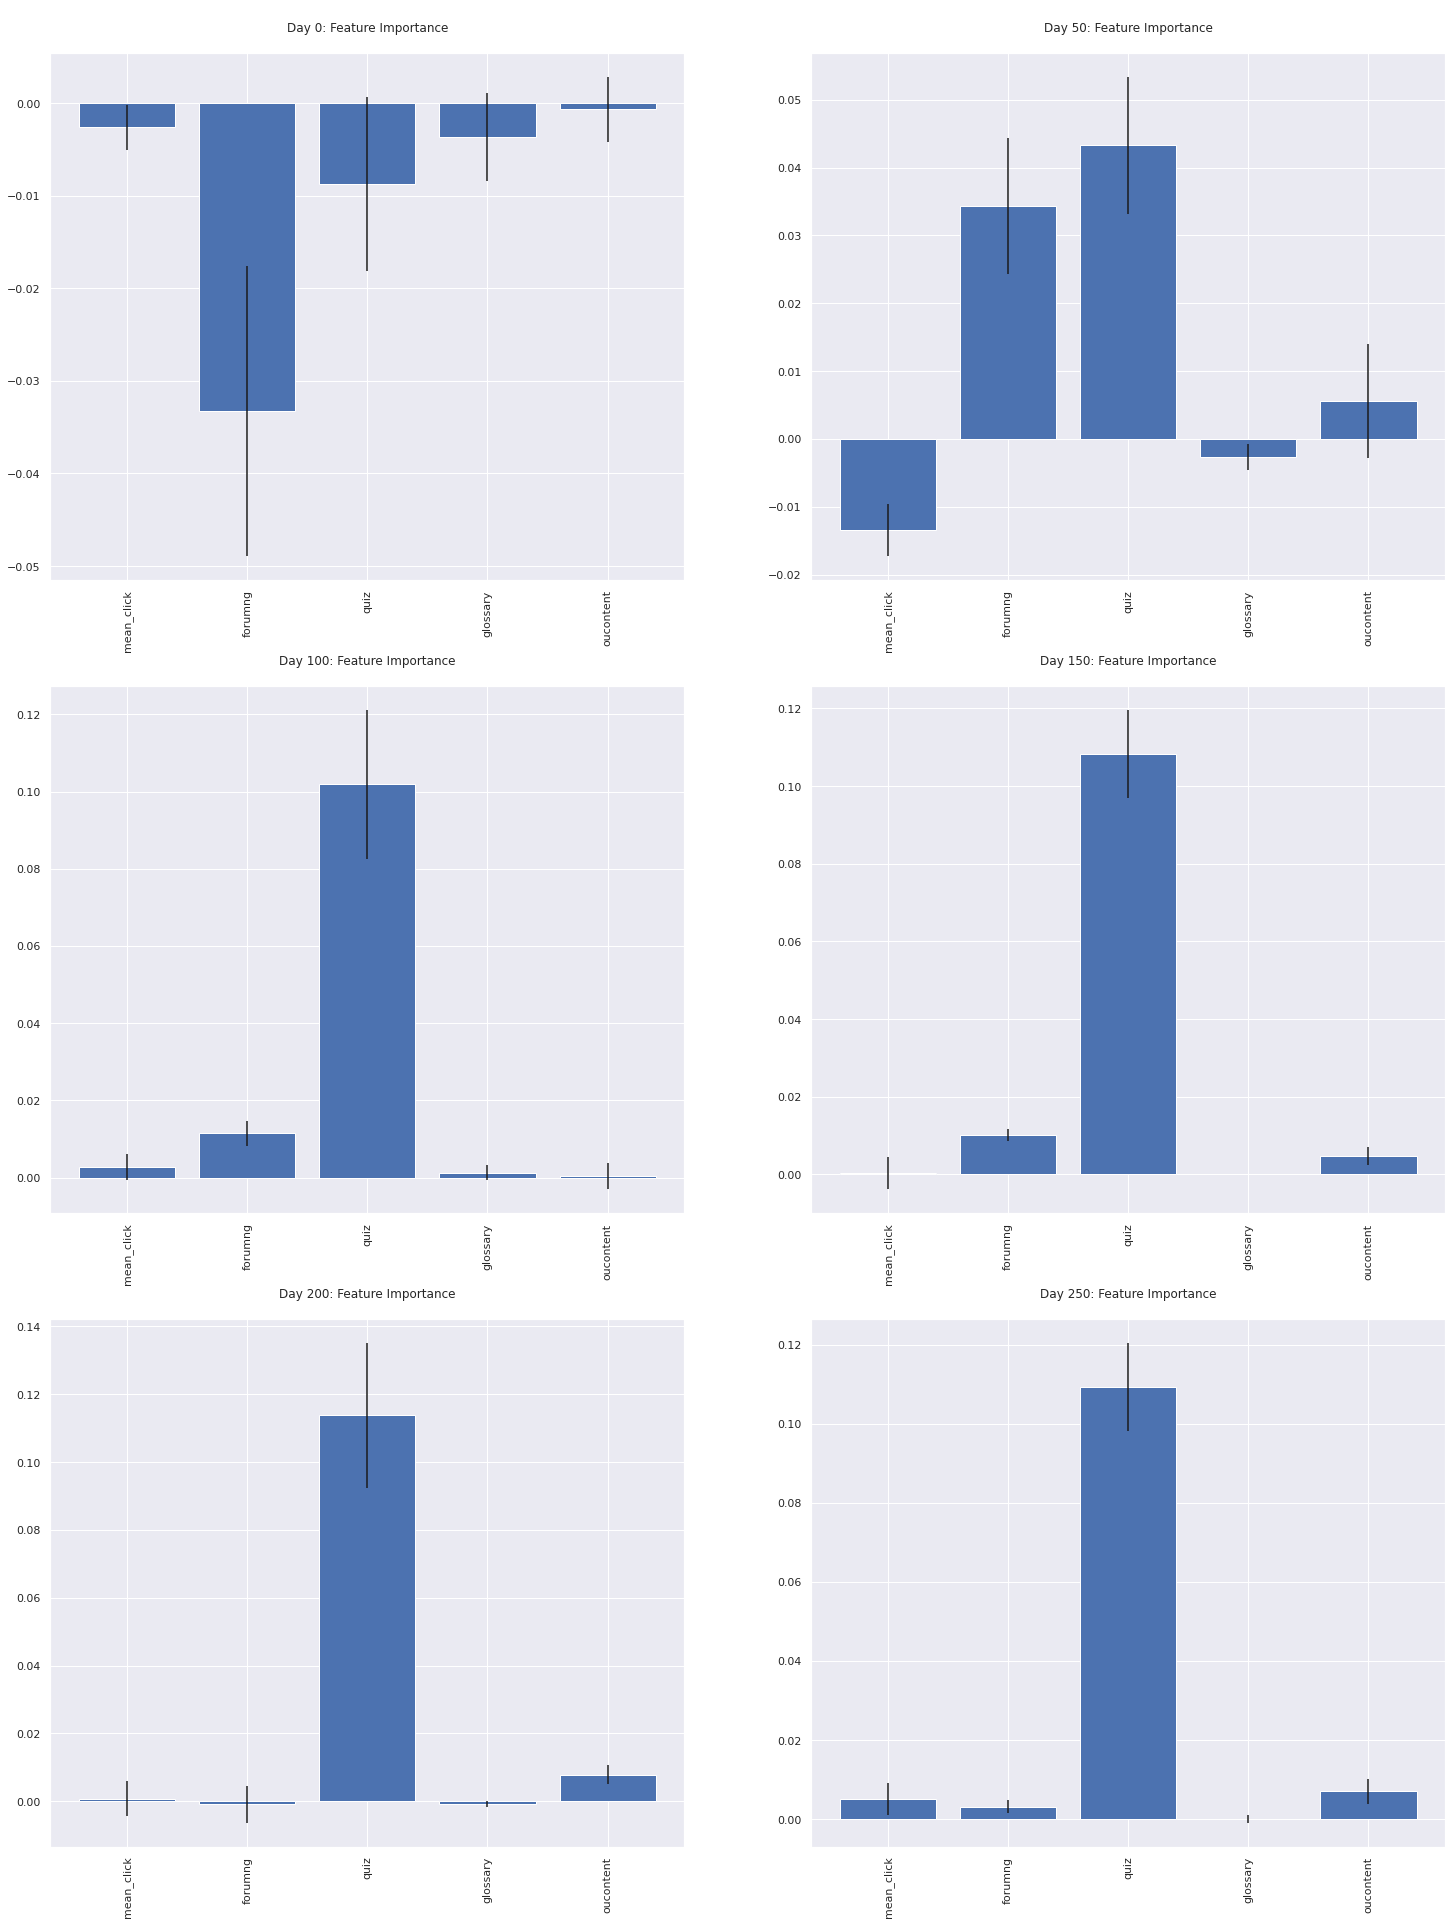

In [ ]:
plot_feature_importance(learning_behiviour_features_ab)

##### Plot results overview

In [ ]:
learning_behaviour_classifier_results = [learning_behaviour_results_du, learning_behaviour_results_nb, learning_behaviour_results_lr, learning_behaviour_results_lrw, learning_behaviour_results_rf, learning_behaviour_results_ab]
learning_behaviour_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

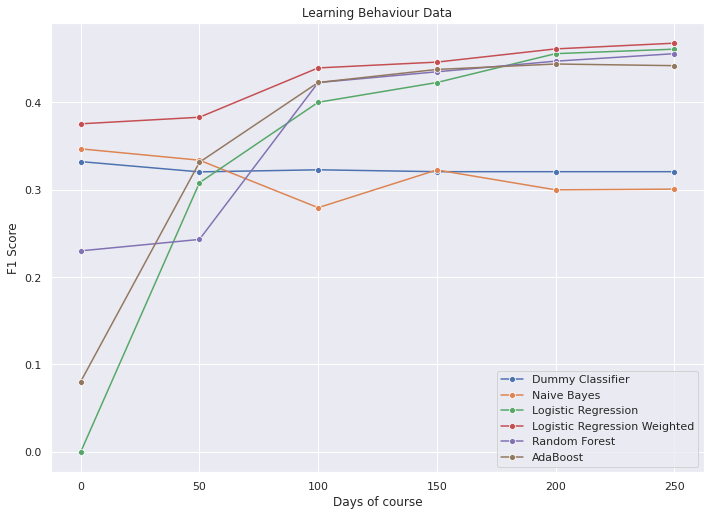

In [ ]:
plot_days_compare(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

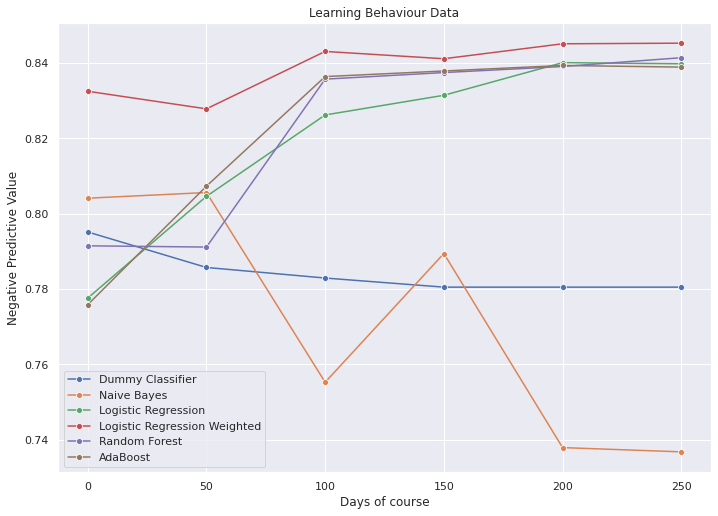

In [ ]:
plot_days_compare_npv(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

#### Performance data

##### Prepare data for prediction

In [ ]:
performance_df = {}
for i in list(df.keys())[1:]:
  performance_df[i] = split_dataframe_by_data_type(df[i], ['performance'], include_final_result=True)

In [ ]:
performance_df[250]

code_presentation  id_student  weighted_score      score  final_result
0                2013B       23629          17.020  82.500000             1
1                2013B       25107          61.361  77.363636             0
2                2013B       29144          53.679  73.222222             1
3                2013B       31663          64.792  79.272727             0
4                2013B       34229          65.862  88.000000             0
...                ...         ...             ...        ...           ...
5130             2014J     2688945          68.272  74.400000             0
5131             2014J     2692969          70.135  77.000000             0
5132             2014J     2694919          66.767  73.400000             0
5133             2014J     2698577          56.122  64.400000             1
5134             2014J     2698588          92.862  92.400000             0

[5135 rows x 5 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(performance_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')


In [ ]:
X_train[50]

weighted_score     score
1126        0.939652  0.932642
1127        0.669457  0.652850
1128        0.770082  0.787565
1129        0.756087  0.782383
1130        0.771567  0.751295
...              ...       ...
2588        0.105576  0.476684
2589        0.794519  0.803109
2590        0.899149  0.880829
2591        0.620584  0.621762
2592        0.592008  0.544041

[1467 rows x 2 columns]

###### Undersampling

In [ ]:
Y_train[50].value_counts()

0    1053
1     414
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in list(df.keys())[1:]:

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 50
Original dataset shape: Counter({0: 1053, 1: 414})
Resample dataset shape Counter({0: 414, 1: 414})
Sampling for day 100
Original dataset shape: Counter({0: 1060, 1: 417})
Resample dataset shape Counter({0: 417, 1: 417})
Sampling for day 150
Original dataset shape: Counter({0: 1063, 1: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 200
Original dataset shape: Counter({0: 1063, 1: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 250
Original dataset shape: Counter({0: 1064, 1: 421})
Resample dataset shape Counter({0: 421, 1: 421})


##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

performance_results_du = []
performance_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_du.append([acc, f1, prec, recall, conf])
  performance_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.434
Best parameters set:
Accuracy: 0.5082304526748971, F1 Score: 0.32037914691943126, Precision: 0.23150684931506849, Recall: 0.52


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.453
Best parameters set:
Accuracy: 0.508130081300813, F1 Score: 0.32276119402985076, Precision: 0.23410013531799728, Recall: 0.5195195195195195


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.469
Best parameters set:
Accuracy: 0.5064319566689235, F1 Score: 0.320596458527493, Precision: 0.2327469553450609, Recall: 0.5149700598802395


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.469
Best parameter

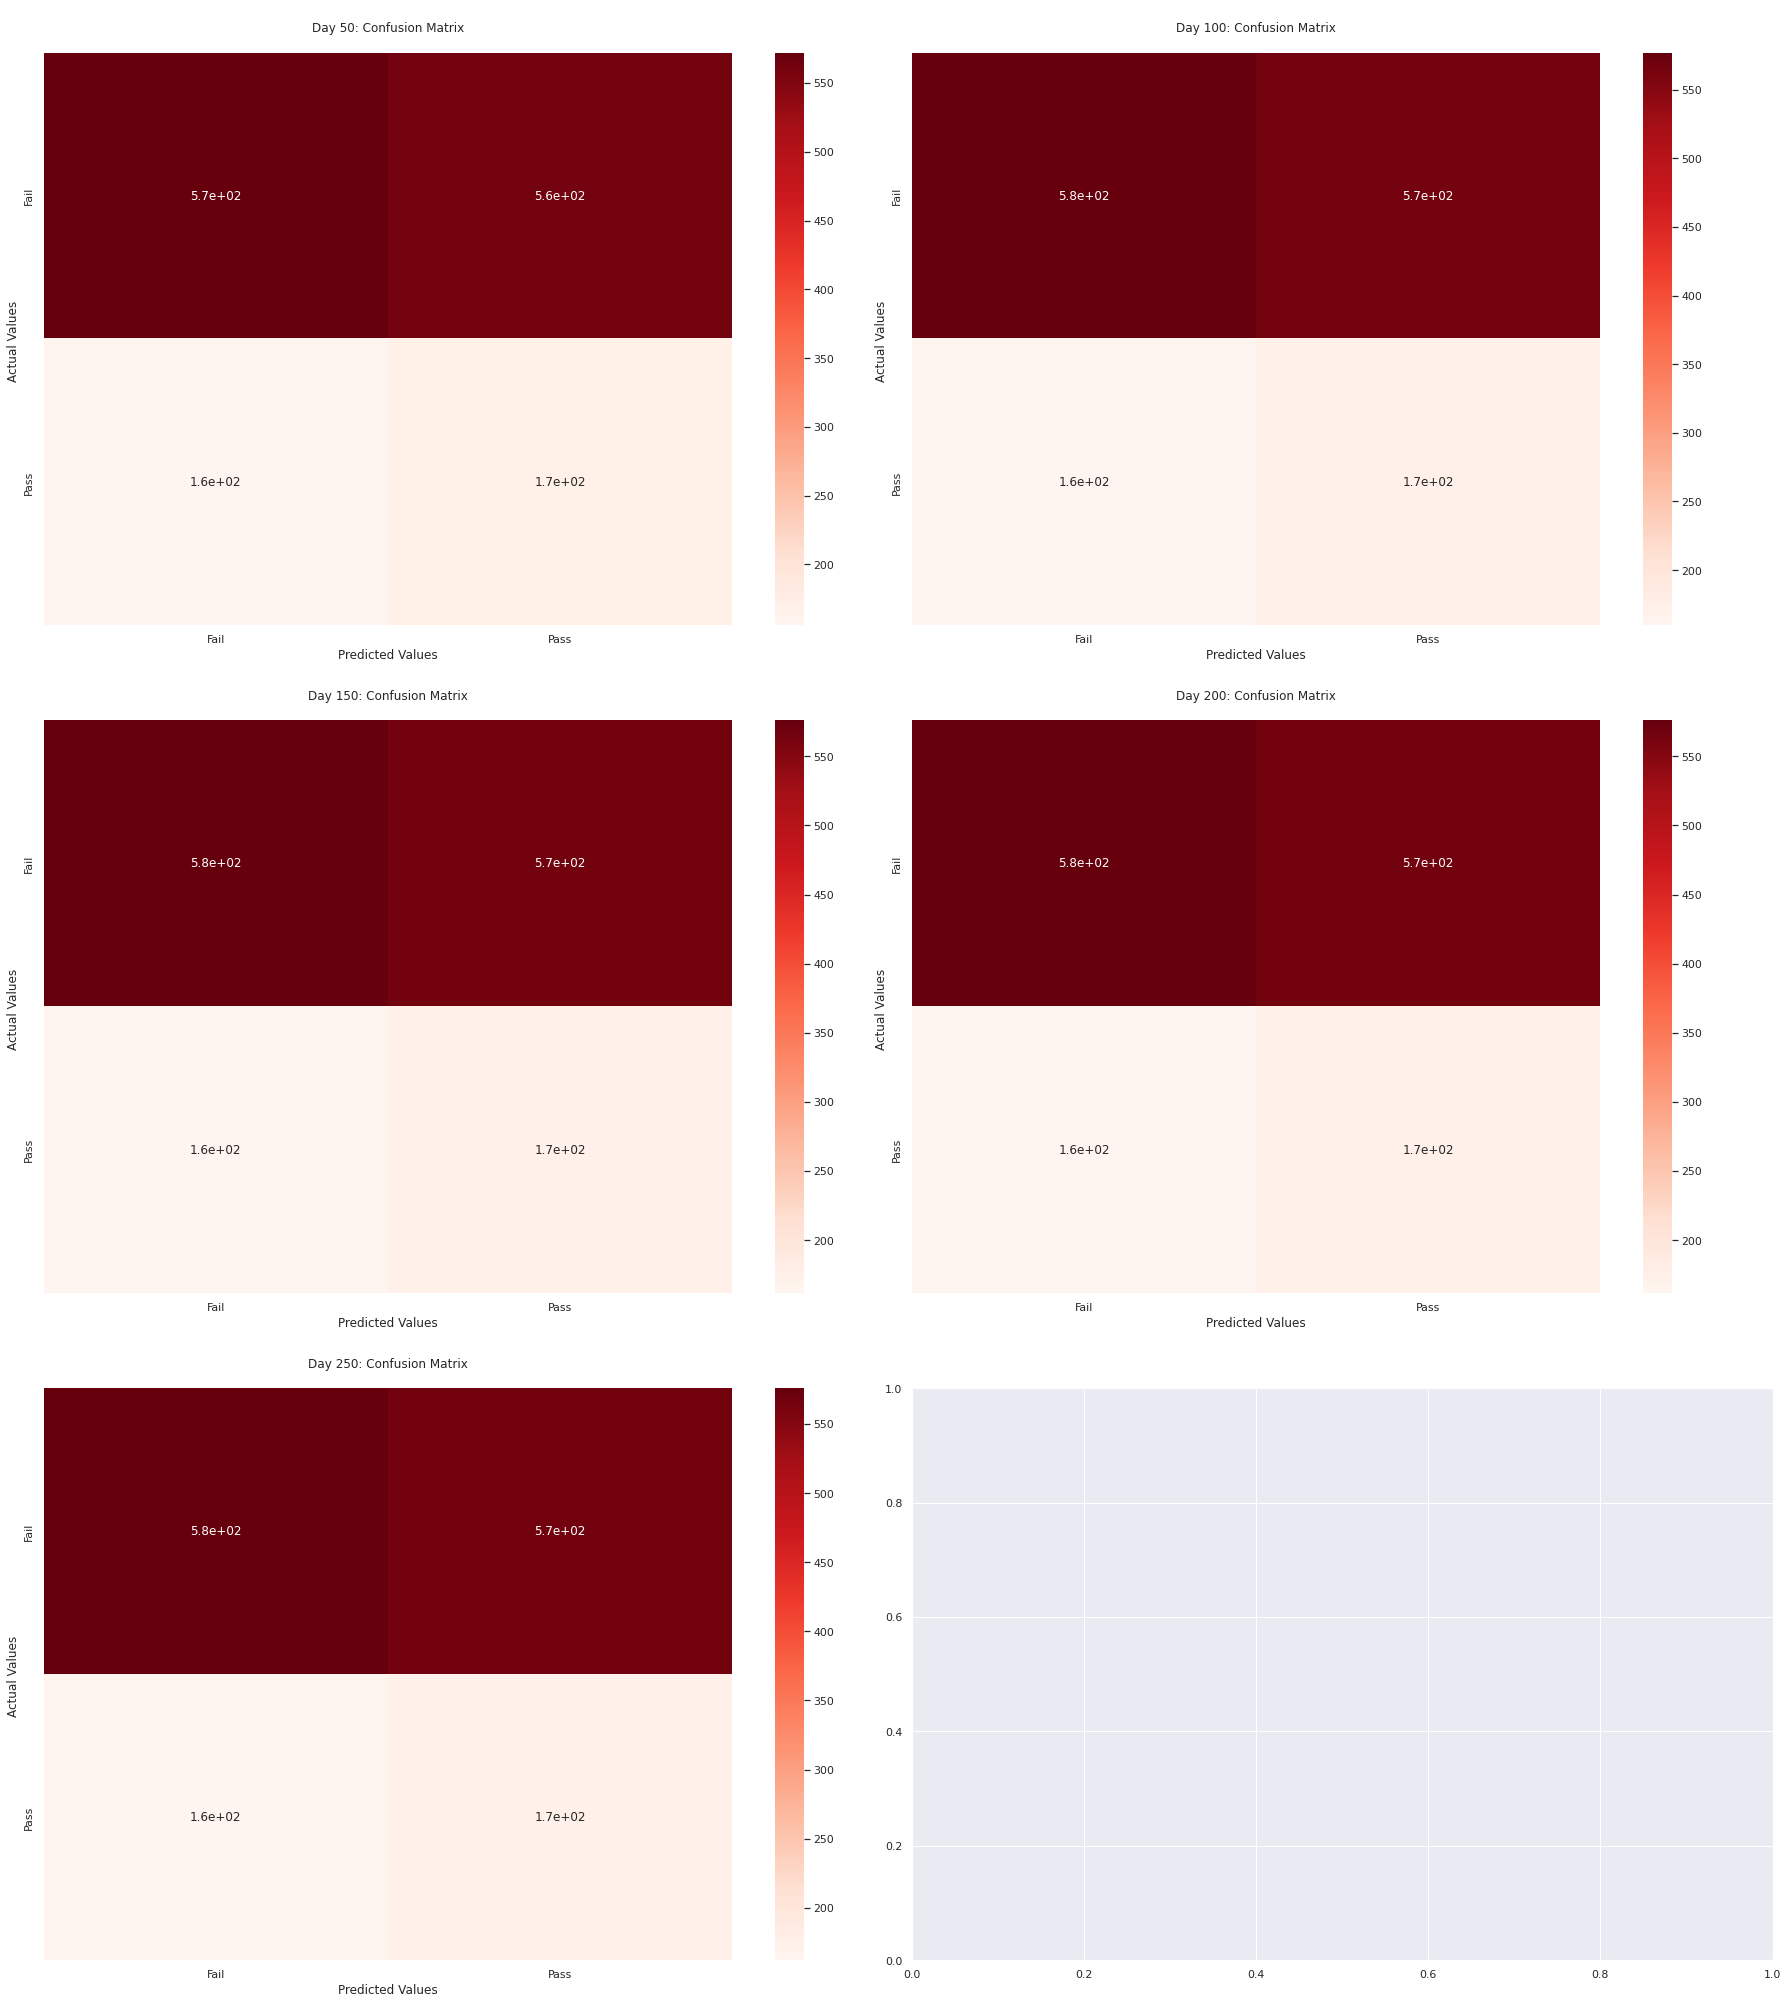

In [ ]:
plot_confusion_matrix(performance_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

performance_results_nb = []
performance_features_nb = []

performance_predict_proba_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])

  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_nb.append([acc, f1, prec, recall, conf])
  performance_features_nb.append([tuned_model, X_test[i], Y_test[i]])

  performance_predict_proba_nb.append(predictions_proba)

  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.634
Best parameters set:
Accuracy: 0.22633744855967078, F1 Score: 0.3627118644067796, Precision: 0.22214532871972317, Recall: 0.9876923076923076


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.754
Best parameters set:
Accuracy: 0.22560975609756098, F1 Score: 0.3681592039800995, Precision: 0.22560975609756098, Recall: 1.0


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.789
Best parameters set:
Accuracy: 0.4245091401489506, F1 Score: 0.3980169971671388, Precision: 0.2606679035250464, Recall: 0.8413173652694611


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.826
Best paramete

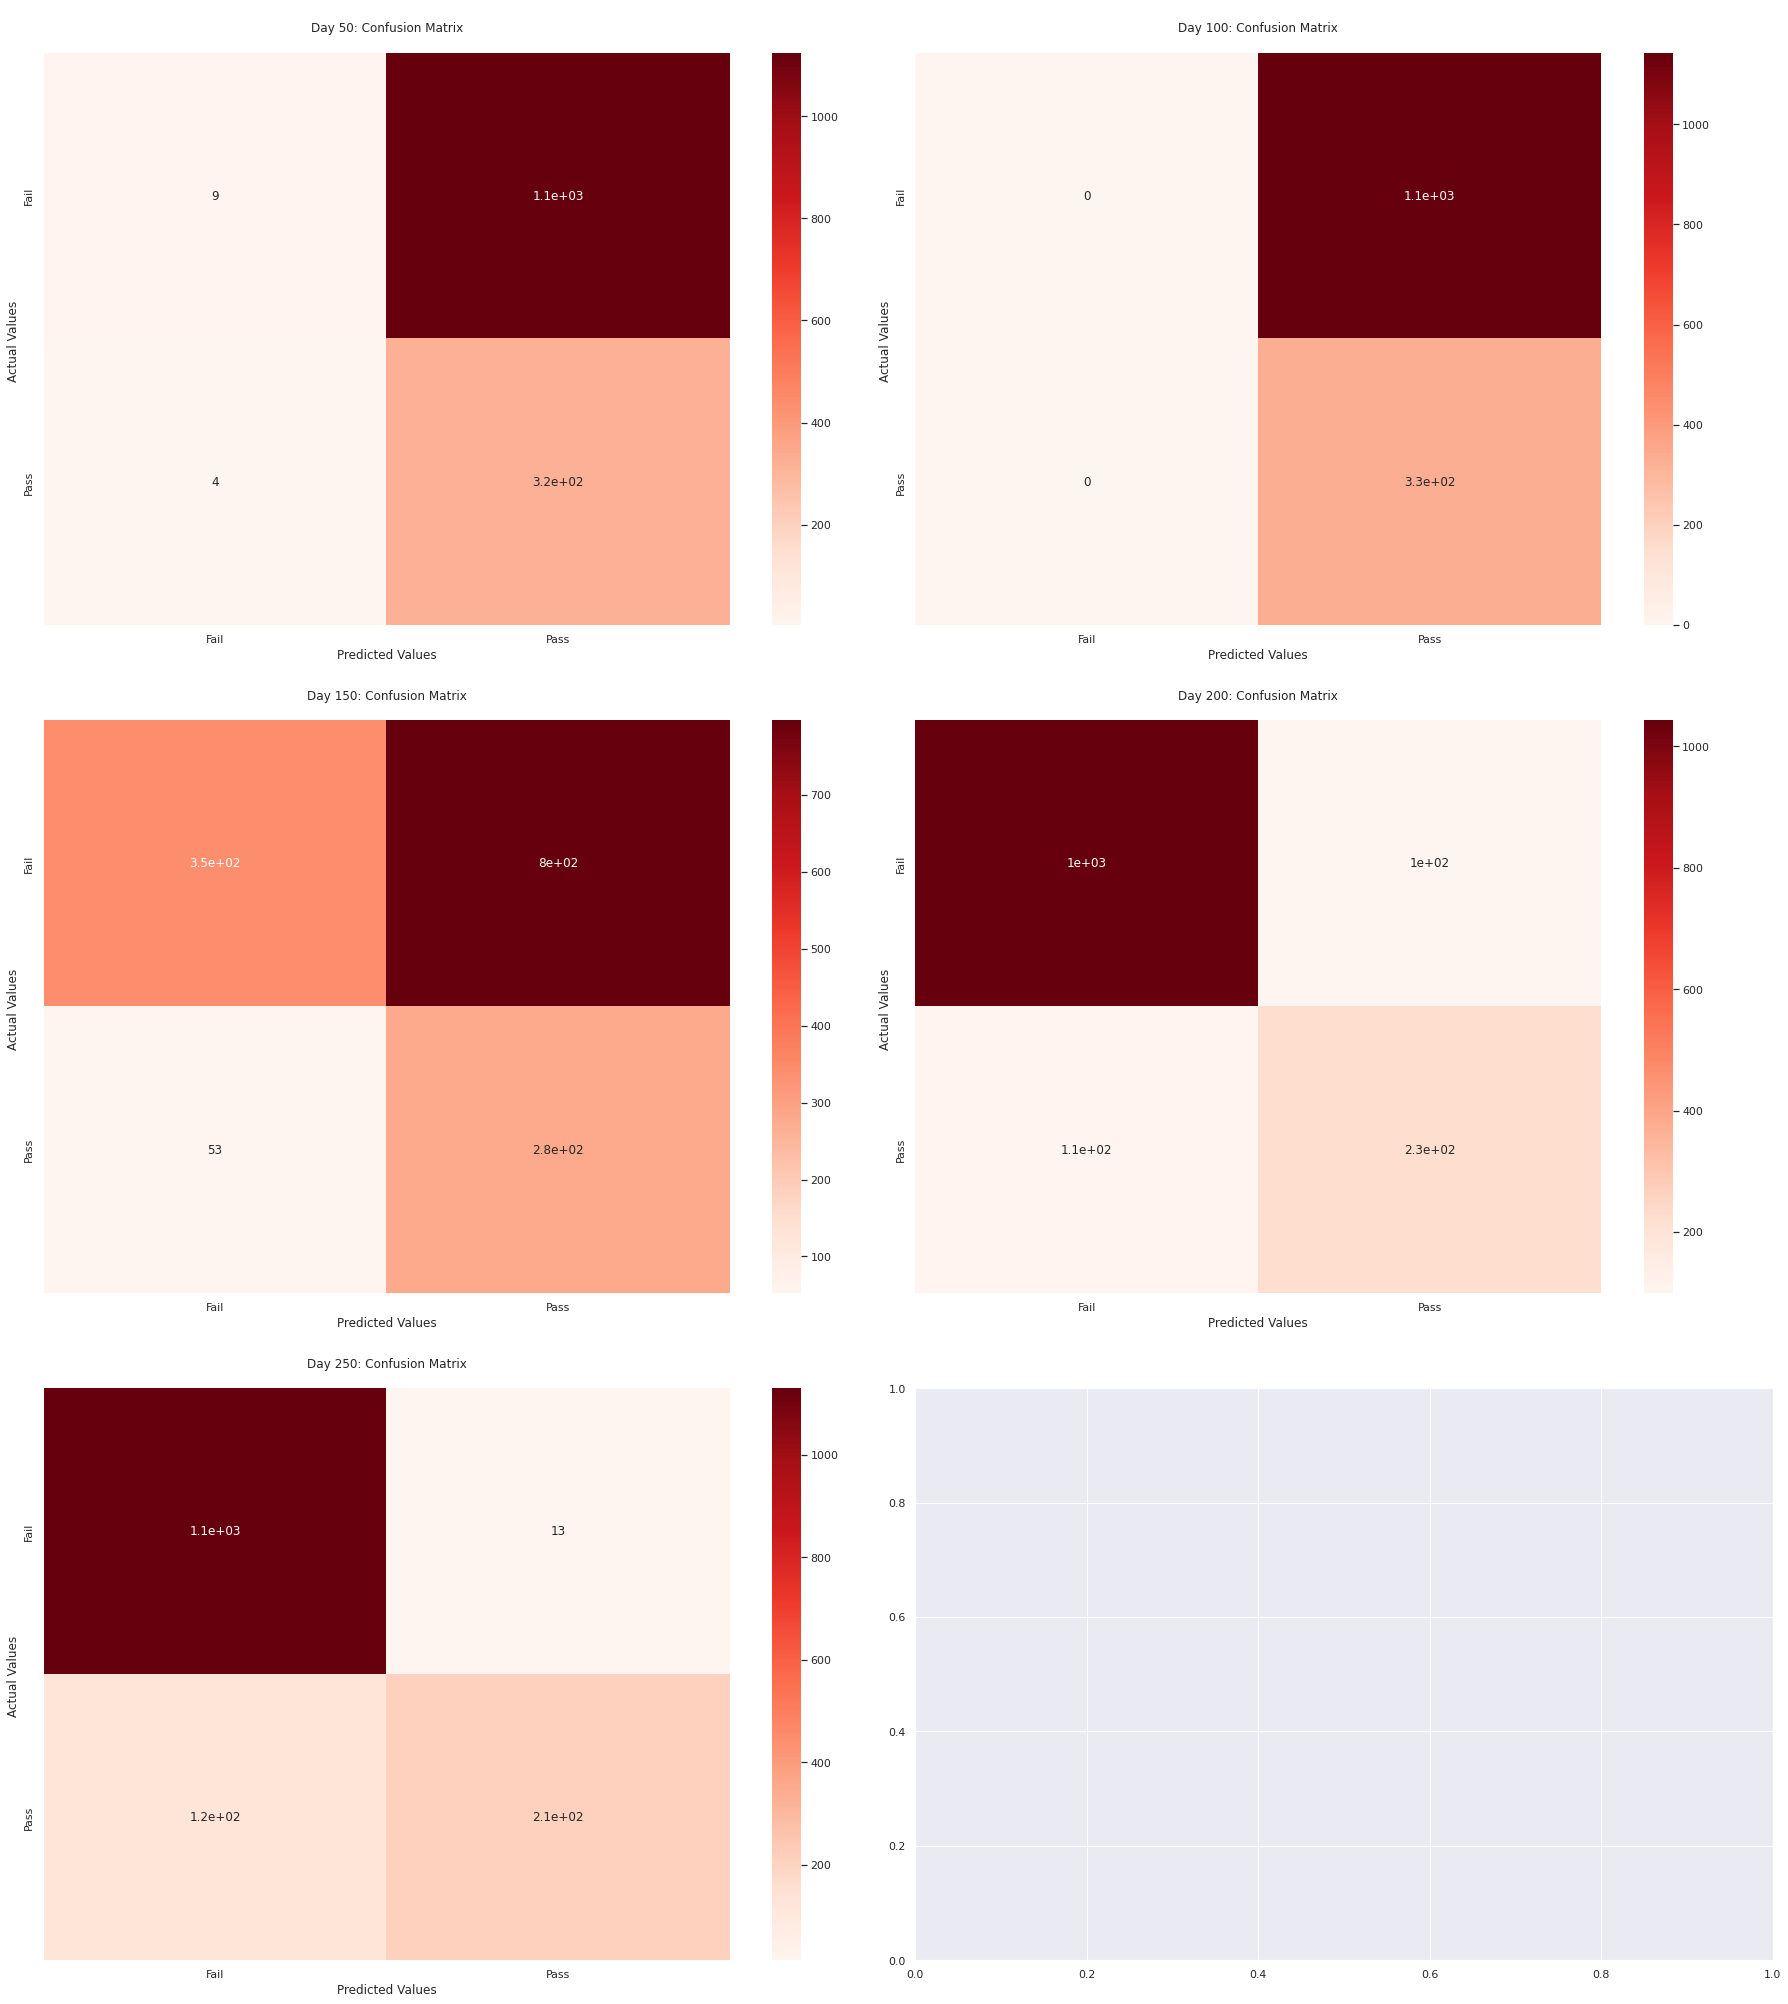

In [ ]:
plot_confusion_matrix(performance_results_nb)

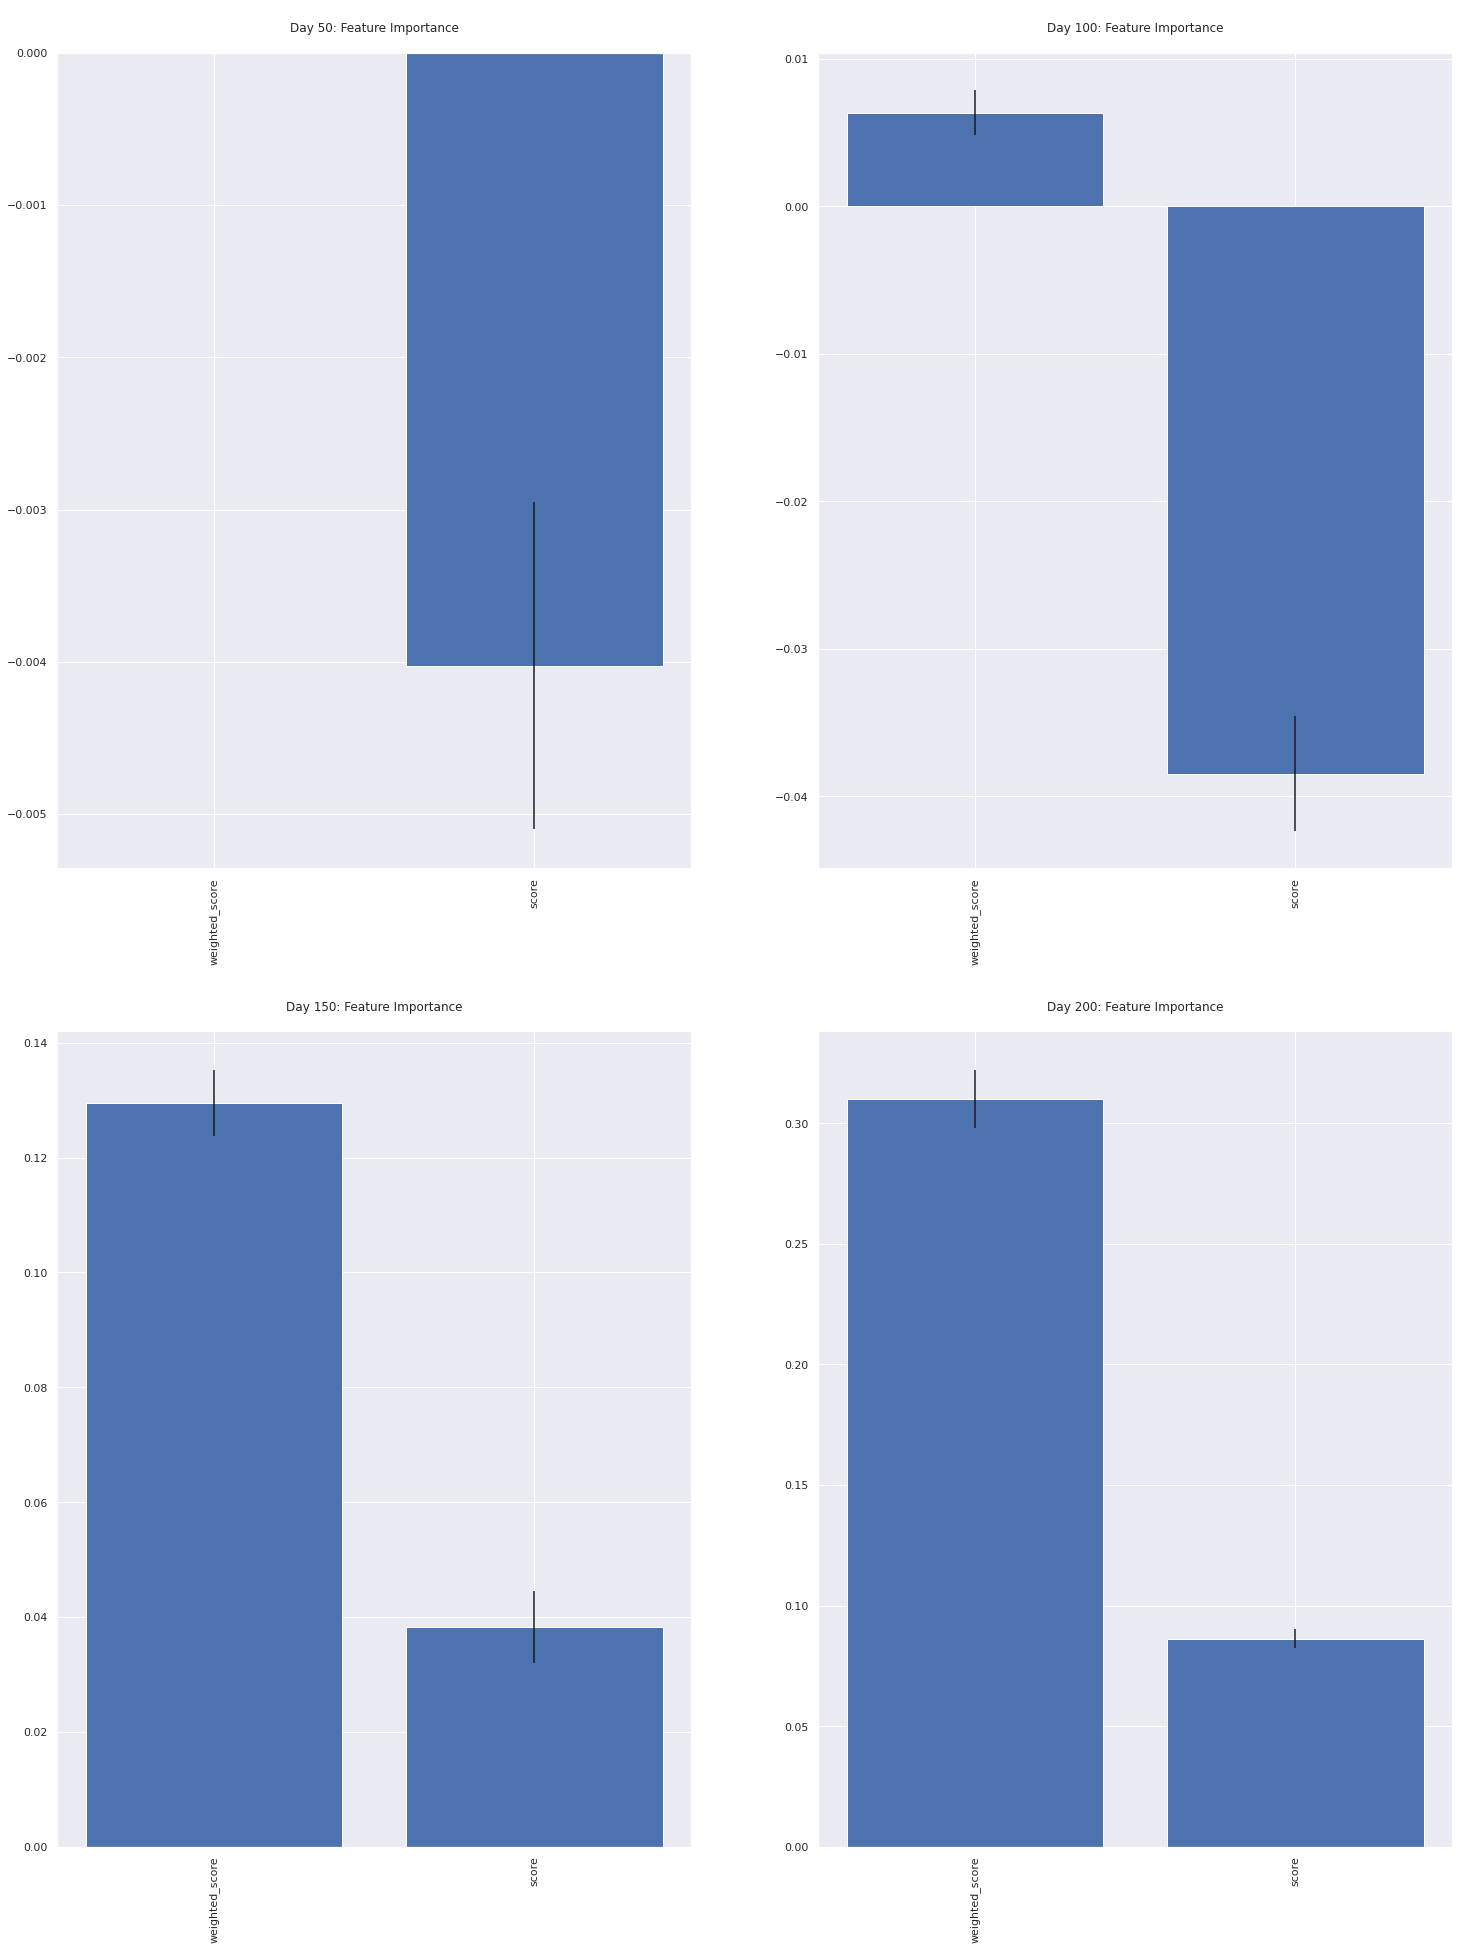

In [ ]:
plot_feature_importance(performance_features_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

performance_results_lr = []
performance_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lr.append([acc, f1, prec, recall, conf])
  performance_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.674
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.22290809327846364, F1 Score: 0.36455412226584405, Precision: 0.22290809327846364, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.782
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.22560975609756098, F1 Score: 0.3681592039800995, Precision: 0.22560975609756098, Recall: 1.0


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.810
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.23019634394041977, F1 Score: 0.3700831024930748, Precision: 0.22705642420122366, Recall: 1.0


Day 200
Performing grid search

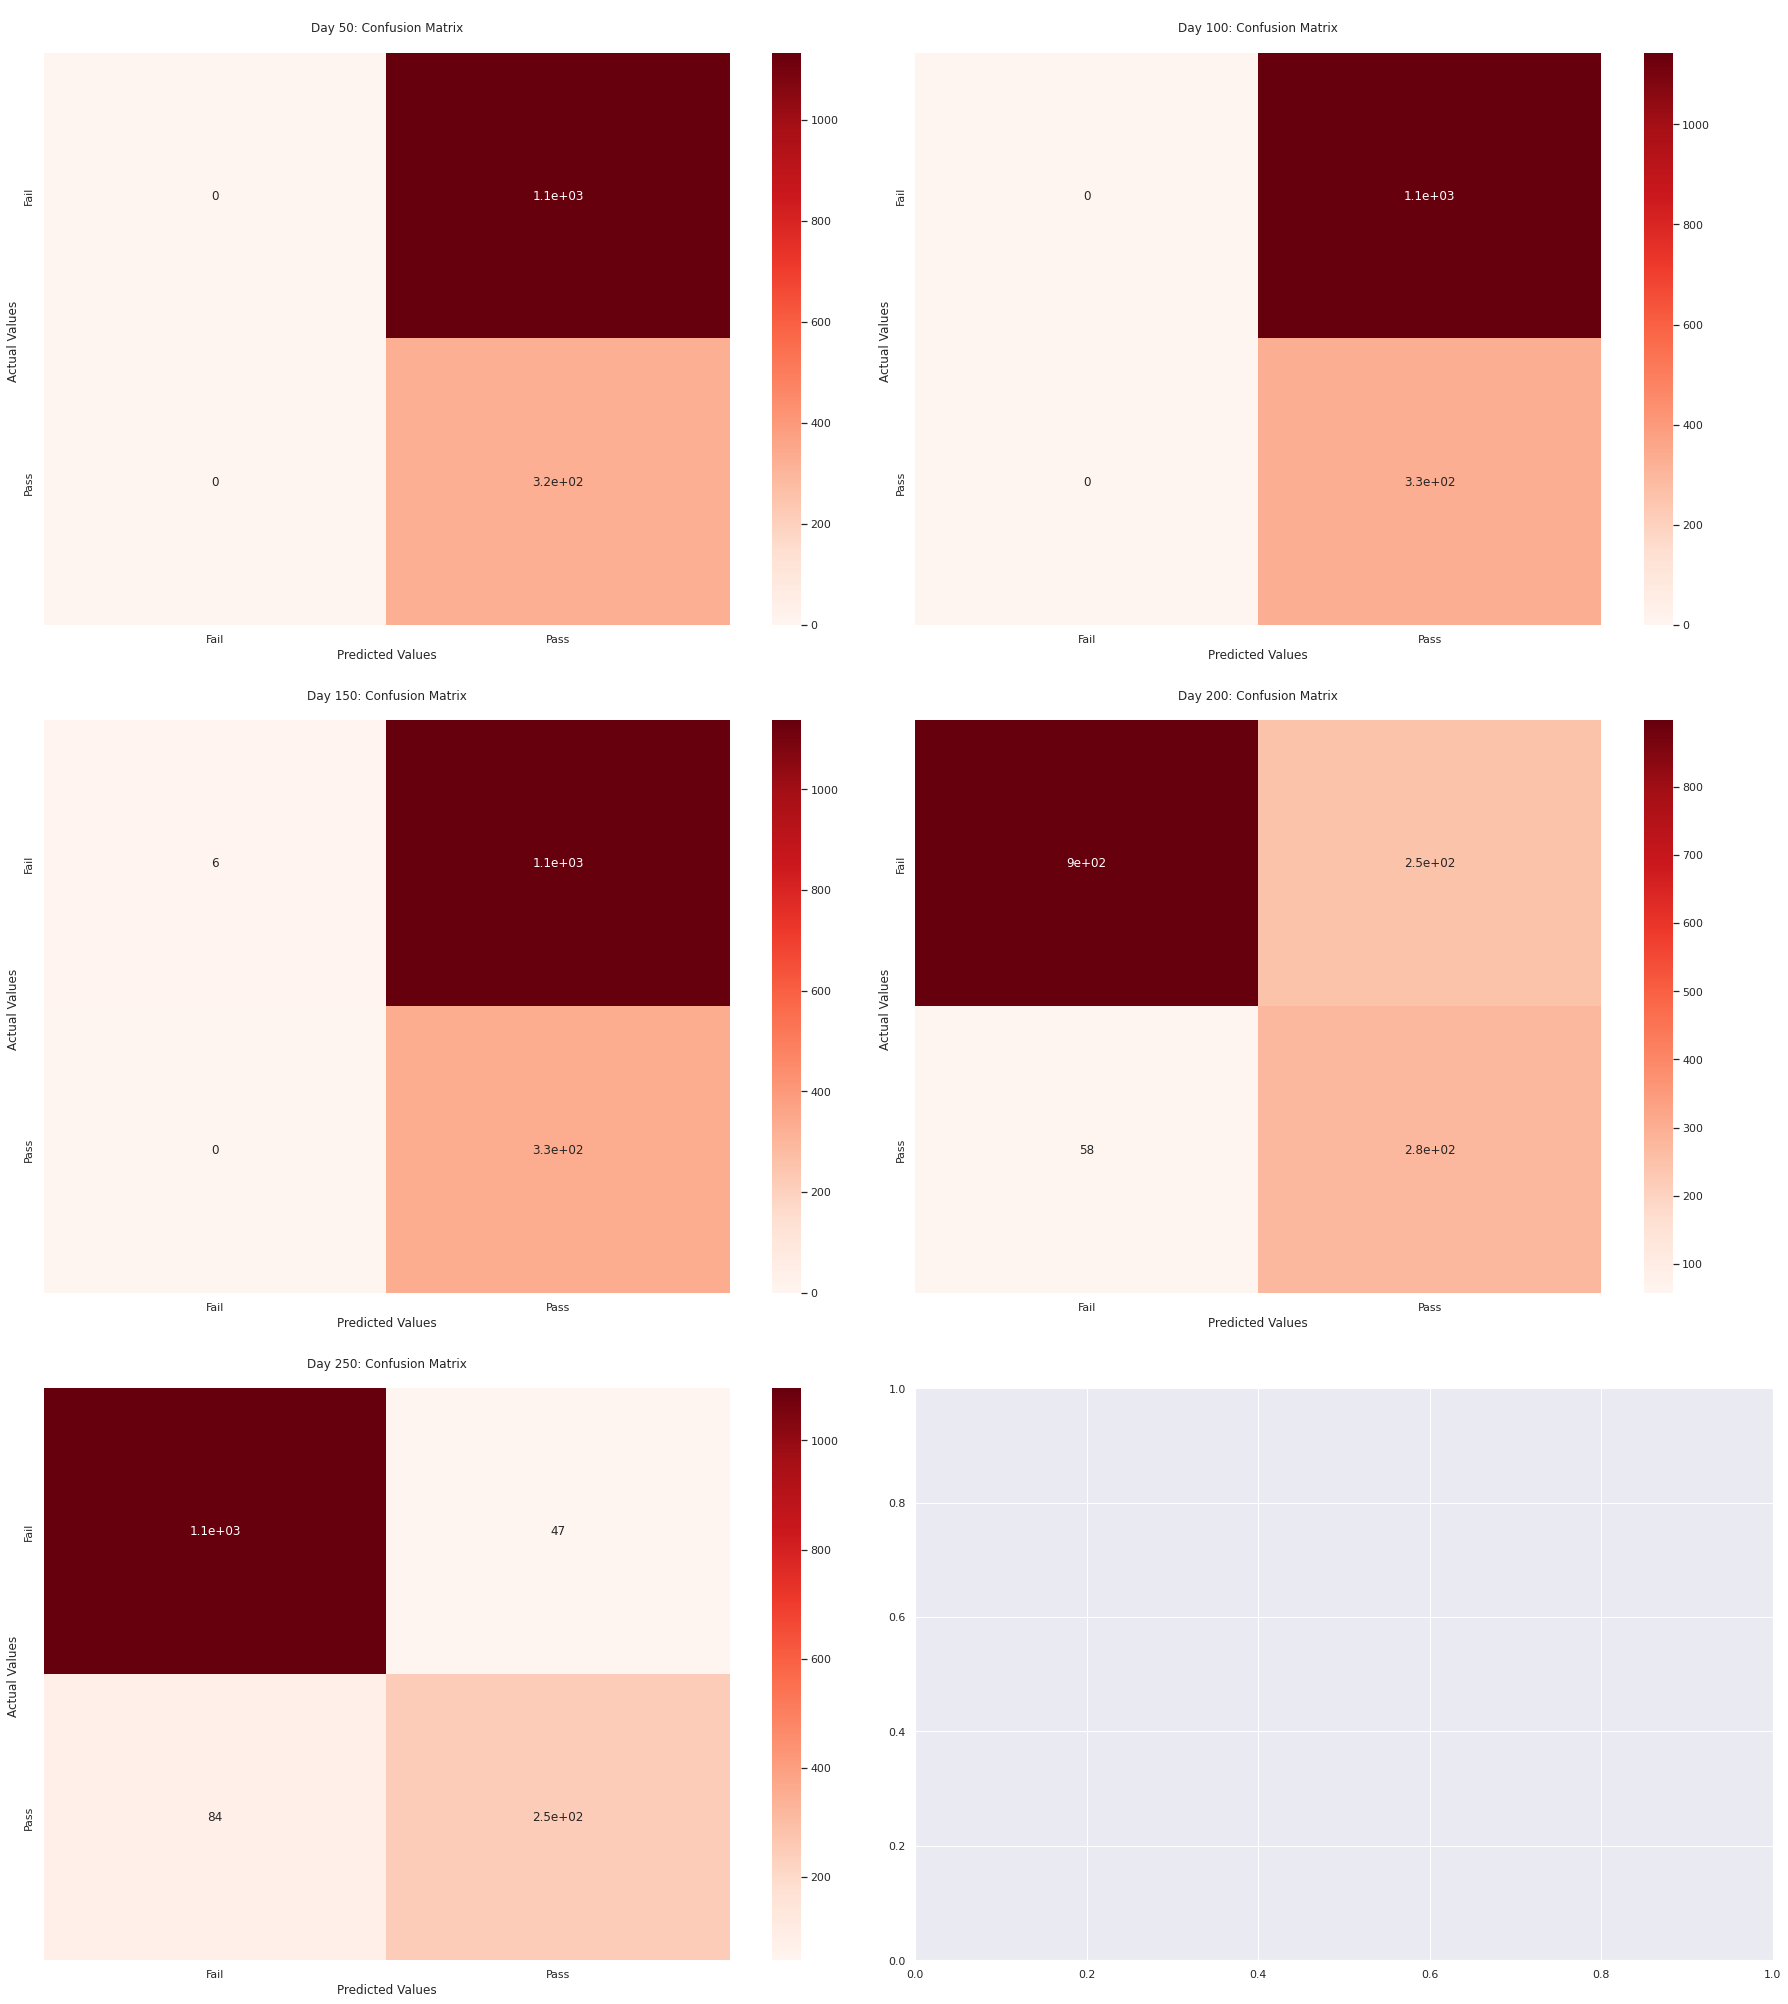

In [ ]:
plot_confusion_matrix(performance_results_lr)

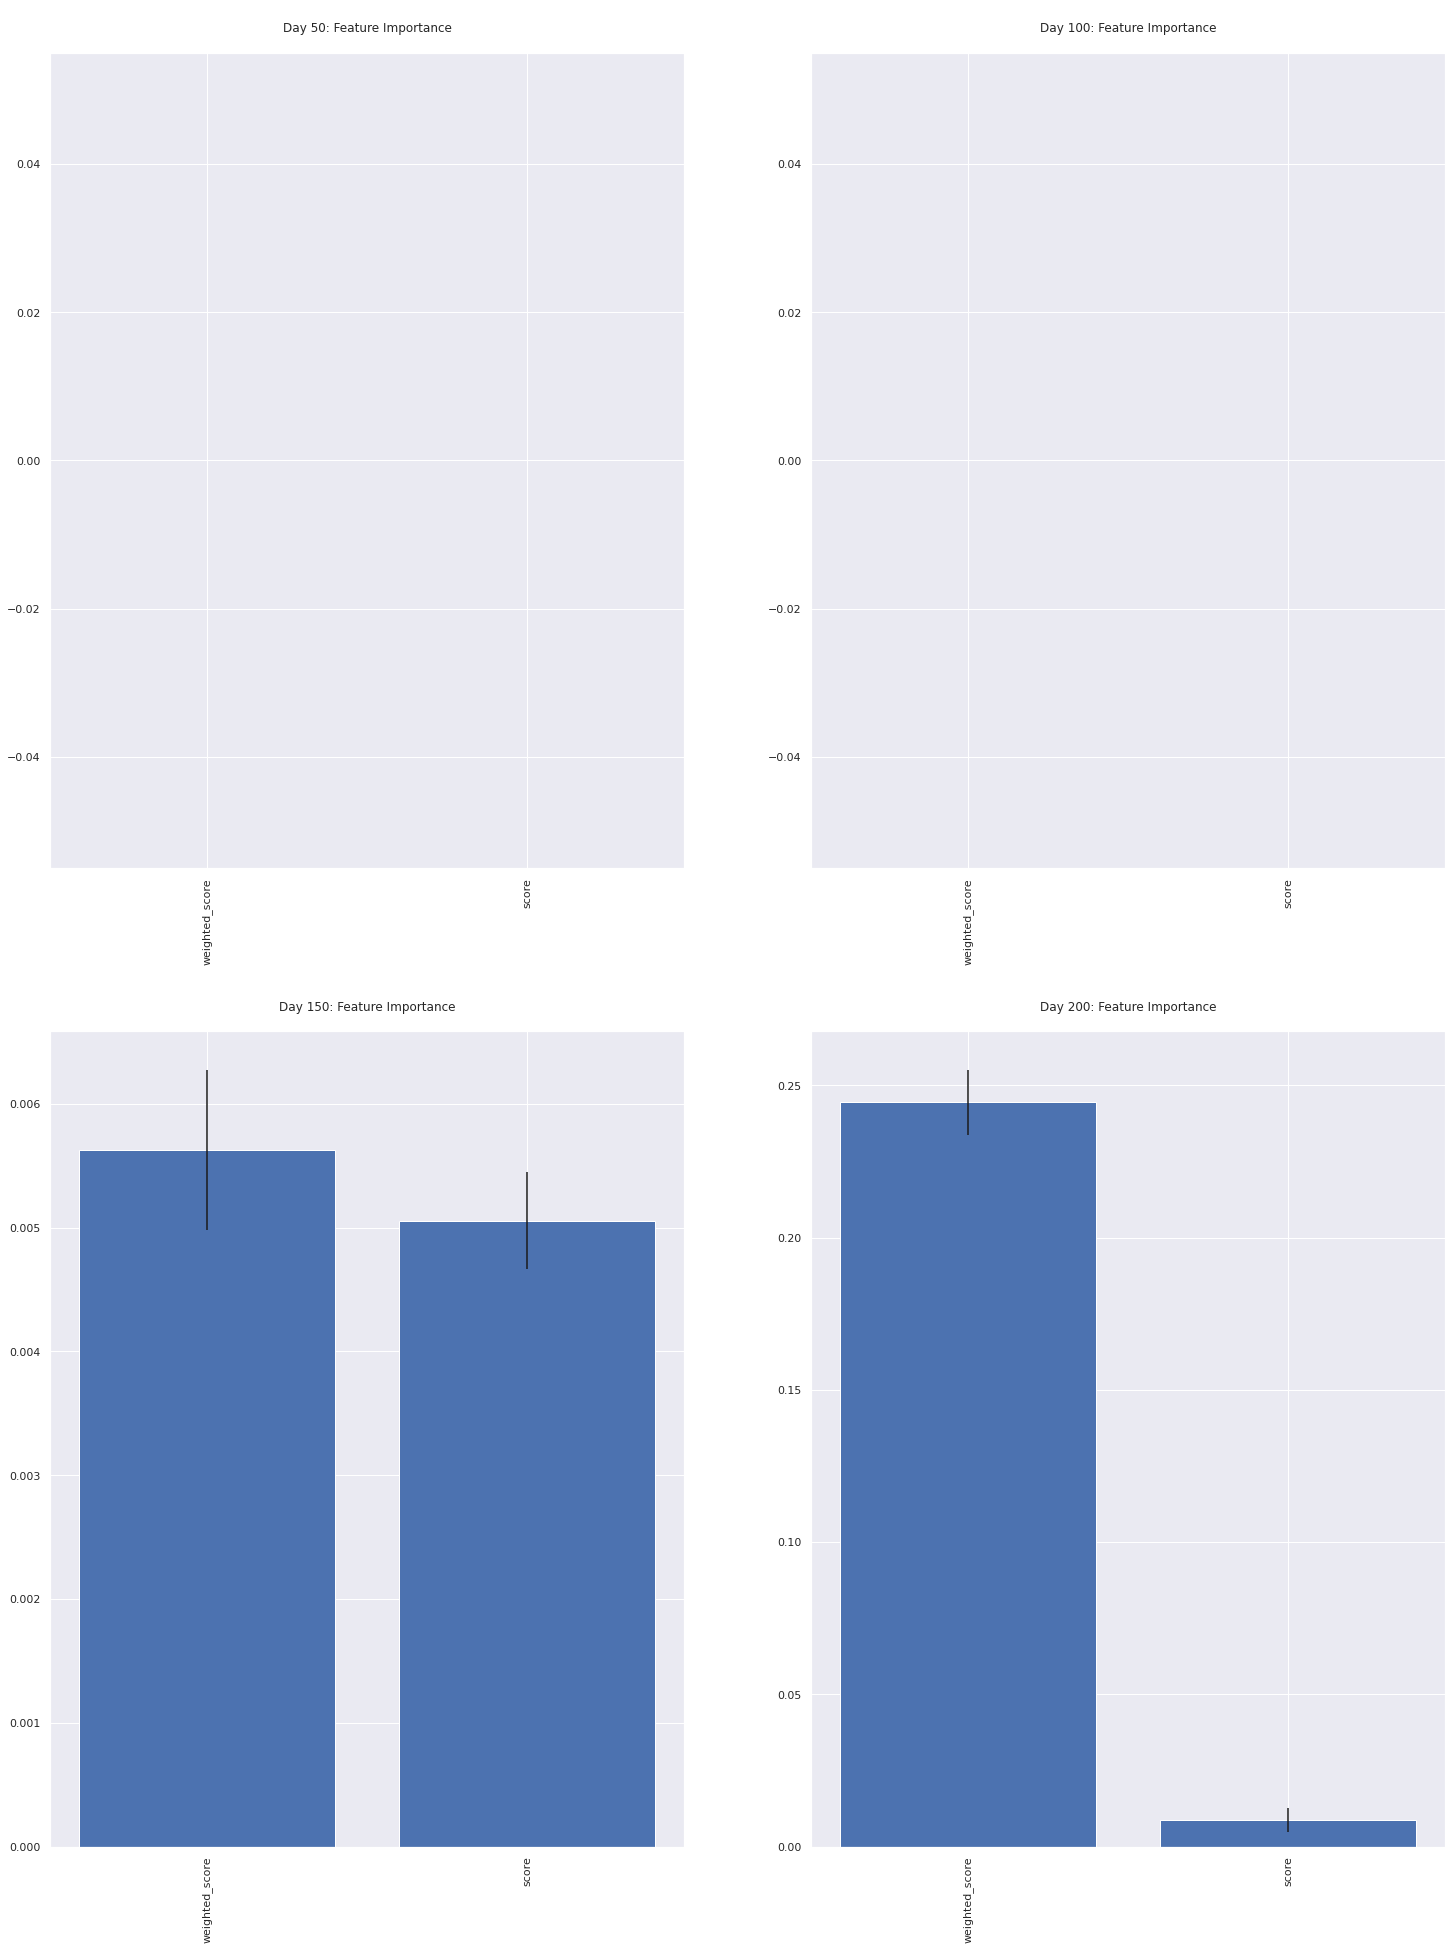

In [ ]:
plot_feature_importance(performance_features_lr)

##### WeightedLogisticRegression

In [ ]:
performance_results_lrw = []
performance_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
  
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lrw.append([acc, f1, prec, recall, conf])
  performance_features_lrw.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.677
Best parameters set:
Accuracy: 0.22290809327846364, F1 Score: 0.36455412226584405, Precision: 0.22290809327846364, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.763
Best parameters set:
Accuracy: 0.22560975609756098, F1 Score: 0.3681592039800995, Precision: 0.22560975609756098, Recall: 1.0


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.799
Best parameters set:
Accuracy: 0.22613405551794177, F1 Score: 0.36885698509110987, Precision: 0.22613405551794177, Recall: 1.0


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.822
Best parameters set:
Accuracy: 0.522681

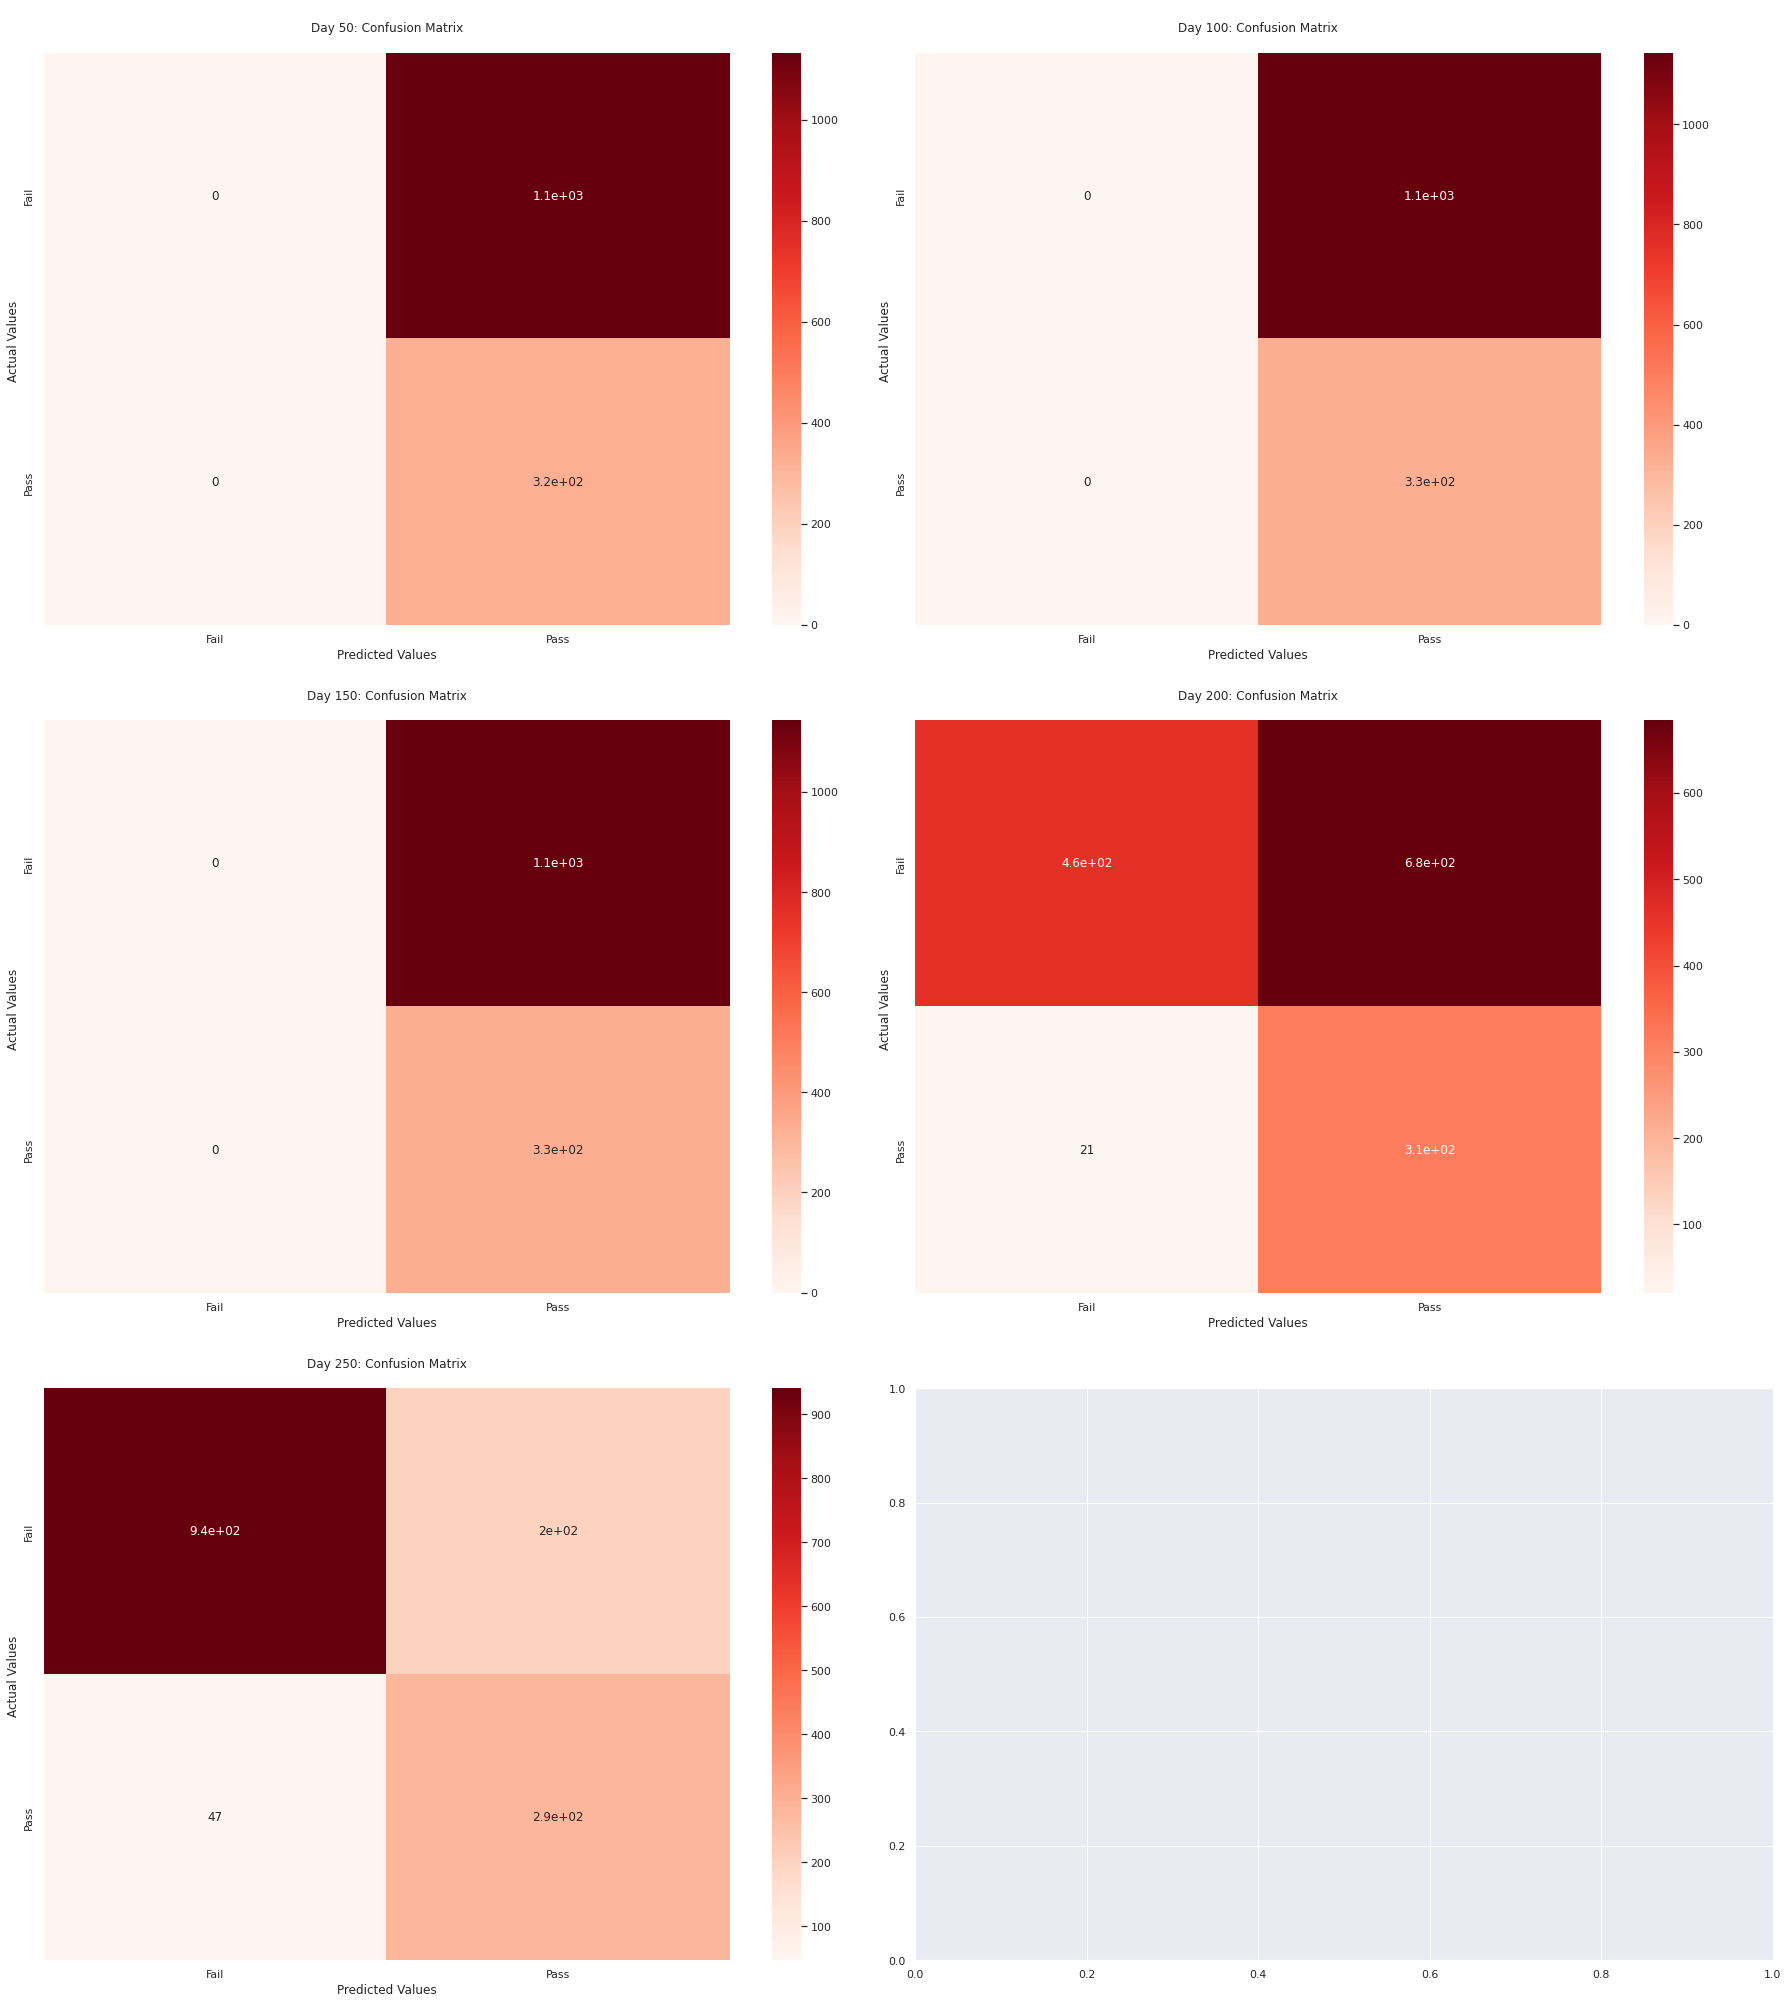

In [ ]:
plot_confusion_matrix(performance_results_lrw)

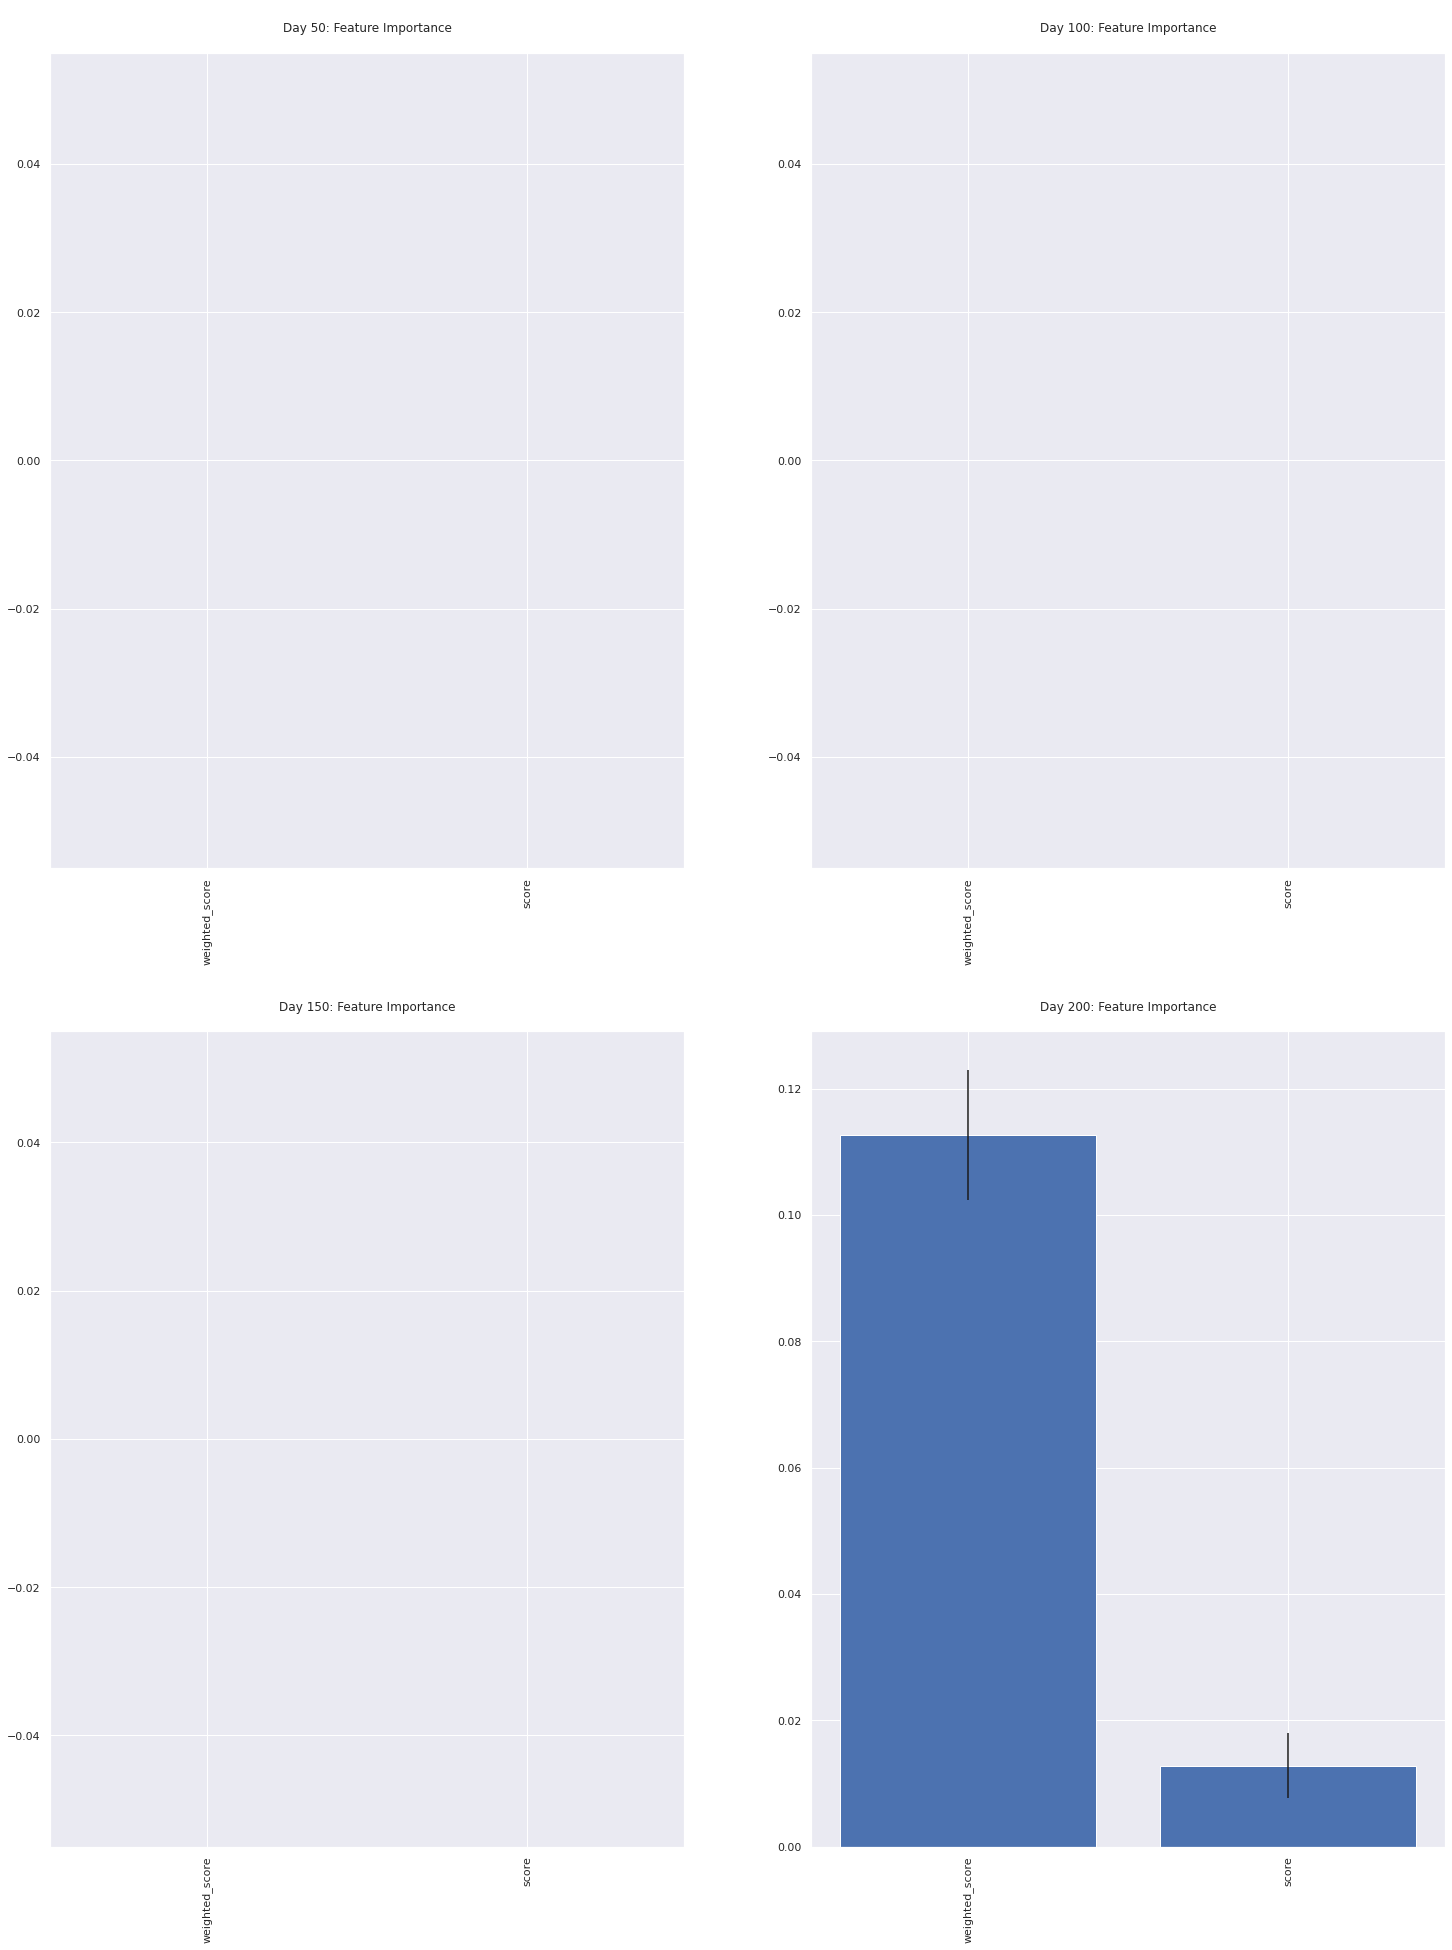

In [ ]:
plot_feature_importance(performance_features_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

performance_results_rf = []
performance_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_rf.append([acc, f1, prec, recall, conf])
  performance_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.636
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.2222222222222222, F1 Score: 0.3636363636363636, Precision: 0.22237474262182566, Recall: 0.9969230769230769


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.745
Best parameters set:
	clf__n_estimators: 140
Accuracy: 0.22493224932249323, F1 Score: 0.3672566371681416, Precision: 0.22508474576271187, Recall: 0.996996996996997


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.803
Best parameters set:
	clf__n_estim

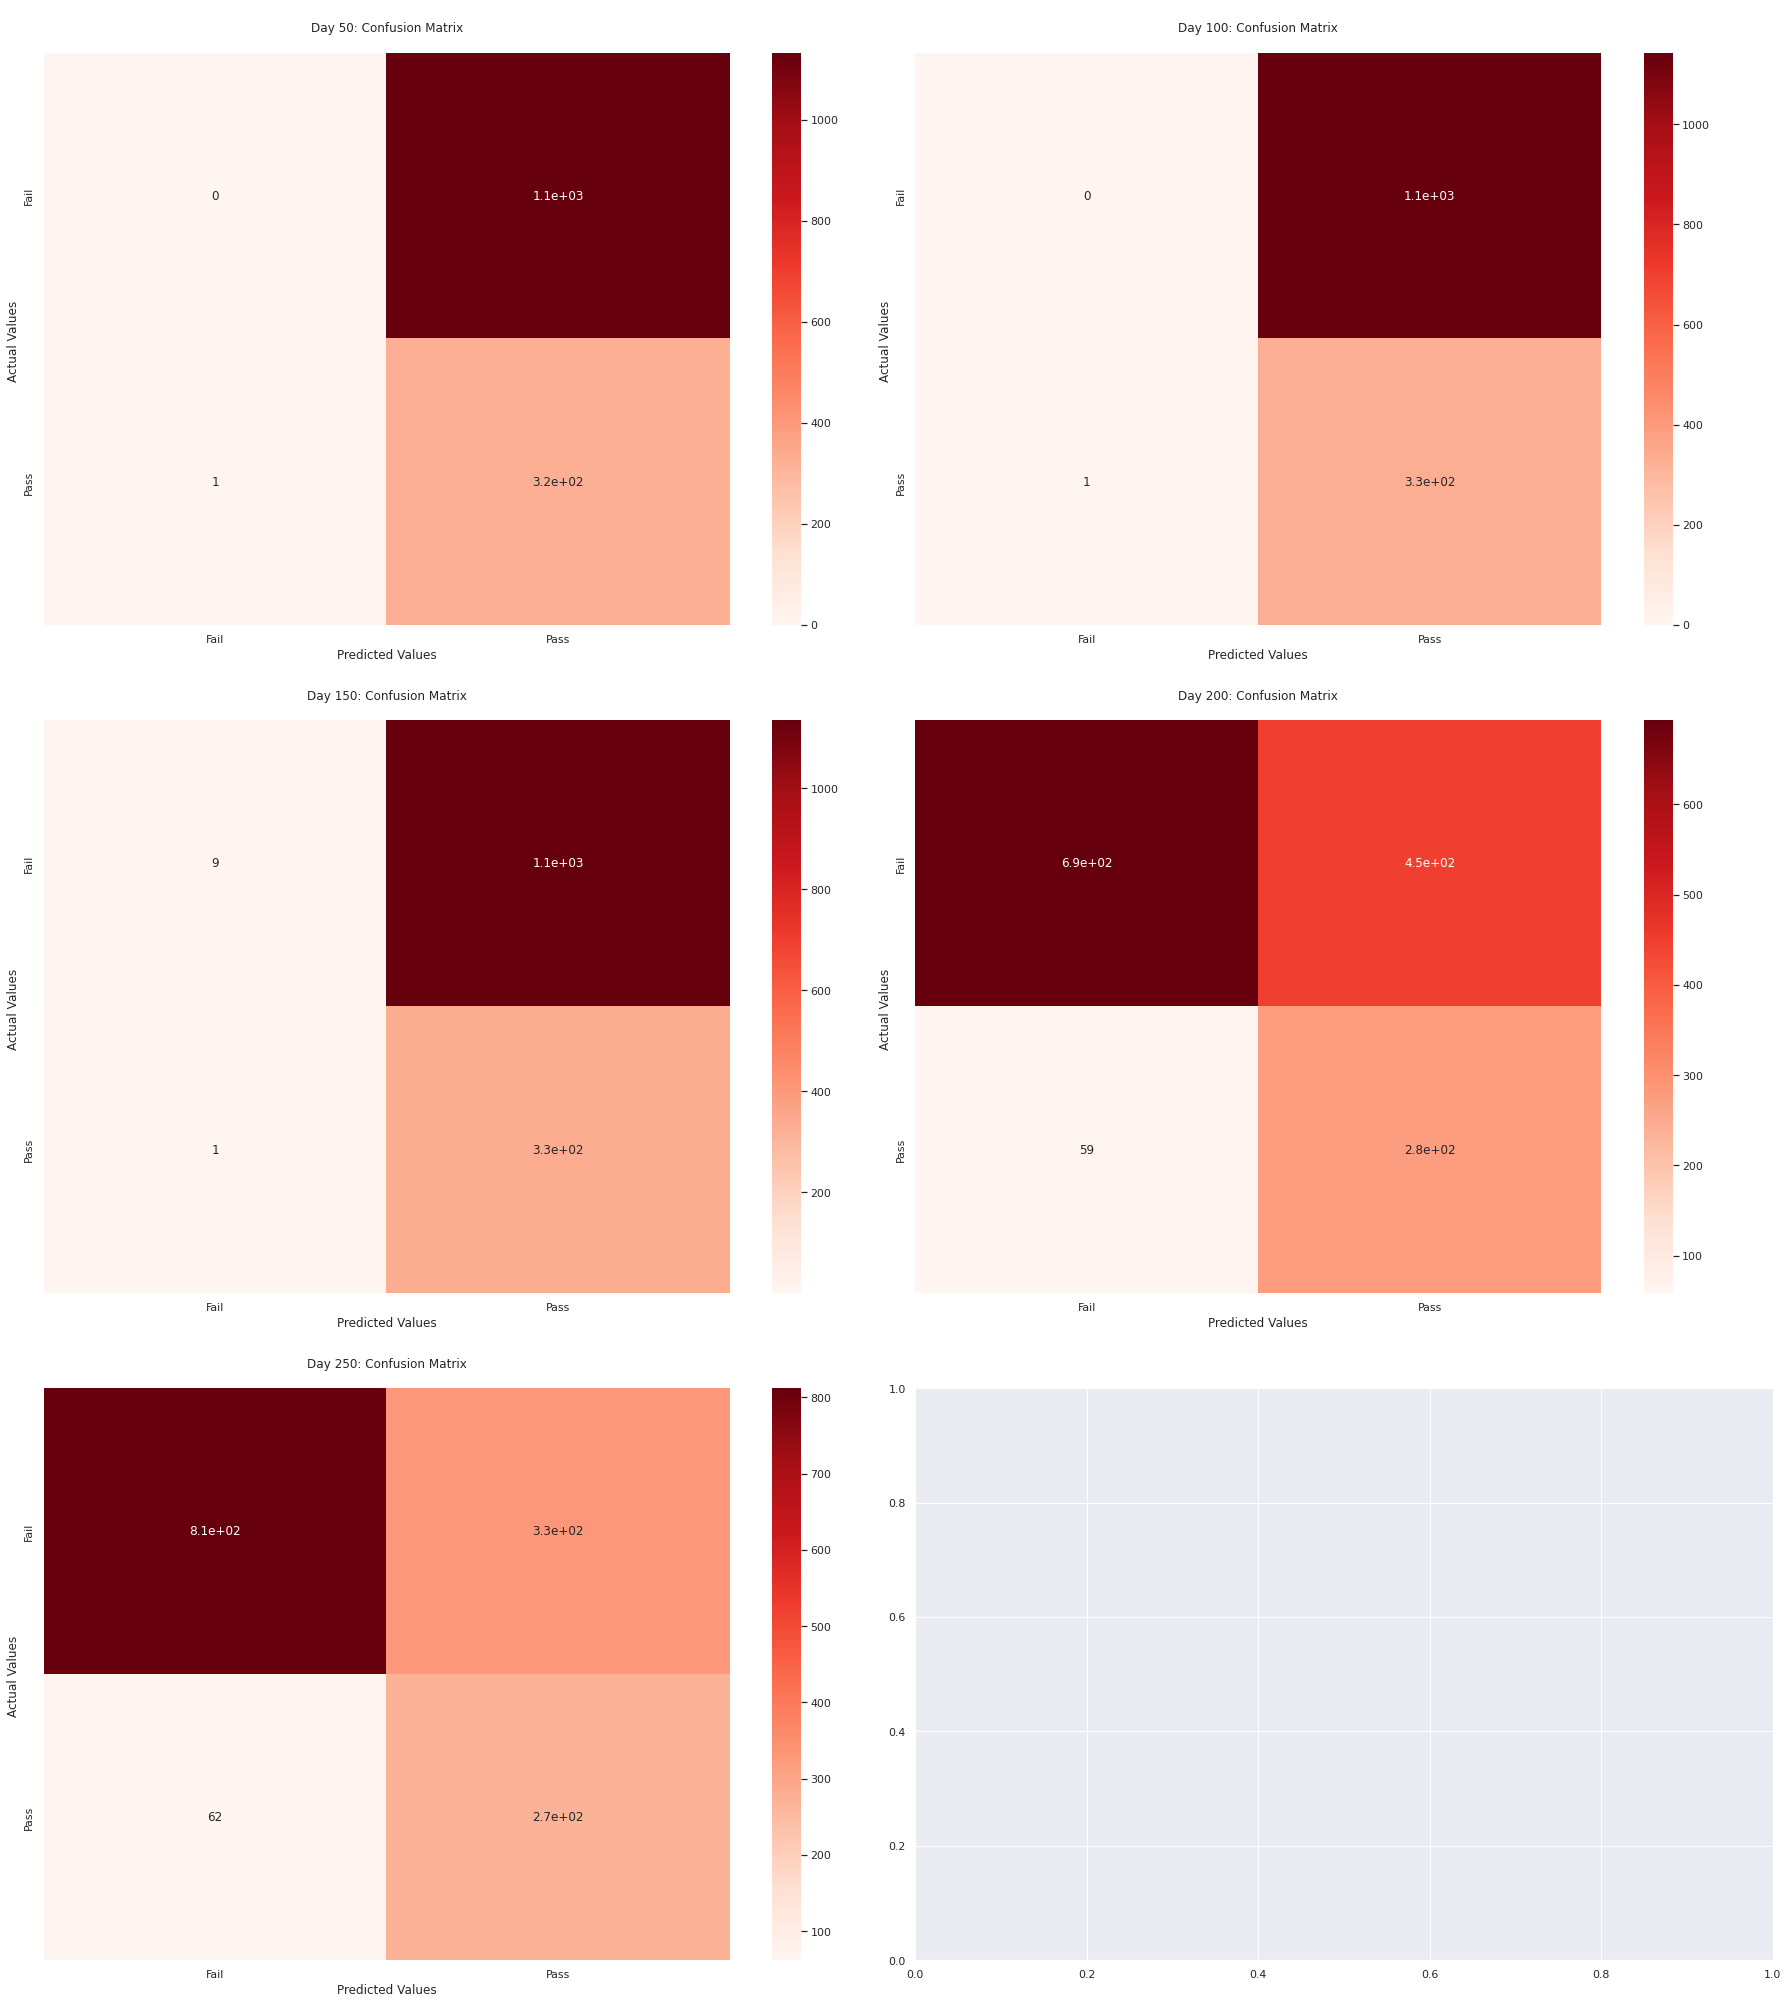

In [ ]:
plot_confusion_matrix(performance_results_rf)

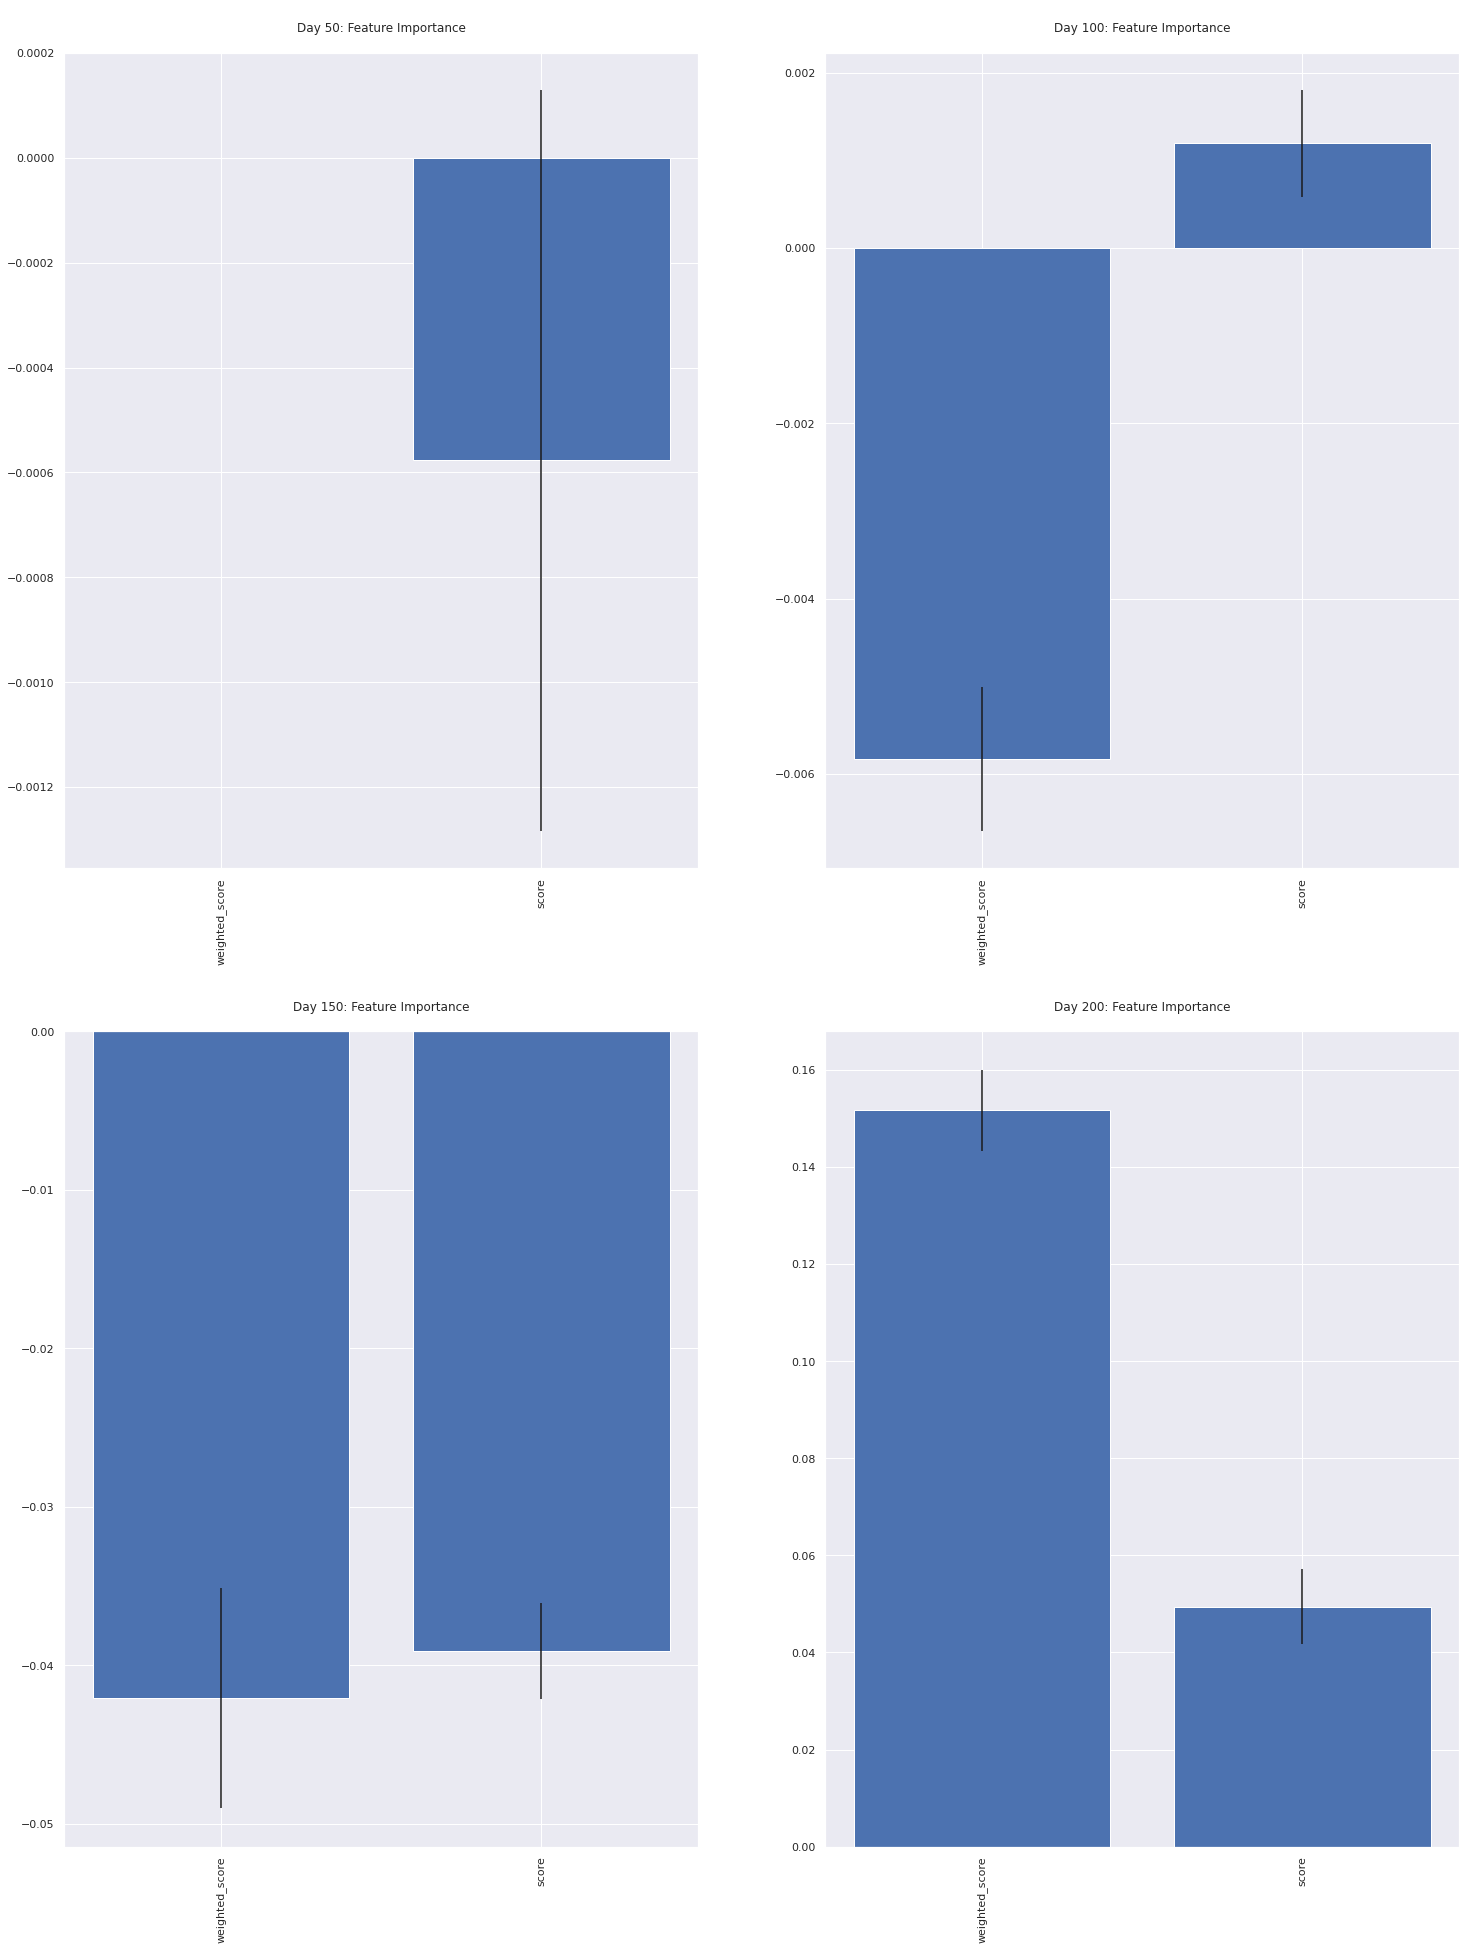

In [ ]:
plot_feature_importance(performance_features_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

performance_results_ab = []
performance_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_ab.append([acc, f1, prec, recall, conf])
  performance_features_ab.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.665
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.5624142661179699, F1 Score: 0.29735682819383263, Precision: 0.23156089193825044, Recall: 0.4153846153846154


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.780
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.20257452574525744, F1 Score: 0.3301081388730791, Precision: 0.20365168539325842, Recall: 0.8708708708708709


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.803
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.252538930264

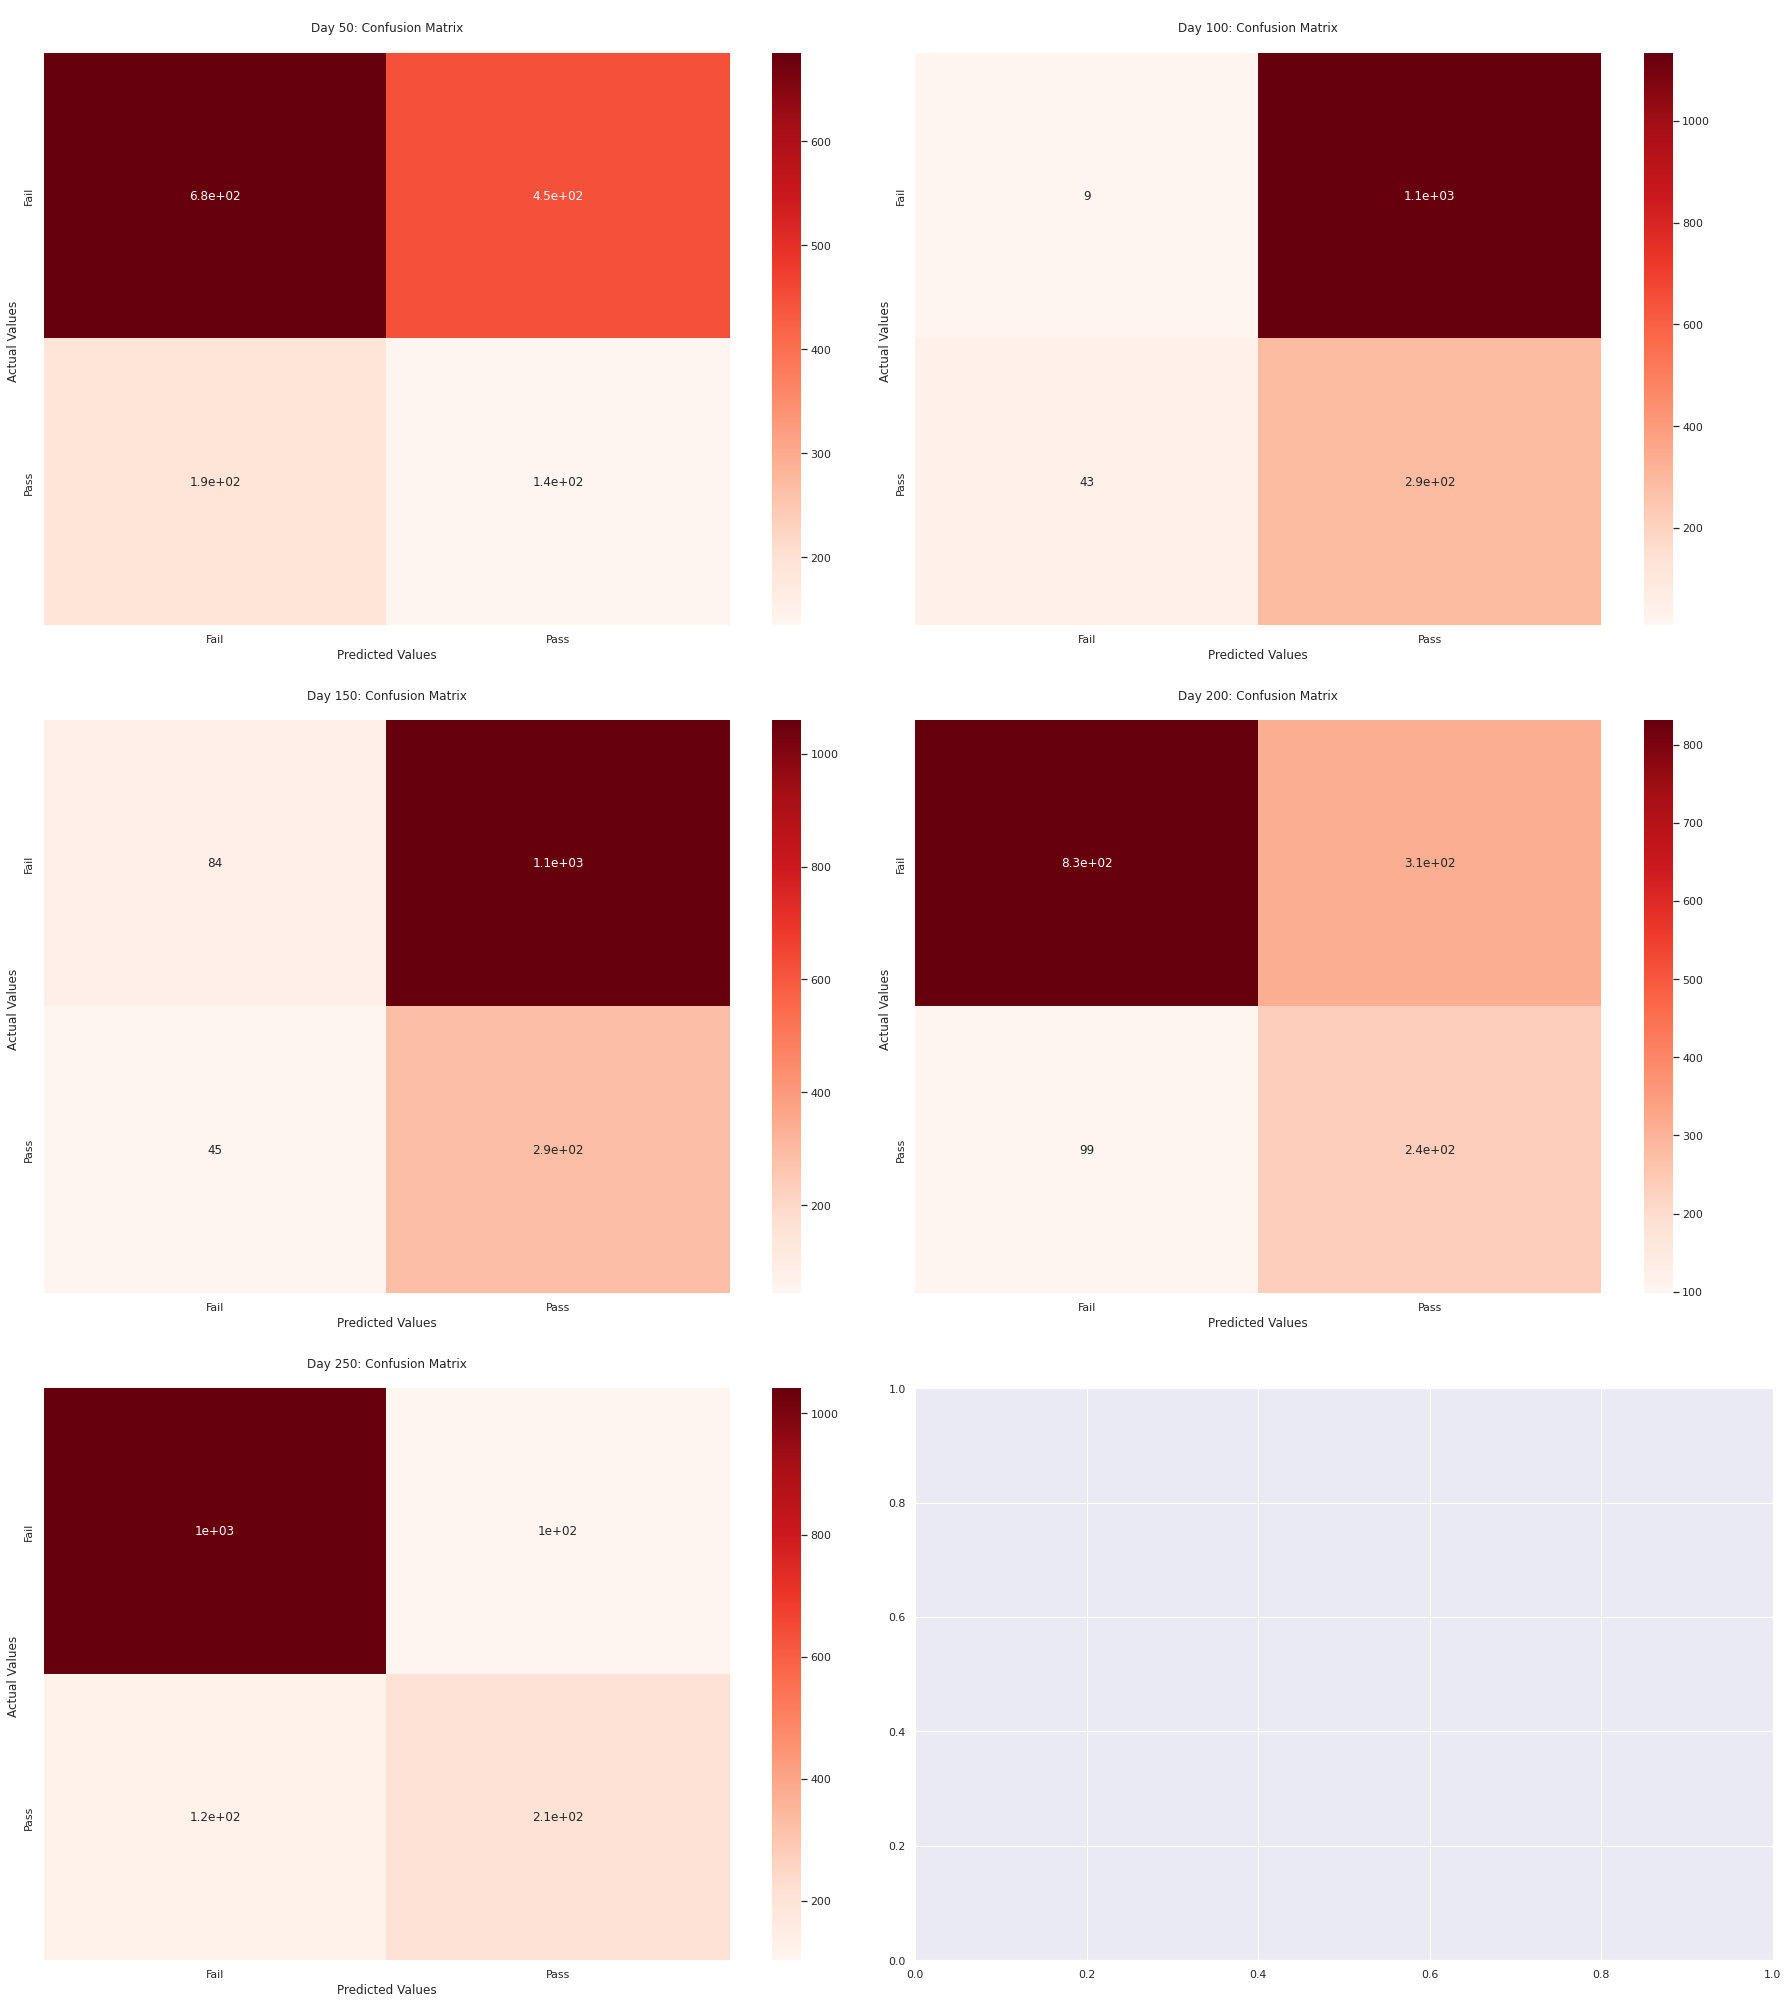

In [ ]:
plot_confusion_matrix(performance_results_ab)

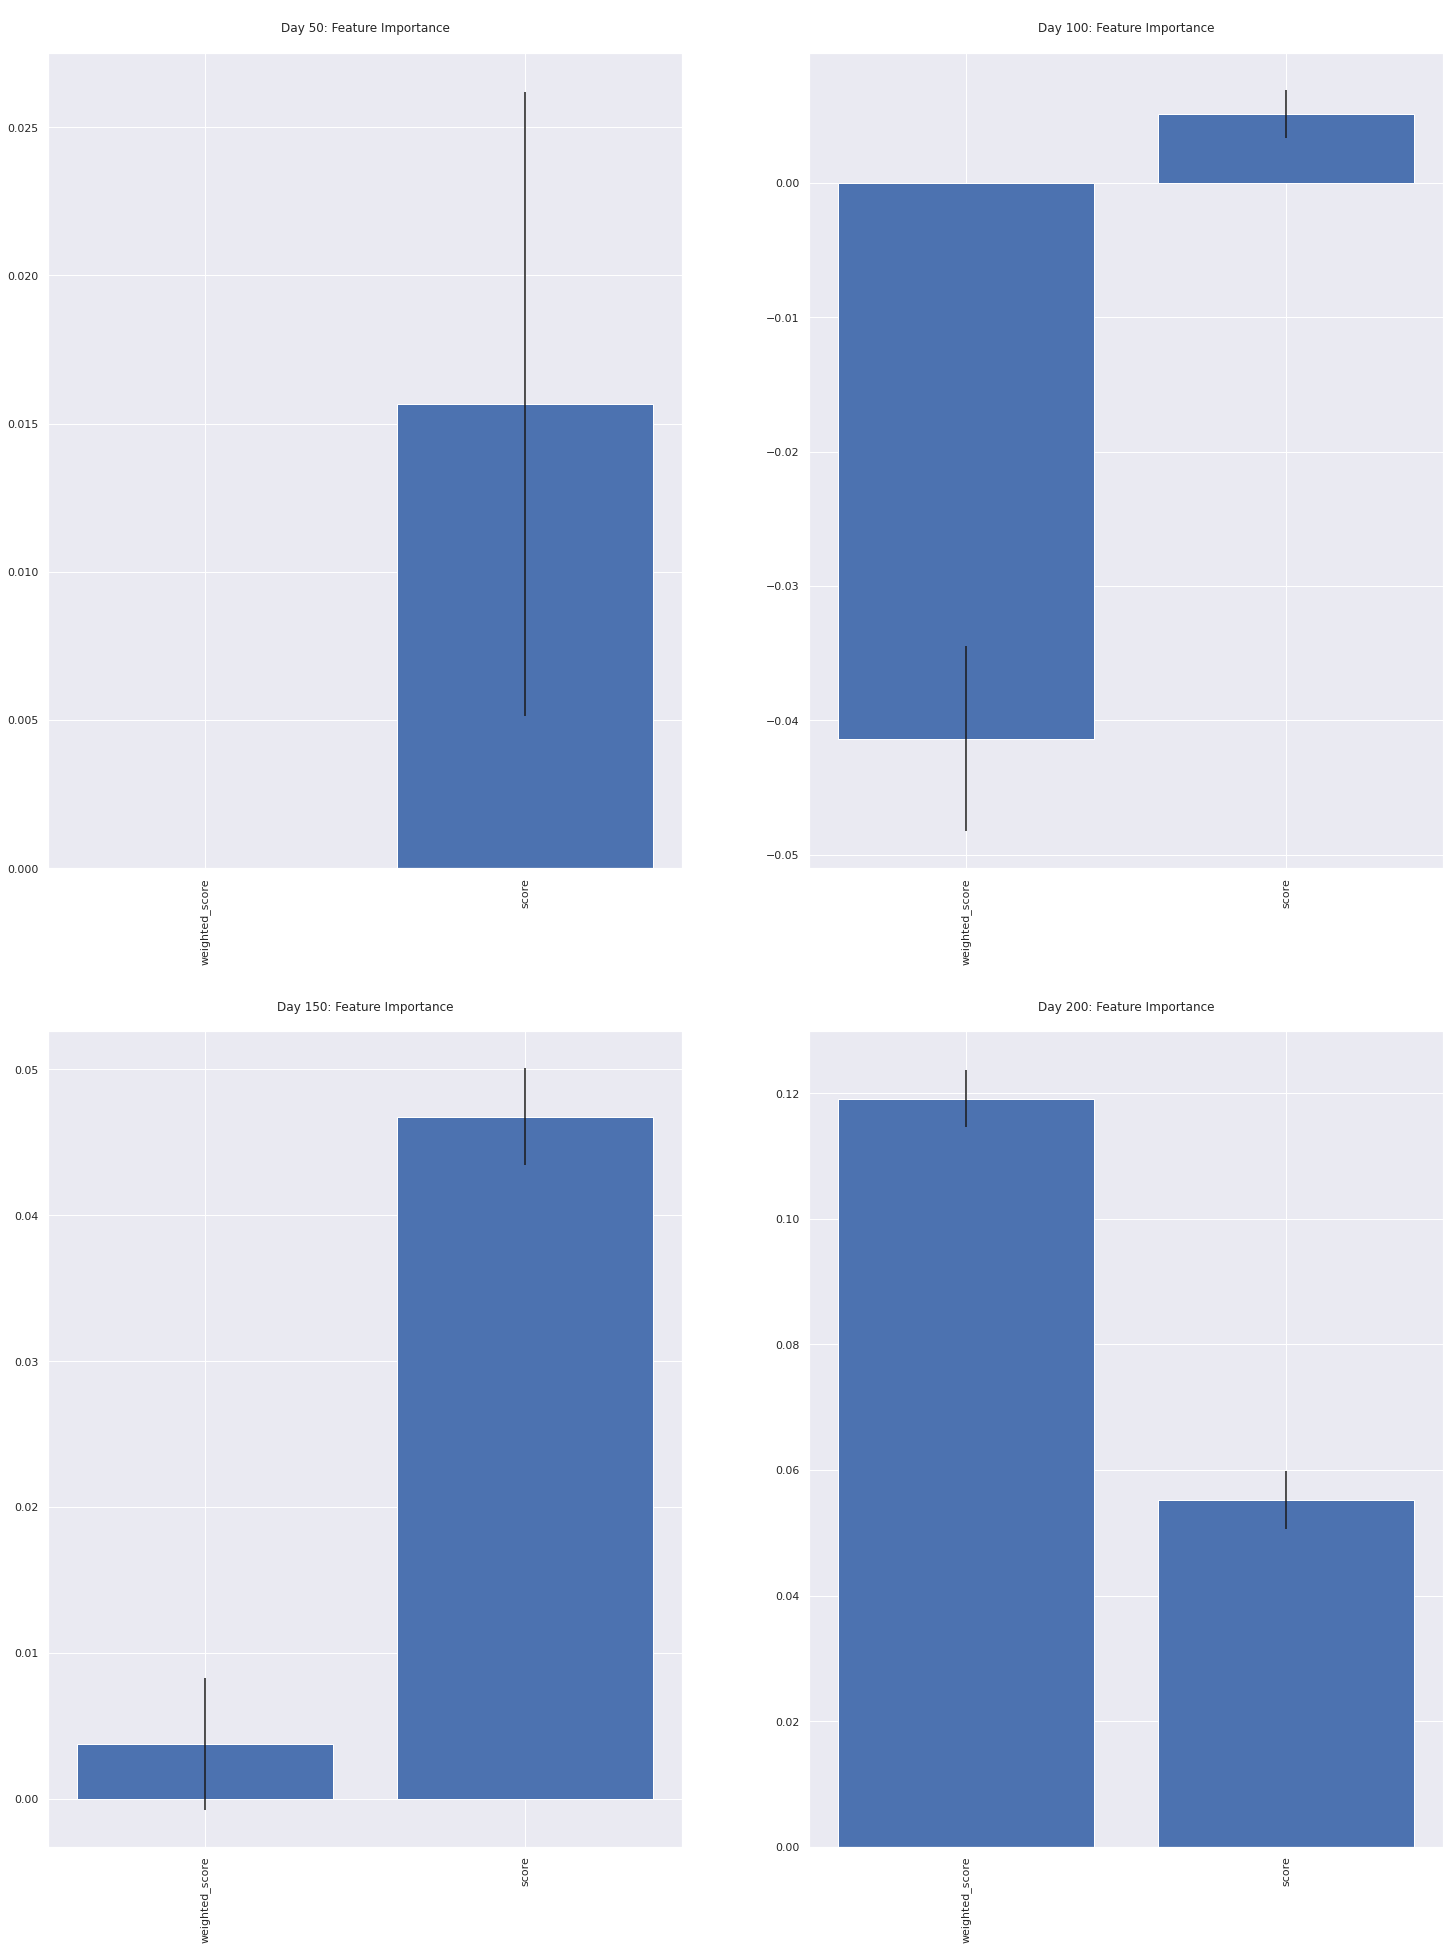

In [ ]:
plot_feature_importance(performance_features_ab)

##### Plot results overview

In [ ]:
performance_classifier_results = [performance_results_du, performance_results_nb, performance_results_lr, performance_results_lrw, performance_results_rf, performance_results_ab]
performance_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

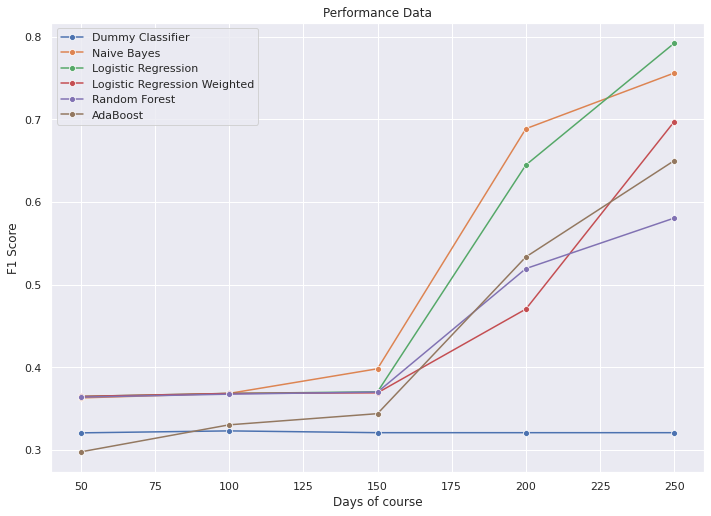

In [ ]:
plot_days_compare(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

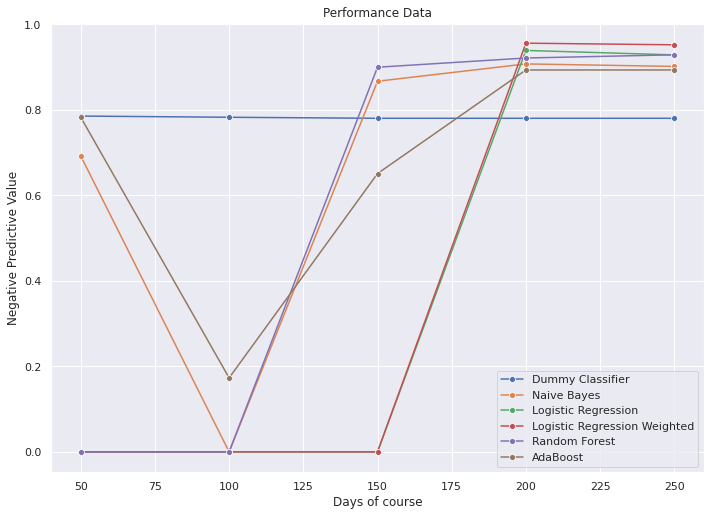

In [ ]:
plot_days_compare_npv(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

#### All data (Demographic, Learning Behaviour, Performance)

- Demographic and learning behaviour used throughout classifier
- Performance added for the last two predictions (200, 250) days

##### Prepare data for prediction

In [ ]:
all_df = {}
for i in df.keys():
  all_df[i] = split_dataframe_by_data_type(df[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

In [ ]:
all_df[50]

code_presentation  id_student gender               region  \
0                2013B       23629      F  East Anglian Region   
1                2013B       25107      F  East Anglian Region   
2                2013B       29144      M         South Region   
3                2013B       31663      M         North Region   
4                2013B       34229      F              Ireland   
...                ...         ...    ...                  ...   
5079             2014J     2688945      F         South Region   
5080             2014J     2692969      F             Scotland   
5081             2014J     2694919      F  East Anglian Region   
5082             2014J     2698577      F                Wales   
5083             2014J     2698588      F     Yorkshire Region   

          highest_education imd_band age_band disability  oucollaborate  \
0        Lower Than A Level   20-30%     0-35          N            0.0   
1        Lower Than A Level   20-30%     0-35          N            0.0   
2        Lower Than A Level   60-70%     0-35          N            0.0   
3     A Level or Equivalent   30-40%    35-55          N            0.0   
4     A Level or Equivalent    0-10%    35-55          N            0.0   
...                     ...      ...      ...        ...            ...   
5079       HE Qualification   40-50%    35-55          N            0.0   
5080       HE Qualification   80-90%    35-55          N            4.0   
5081     Lower Than A Level   60-70%    35-55          Y            1.0   
5082     Lower Than A Level   50-60%    35-55          N            2.0   
5083       HE Qualification   30-40%     0-35          N            1.0   

           url  ...   forumng       quiz  glossary   subpage  ouelluminate  \
0     0.000000  ...  3.181818   3.250000       0.0  2.500000           0.0   
1     1.142857  ...  4.700000   2.375000       0.0  1.750000           0.0   
2     1.333333  ...  2.645161   1.250000       1.0  1.775510           0.0   
3     1.947368  ...  3.641667   3.333333       1.0  2.264706           1.0   
4     1.200000  ...  3.130435   2.000000       1.0  2.363636           0.0   
...        ...  ...       ...        ...       ...       ...           ...   
5079  0.000000  ...  0.000000   0.000000       0.0  1.666667           0.0   
5080  1.000000  ...  3.047619  14.000000       1.0  1.444444           0.0   
5081  1.000000  ...  0.000000   0.000000       0.0  2.333333           0.0   
5082  1.000000  ...  4.800000   2.200000       0.0  3.333333           0.0   
5083  1.000000  ...  2.500000   0.000000       0.0  2.000000           0.0   

      sharedsubpage  oucontent  weighted_score  score  final_result  
0                 0   0.000000          14.820   65.0             1  
1                 0   1.000000          13.869   59.5             0  
2                 0   1.000000          13.015   57.5             1  
3                 0   1.000000          18.968   84.0             0  
4                 0   0.000000          18.746   78.0             0  
...             ...        ...             ...    ...           ...  
5079              0   1.800000           0.100  100.0             0  
5080              0   1.288889           0.100  100.0             0  
5081              0   2.156250           0.100  100.0             0  
5082              0   2.282051           0.100  100.0             1  
5083              0   1.578947           0.100  100.0             0  

[5084 rows x 23 columns]

In [ ]:
for i in list(df)[1:-2]:
  all_df[i] = all_df[i].drop(columns=["score","weighted_score"])

for i in list(df)[-2:]:
  all_df[i] = all_df[i].drop(columns=["score"])

In [ ]:
all_df[250]

code_presentation  id_student gender               region  \
0                2013B       23629      F  East Anglian Region   
1                2013B       25107      F  East Anglian Region   
2                2013B       29144      M         South Region   
3                2013B       31663      M         North Region   
4                2013B       34229      F              Ireland   
...                ...         ...    ...                  ...   
5130             2014J     2688945      F         South Region   
5131             2014J     2692969      F             Scotland   
5132             2014J     2694919      F  East Anglian Region   
5133             2014J     2698577      F                Wales   
5134             2014J     2698588      F     Yorkshire Region   

          highest_education imd_band age_band disability  questionnaire  \
0        Lower Than A Level   20-30%     0-35          N       0.000000   
1        Lower Than A Level   20-30%     0-35          N       0.000000   
2        Lower Than A Level   60-70%     0-35          N       0.000000   
3     A Level or Equivalent   30-40%    35-55          N       0.000000   
4     A Level or Equivalent    0-10%    35-55          N       0.000000   
...                     ...      ...      ...        ...            ...   
5130       HE Qualification   40-50%    35-55          N       1.333333   
5131       HE Qualification   80-90%    35-55          N       0.000000   
5132     Lower Than A Level   60-70%    35-55          Y       0.000000   
5133     Lower Than A Level   50-60%    35-55          N       0.000000   
5134       HE Qualification   30-40%     0-35          N       0.000000   

      oucollaborate  ...  mean_click   forumng       quiz  glossary   subpage  \
0          0.000000  ...    0.619571  3.863636   2.777778       0.0  2.500000   
1          0.000000  ...    1.171028  5.303448   2.481481       2.0  1.500000   
2          0.000000  ...    0.865871  3.223140   3.095238       1.0  1.896996   
3          0.000000  ...    1.106714  4.207955   3.357143       1.0  1.933884   
4          0.000000  ...    1.342644  3.324675   2.500000      13.0  2.104167   
...             ...  ...         ...       ...        ...       ...       ...   
5130       2.750000  ...    1.581449  1.000000  16.000000       0.0  1.500000   
5131       1.833333  ...    1.302715  2.582192  10.324324       1.0  1.571429   
5132       1.000000  ...    5.584503  7.588235  93.571429       0.0  2.000000   
5133       1.666667  ...    1.285652  5.150000   6.363636       0.0  2.375000   
5134       1.000000  ...    0.763940  2.695652   0.000000       0.0  2.235294   

      ouelluminate  sharedsubpage  oucontent  weighted_score  final_result  
0            0.000            0.0   0.000000          17.020             1  
1            1.000            0.0   1.000000          61.361             0  
2            0.000            0.0   1.000000          53.679             1  
3            1.125            0.0   1.000000          64.792             0  
4            0.000            0.0   0.000000          65.862             0  
...            ...            ...        ...             ...           ...  
5130         0.000            0.0   4.962963          68.272             0  
5131         0.000            0.0   2.496241          70.135             0  
5132         0.000            0.0   2.300000          66.767             0  
5133         0.000            0.0   2.377551          56.122             1  
5134         0.000            0.0   3.208955          92.862             0  

[5135 rows x 23 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(all_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['url', 'homepage', 'resource', 'mean_click', 'forumng', 'quiz',
       'glossary', 'subpage', 'sharedsubpage', 'oucontent'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['oucollaborate', 'url', 'homepage', 'resource', 'mean_click', 'forumng',
       'quiz', 'glossary', 'subpage', 'sharedsubpage', 'oucontent'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['oucollaborate', 'url', 'homepage', 'resource', 'mean_click', 'forumng',
       'quiz', 'glossary', 'subpage', 'sharedsubpage', 'oucontent'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['oucollaborate', 'url', 'homepage

In [ ]:
X_train[50]

gender_F  gender_M  region_East Anglian Region  \
1126       0.0       1.0                         0.0   
1127       0.0       1.0                         0.0   
1128       1.0       0.0                         0.0   
1129       1.0       0.0                         0.0   
1130       1.0       0.0                         0.0   
...        ...       ...                         ...   
2588       1.0       0.0                         0.0   
2589       1.0       0.0                         0.0   
2590       1.0       0.0                         0.0   
2591       1.0       0.0                         0.0   
2592       1.0       0.0                         0.0   

      region_East Midlands Region  region_Ireland  region_London Region  \
1126                          0.0             0.0                   0.0   
1127                          0.0             0.0                   0.0   
1128                          0.0             0.0                   0.0   
1129                          0.0             0.0                   0.0   
1130                          0.0             0.0                   0.0   
...                           ...             ...                   ...   
2588                          0.0             0.0                   1.0   
2589                          0.0             0.0                   0.0   
2590                          0.0             0.0                   0.0   
2591                          0.0             0.0                   0.0   
2592                          0.0             0.0                   0.0   

      region_North Region  region_North Western Region  region_Scotland  \
1126                  0.0                          0.0              0.0   
1127                  0.0                          1.0              0.0   
1128                  0.0                          0.0              0.0   
1129                  0.0                          0.0              0.0   
1130                  0.0                          0.0              1.0   
...                   ...                          ...              ...   
2588                  0.0                          0.0              0.0   
2589                  0.0                          0.0              1.0   
2590                  0.0                          0.0              0.0   
2591                  0.0                          0.0              0.0   
2592                  1.0                          0.0              0.0   

      region_South East Region  ...       url  homepage  resource  mean_click  \
1126                       0.0  ...  0.208333  0.075669  0.285714    0.306525   
1127                       0.0  ...  0.361111  0.127691  0.285714    0.305353   
1128                       0.0  ...  0.361111  0.223566  0.371429    0.407040   
1129                       0.0  ...  0.208333  0.225551  0.321429    0.316254   
1130                       0.0  ...  0.166667  0.117707  0.285714    0.285444   
...                        ...  ...       ...       ...       ...         ...   
2588                       0.0  ...  0.166667  0.075669  0.000000    0.035767   
2589                       0.0  ...  0.203704  0.108098  0.302521    0.393245   
2590                       0.0  ...  0.166667  0.064859  0.000000    0.408203   
2591                       0.0  ...  0.219298  0.191397  0.386555    0.327119   
2592                       0.0  ...  0.166667  0.083235  0.000000    0.164530   

       forumng      quiz  glossary   subpage  sharedsubpage  oucontent  
1126  0.132771  0.266129       0.0  0.170414       0.000000   0.147287  
1127  0.081868  0.483871       0.1  0.200000       0.000000   0.034884  
1128  0.360825  0.096774       0.0  0.191716       0.000000   0.116279  
1129  0.194023  0.266129       0.0  0.323077       0.000000   0.034884  
1130  0.270619  0.096774       0.0  0.221538       0.000000   0.093023  
...        ...       ...       ...       ...            ...        ...  
2588  0.000000  0.000000       0.0  0.000000   

###### Undersampling

In [ ]:
Y_train[50].value_counts()

0    1053
1     414
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = TomekLinks() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({0: 841, 1: 303})
Resample dataset shape Counter({0: 728, 1: 303})
Sampling for day 50
Original dataset shape: Counter({0: 1053, 1: 414})
Resample dataset shape Counter({0: 912, 1: 414})
Sampling for day 100
Original dataset shape: Counter({0: 1060, 1: 417})
Resample dataset shape Counter({0: 915, 1: 417})
Sampling for day 150
Original dataset shape: Counter({0: 1063, 1: 421})
Resample dataset shape Counter({0: 924, 1: 421})
Sampling for day 200
Original dataset shape: Counter({0: 1063, 1: 421})
Resample dataset shape Counter({0: 963, 1: 421})
Sampling for day 250
Original dataset shape: Counter({0: 1064, 1: 421})
Resample dataset shape Counter({0: 969, 1: 421})


###### Reduce dimensions

In [ ]:
for i in df.keys():
  pca = PCA(n_components='mle')

  X_train[i] = pca.fit_transform(X_train[i], Y_train[i])                             
  
  X_test[i] = pca.transform(X_test[i])

In [ ]:
X_train[250].shape

(1485, 40)

###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [ ]:
X_train[250]

0         1         2         3         4         5         6   \
0     0.393452  1.283392  0.407258 -0.225070 -0.115487 -0.422192  0.771296   
1    -0.317902  1.365701 -0.873378  0.633319  0.034087 -0.268869 -0.489757   
2     0.330033  0.066596 -1.043481  0.746486  0.409142 -0.039012  0.216615   
3    -0.211183 -0.290352 -0.138709 -0.239488 -0.289963  0.100315 -0.206617   
4    -0.123153 -0.329296  1.138961  0.832770  0.150911  0.084483 -0.014995   
...        ...       ...       ...       ...       ...       ...       ...   
1480  0.326868 -0.098016 -0.048561 -0.206162 -0.001600  0.288545 -0.312143   
1481  0.500326 -0.389453  0.952237  0.737933  0.196890  0.086534 -0.008007   
1482 -0.928739 -0.032116 -0.814128  0.934004 -0.266086 -0.242345  0.421454   
1483 -0.878884 -0.162784 -0.028750 -0.385760  0.426918  0.180359  0.026744   
1484 -0.860914 -0.178426 -0.017400 -0.319359  0.396718  0.076116  0.026076   

            7         8         9         10        11        12        13  \
0    -0.201645  0.720965 -0.293703  0.001942  0.027691 -0.083856  0.228831   
1     0.639060  0.219508 -0.066237 -0.092400  0.226250  0.005654 -0.243209   
2     0.136325 -0.010124 -0.021871  0.023031  0.186980 -0.114380 -0.183003   
3    -0.554568 -0.226588  0.309120  0.034092  0.135813 -0.177977 -0.061874   
4     0.130214 -0.025422 -0.275017 -0.304523  0.394105 -0.348877 -0.037347   
...        ...       ...       ...       ...       ...       ...       ...   
1480 -0.299852 -0.055740  0.662792 -0.219586 -0.479056 -0.469328  0.300141   
1481  0.137568 -0.051660 -0.292907 -0.299352  0.389952 -0.340018 -0.027090   
1482 -0.087752  0.191313 -0.757674 -0.496399 -0.525514 -0.024784  0.129924   
1483  0.120983 -0.269539  0.017877  0.094937 -0.148438  0.073431 -0.459571   
1484  0.127291 -0.262468 -0.033977  0.006428  0.000212  0.077506 -0.062233   

            14        15        16        17        18        19  
0     0.107044  0.128918 -0.025132  0.141241 -0.078973 -0.019295  
1    -0.302457 -0.051179 -0.250964  0.635450  0.492560  0.009042  
2    -0.578475  0.400770  0.536557 -0.225623 -0.157720  0.031312  
3    -0.466370  0.303732  0.425029 -0.113924 -0.027959 -0.062913  
4    -0.050571  0.196110 -0.093332 -0.072193  0.094053  0.059513  
...        ...       ...       ...       ...       ...       ...  
1480 -0.064359 -0.359496 -0.049815 -0.327421  0.372880 -0.141474  
1481 -0.031835  0.159234 -0.130839 -0.105497  0.081124  0.045718  
1482 -0.035325  0.026053 -0.157200  0.070455 -0.215983 -0.115173  
1483  0.327313  0.668577 -0.337584 -0.239623  0.005546 -0.083252  
1484  0.018553  0.352028  0.097641  0.191368 -0.372139  0.313511  

[1485 rows x 20 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

all_results_du = []
all_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_du.append([acc, f1, prec, recall, conf])
  all_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.476
Best parameters set:
Accuracy: 0.5178105994787141, F1 Score: 0.33212996389891697, Precision: 0.24, Recall: 0.5390625


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.434
Best parameters set:
Accuracy: 0.5082304526748971, F1 Score: 0.32037914691943126, Precision: 0.23150684931506849, Recall: 0.52


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.453
Best parameters set:
Accuracy: 0.508130081300813, F1 Score: 0.32276119402985076, Precision: 0.23410013531799728, Recall: 0.5195195195195195


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.469
Best parameters set:
Accuracy: 0.5064

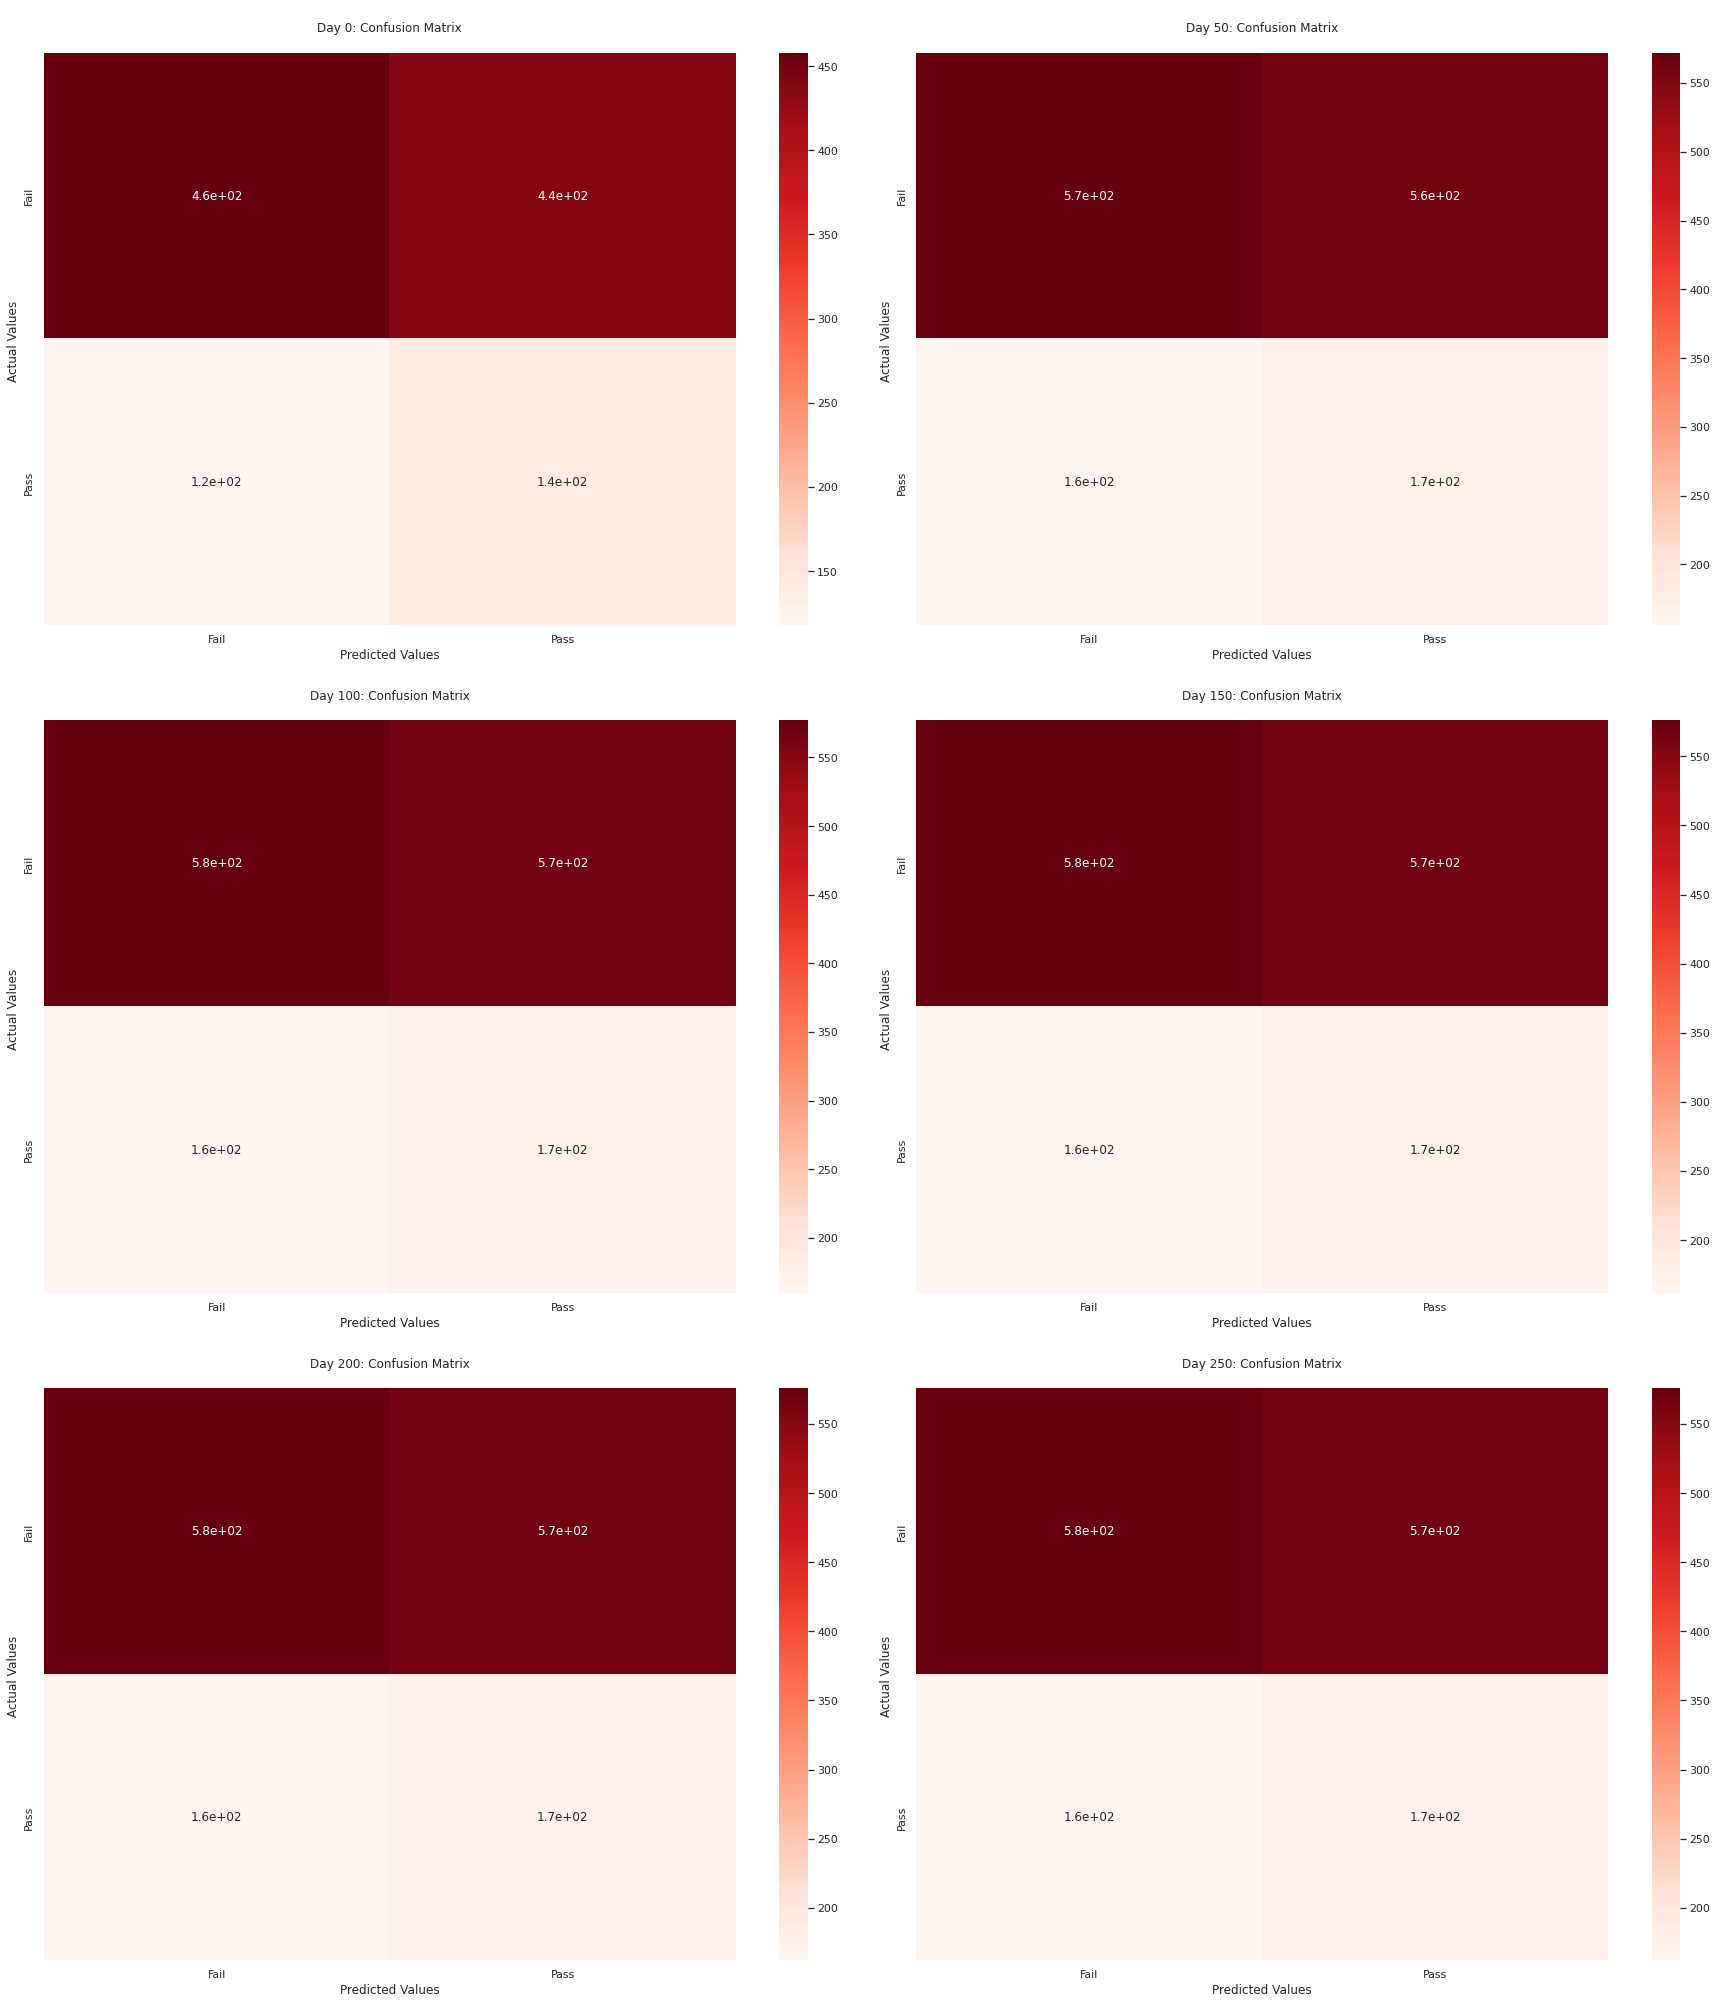

In [ ]:
plot_confusion_matrix(all_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

all_results_nb = []

pipeline = Pipeline([
    ('clf', GaussianNB()),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_nb.append([acc, f1, prec, recall, conf])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.583
Best parameters set:
Accuracy: 0.6959165942658557, F1 Score: 0.3243243243243243, Precision: 0.32061068702290074, Recall: 0.328125


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.623
Best parameters set:
Accuracy: 0.6659807956104252, F1 Score: 0.4167664670658683, Precision: 0.3411764705882353, Recall: 0.5353846153846153


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.656
Best parameters set:
Accuracy: 0.3258807588075881, F1 Score: 0.36095054592164416, Precision: 0.2295751633986928, Recall: 0.8438438438438438


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.654
Best paramet

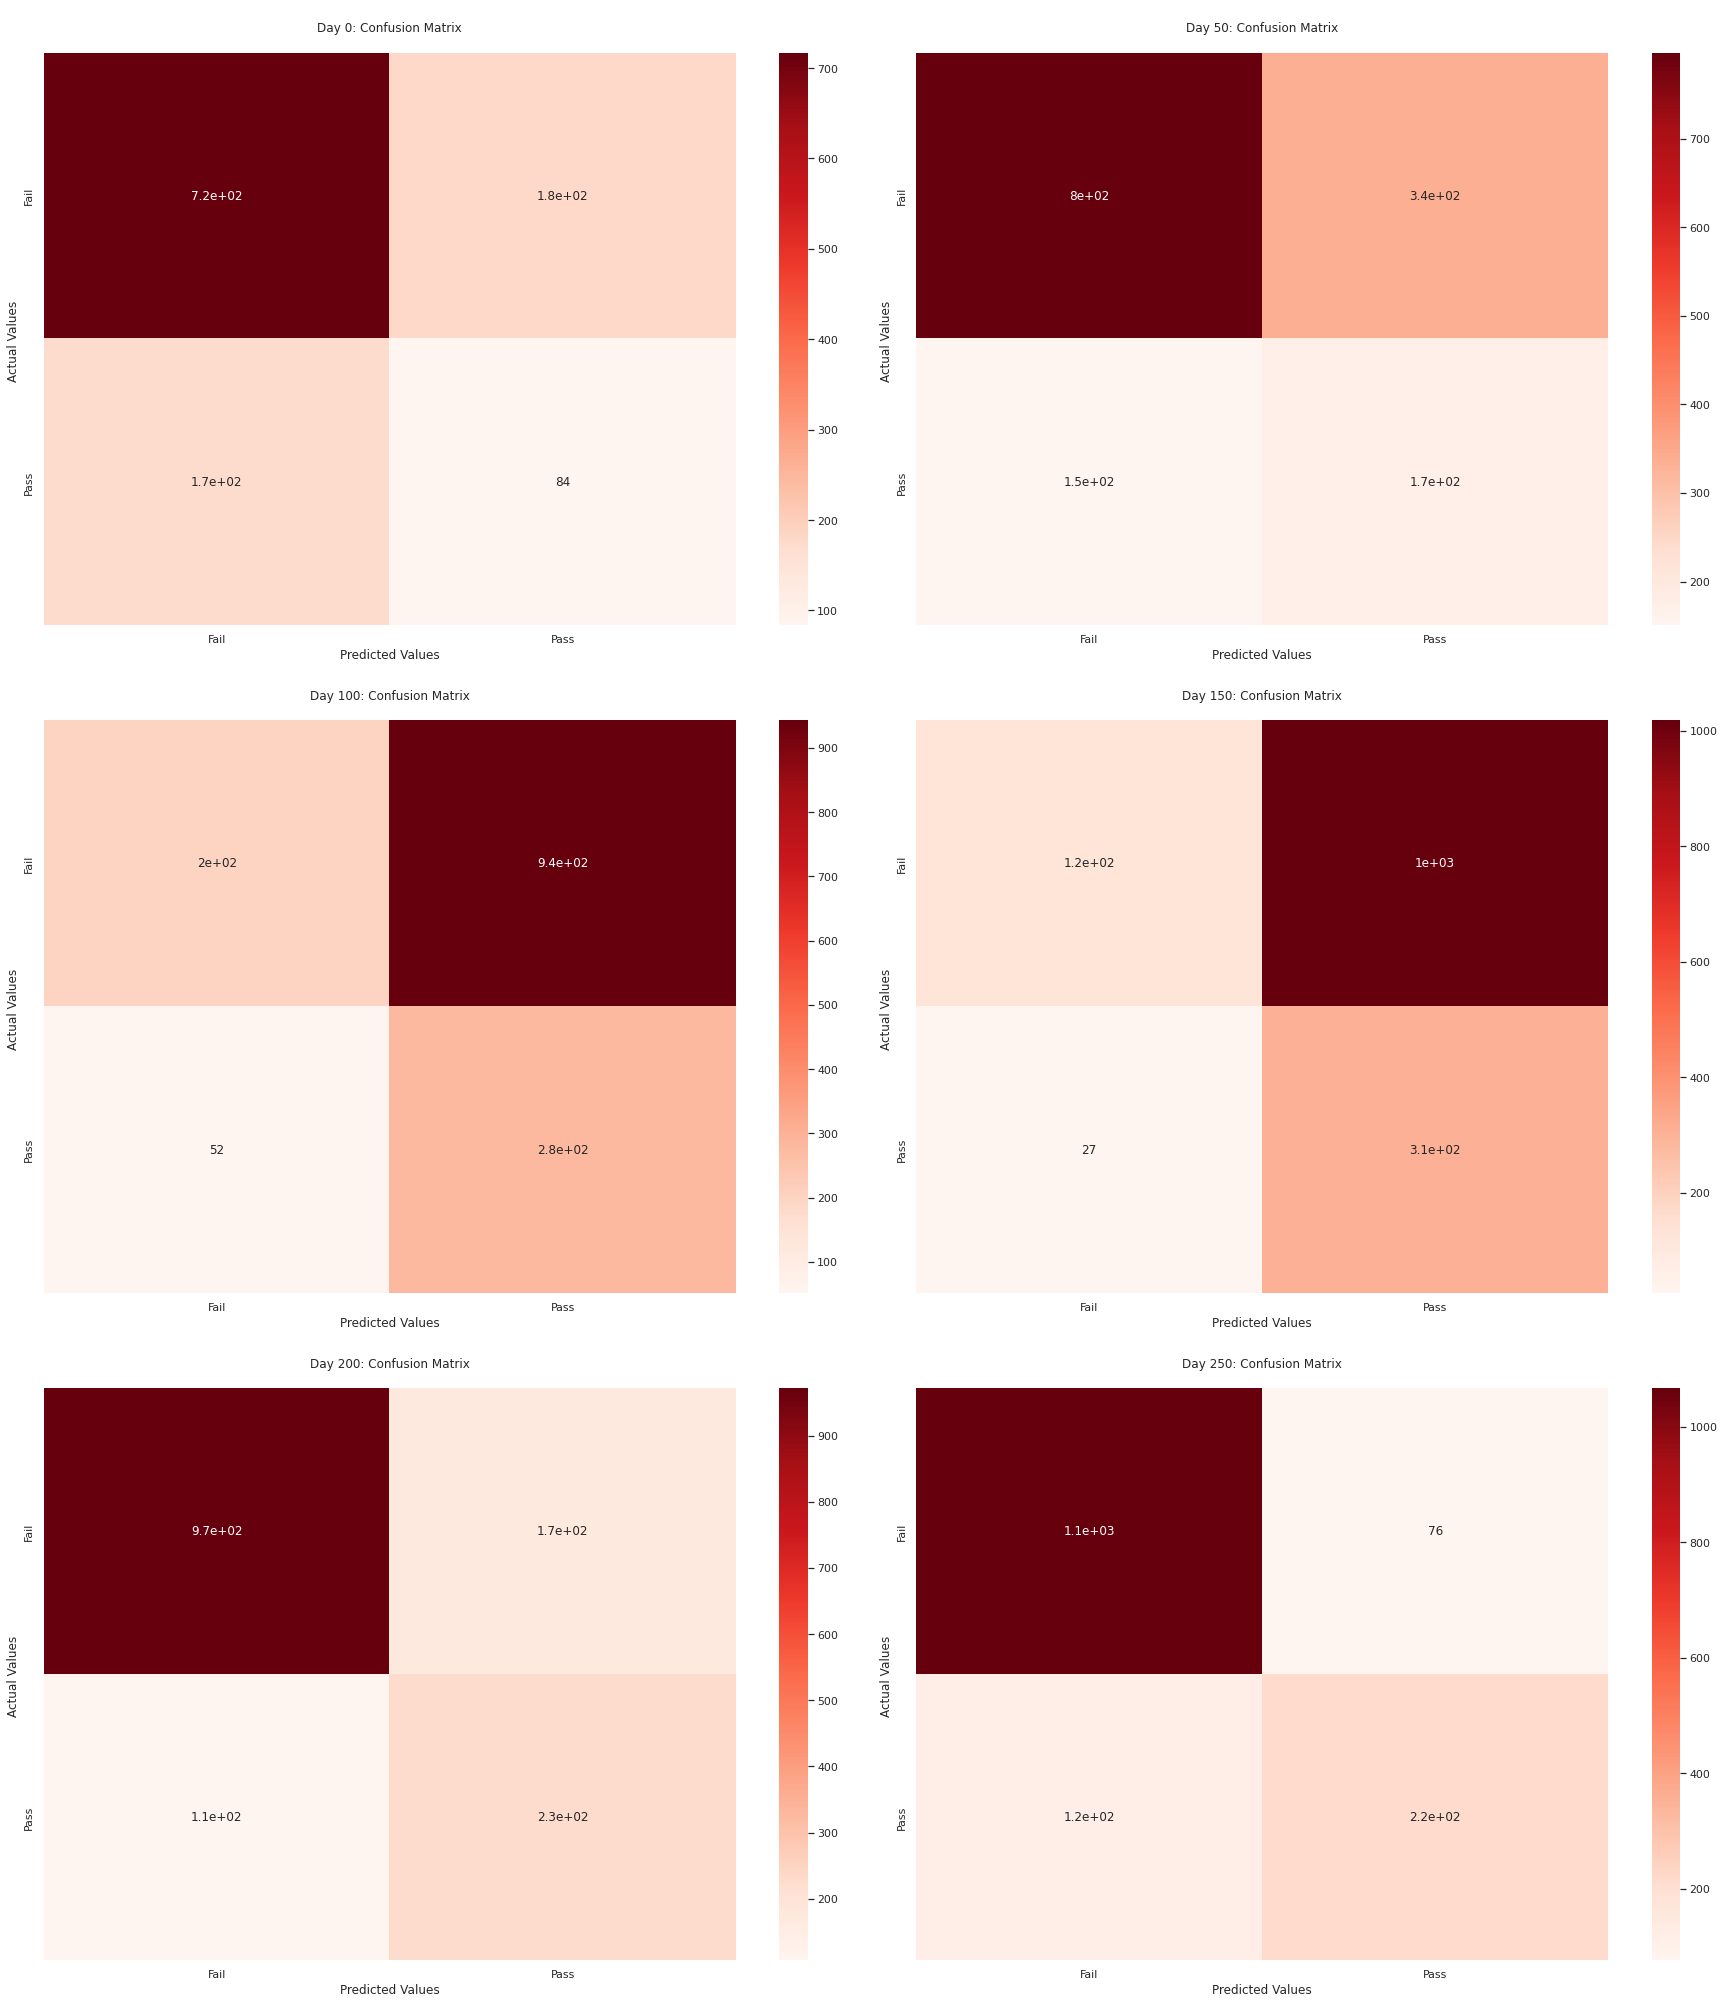

In [ ]:
plot_confusion_matrix(all_results_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

all_results_predict_proba_lr = []
all_results_predict_lr = []

all_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000)),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lr.append([acc, f1, prec, recall, conf])
  all_results_predict_proba_lr.append(predictions_proba)
  all_results_predict_lr.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.560
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7593397046046916, F1 Score: 0.29516539440203565, Precision: 0.4233576642335766, Recall: 0.2265625


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.608
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7345679012345679, F1 Score: 0.37881219903691815, Precision: 0.3959731543624161, Recall: 0.3630769230769231


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.633
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7269647696476965, F1 Score: 0.4167872648335746, Precision: 0.4022346368715084, Recall: 0.43243243243243246


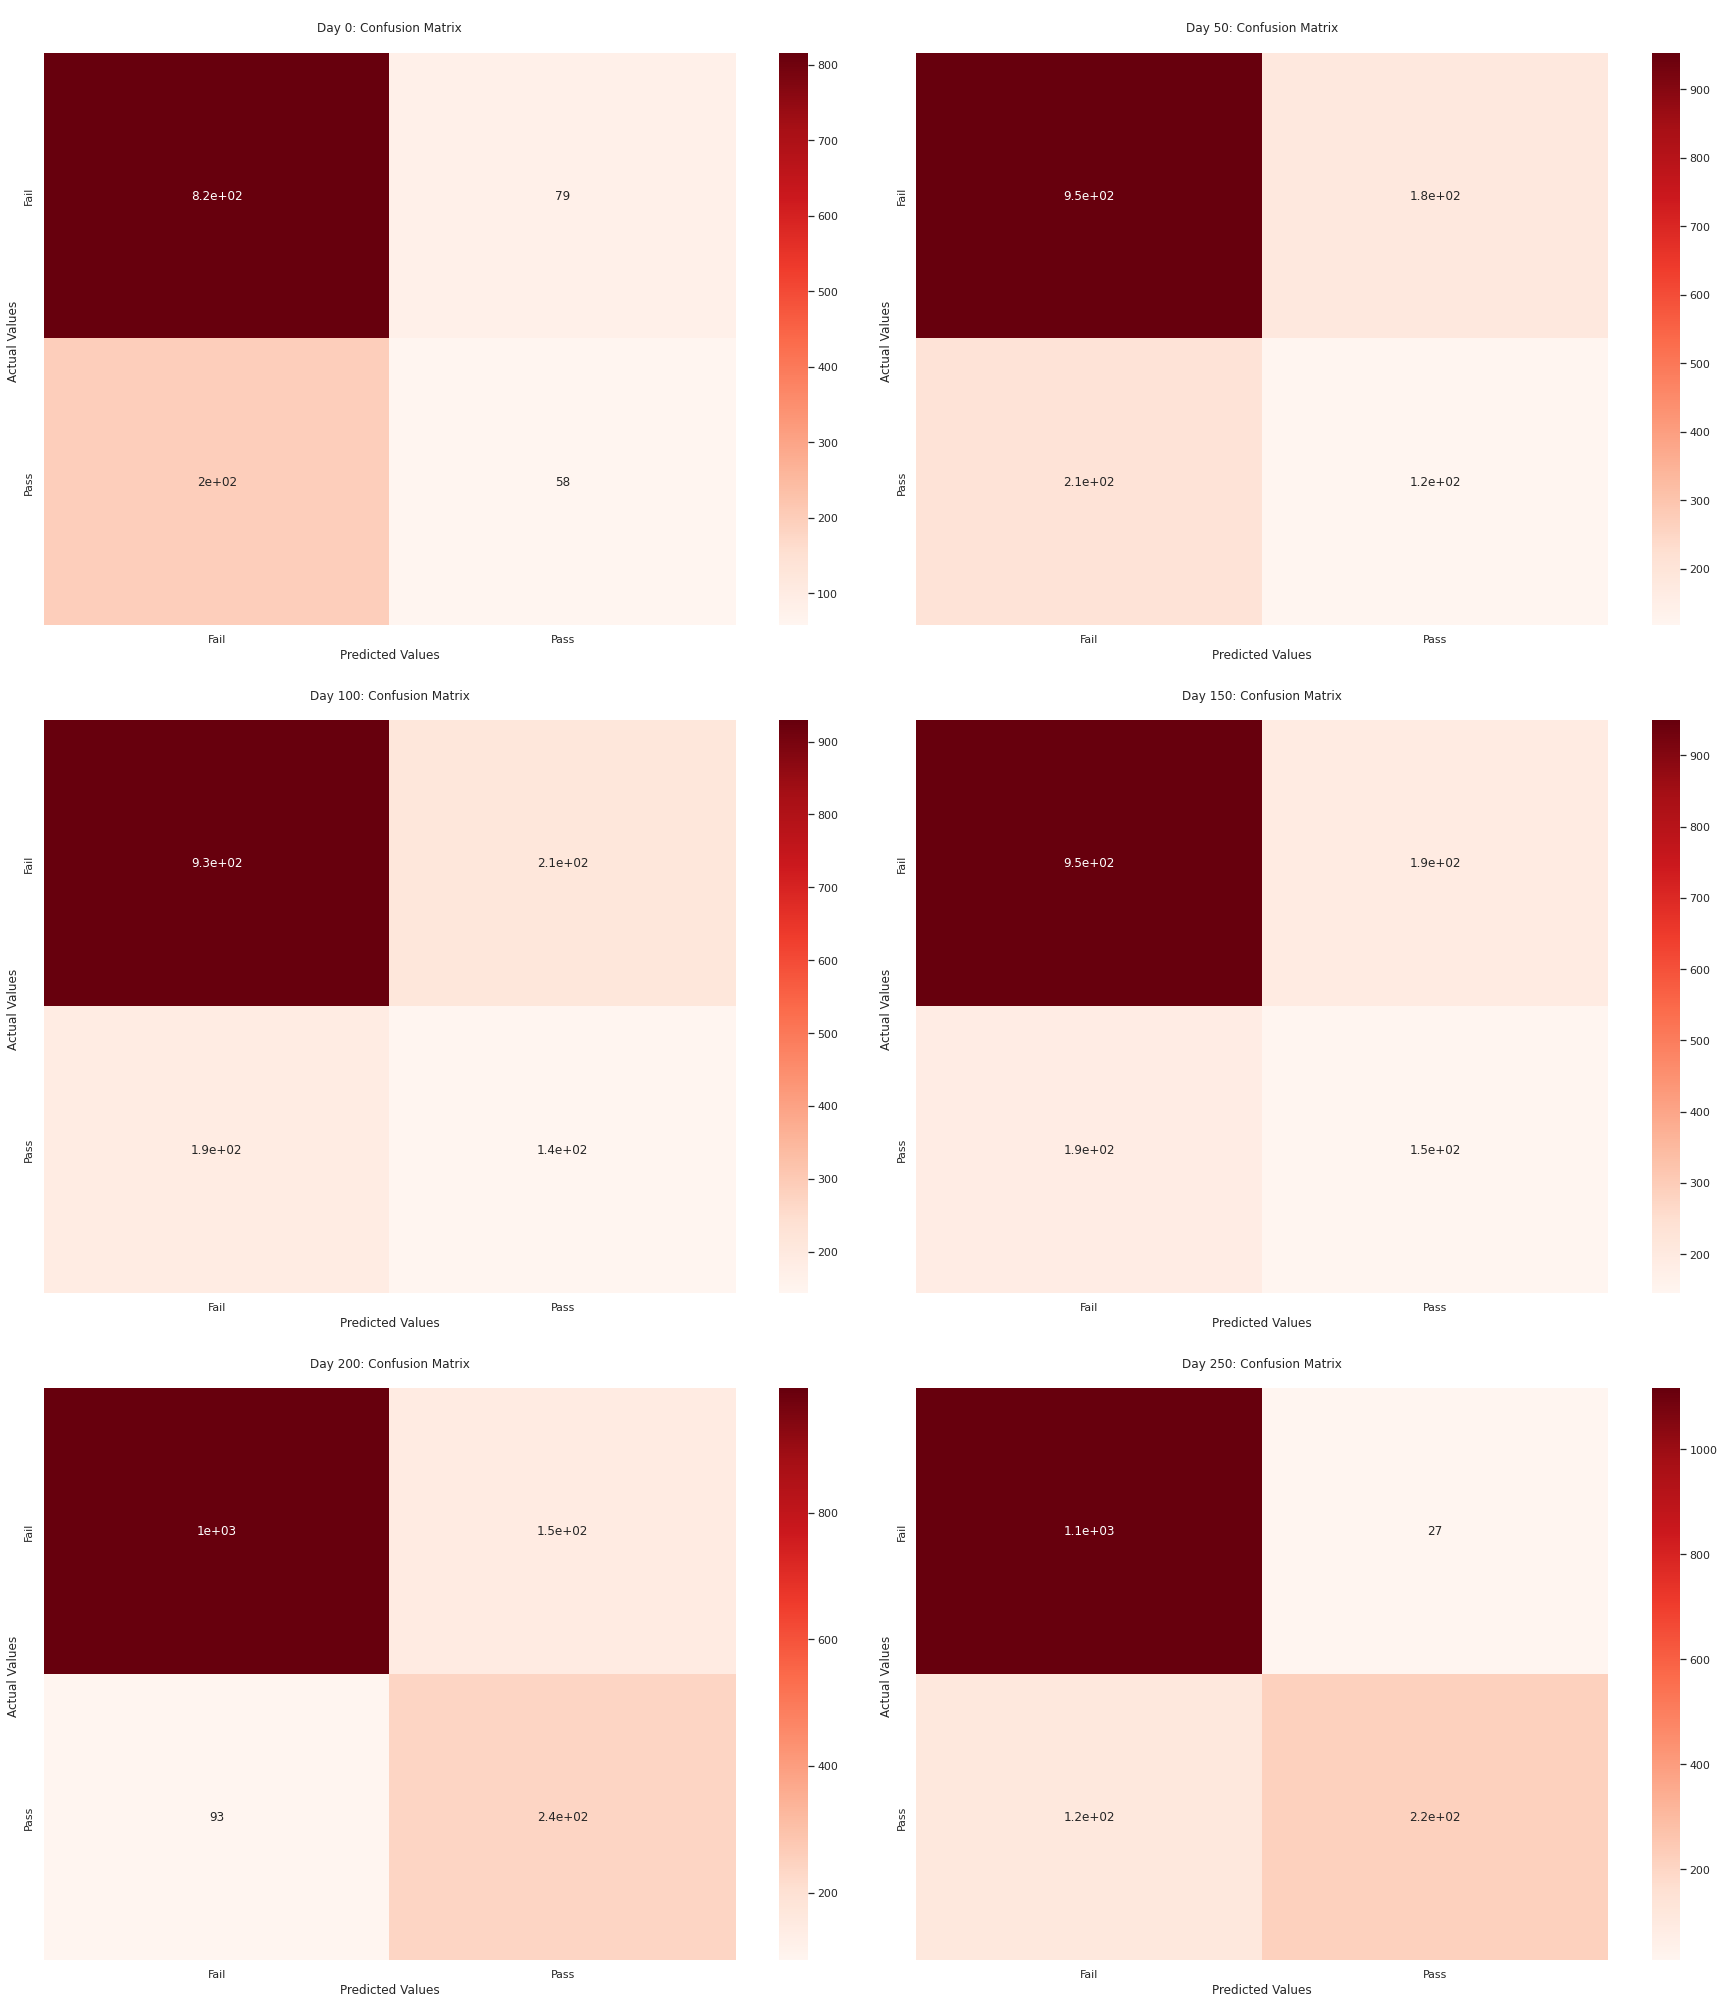

In [ ]:
plot_confusion_matrix(all_results_lr)

##### WeightedLogisticRegression

In [ ]:
all_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000,class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.600
Best parameters set:
Accuracy: 0.6116420503909644, F1 Score: 0.4334600760456274, Precision: 0.32082551594746717, Recall: 0.66796875


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.627
Best parameters set:
Accuracy: 0.654320987654321, F1 Score: 0.42334096109839814, Precision: 0.33697632058287796, Recall: 0.5692307692307692


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.642
Best parameters set:
Accuracy: 0.7073170731707317, F1 Score: 0.441860465116279, Precision: 0.3877551020408163, Recall: 0.5135135135135135


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.646
Best parame

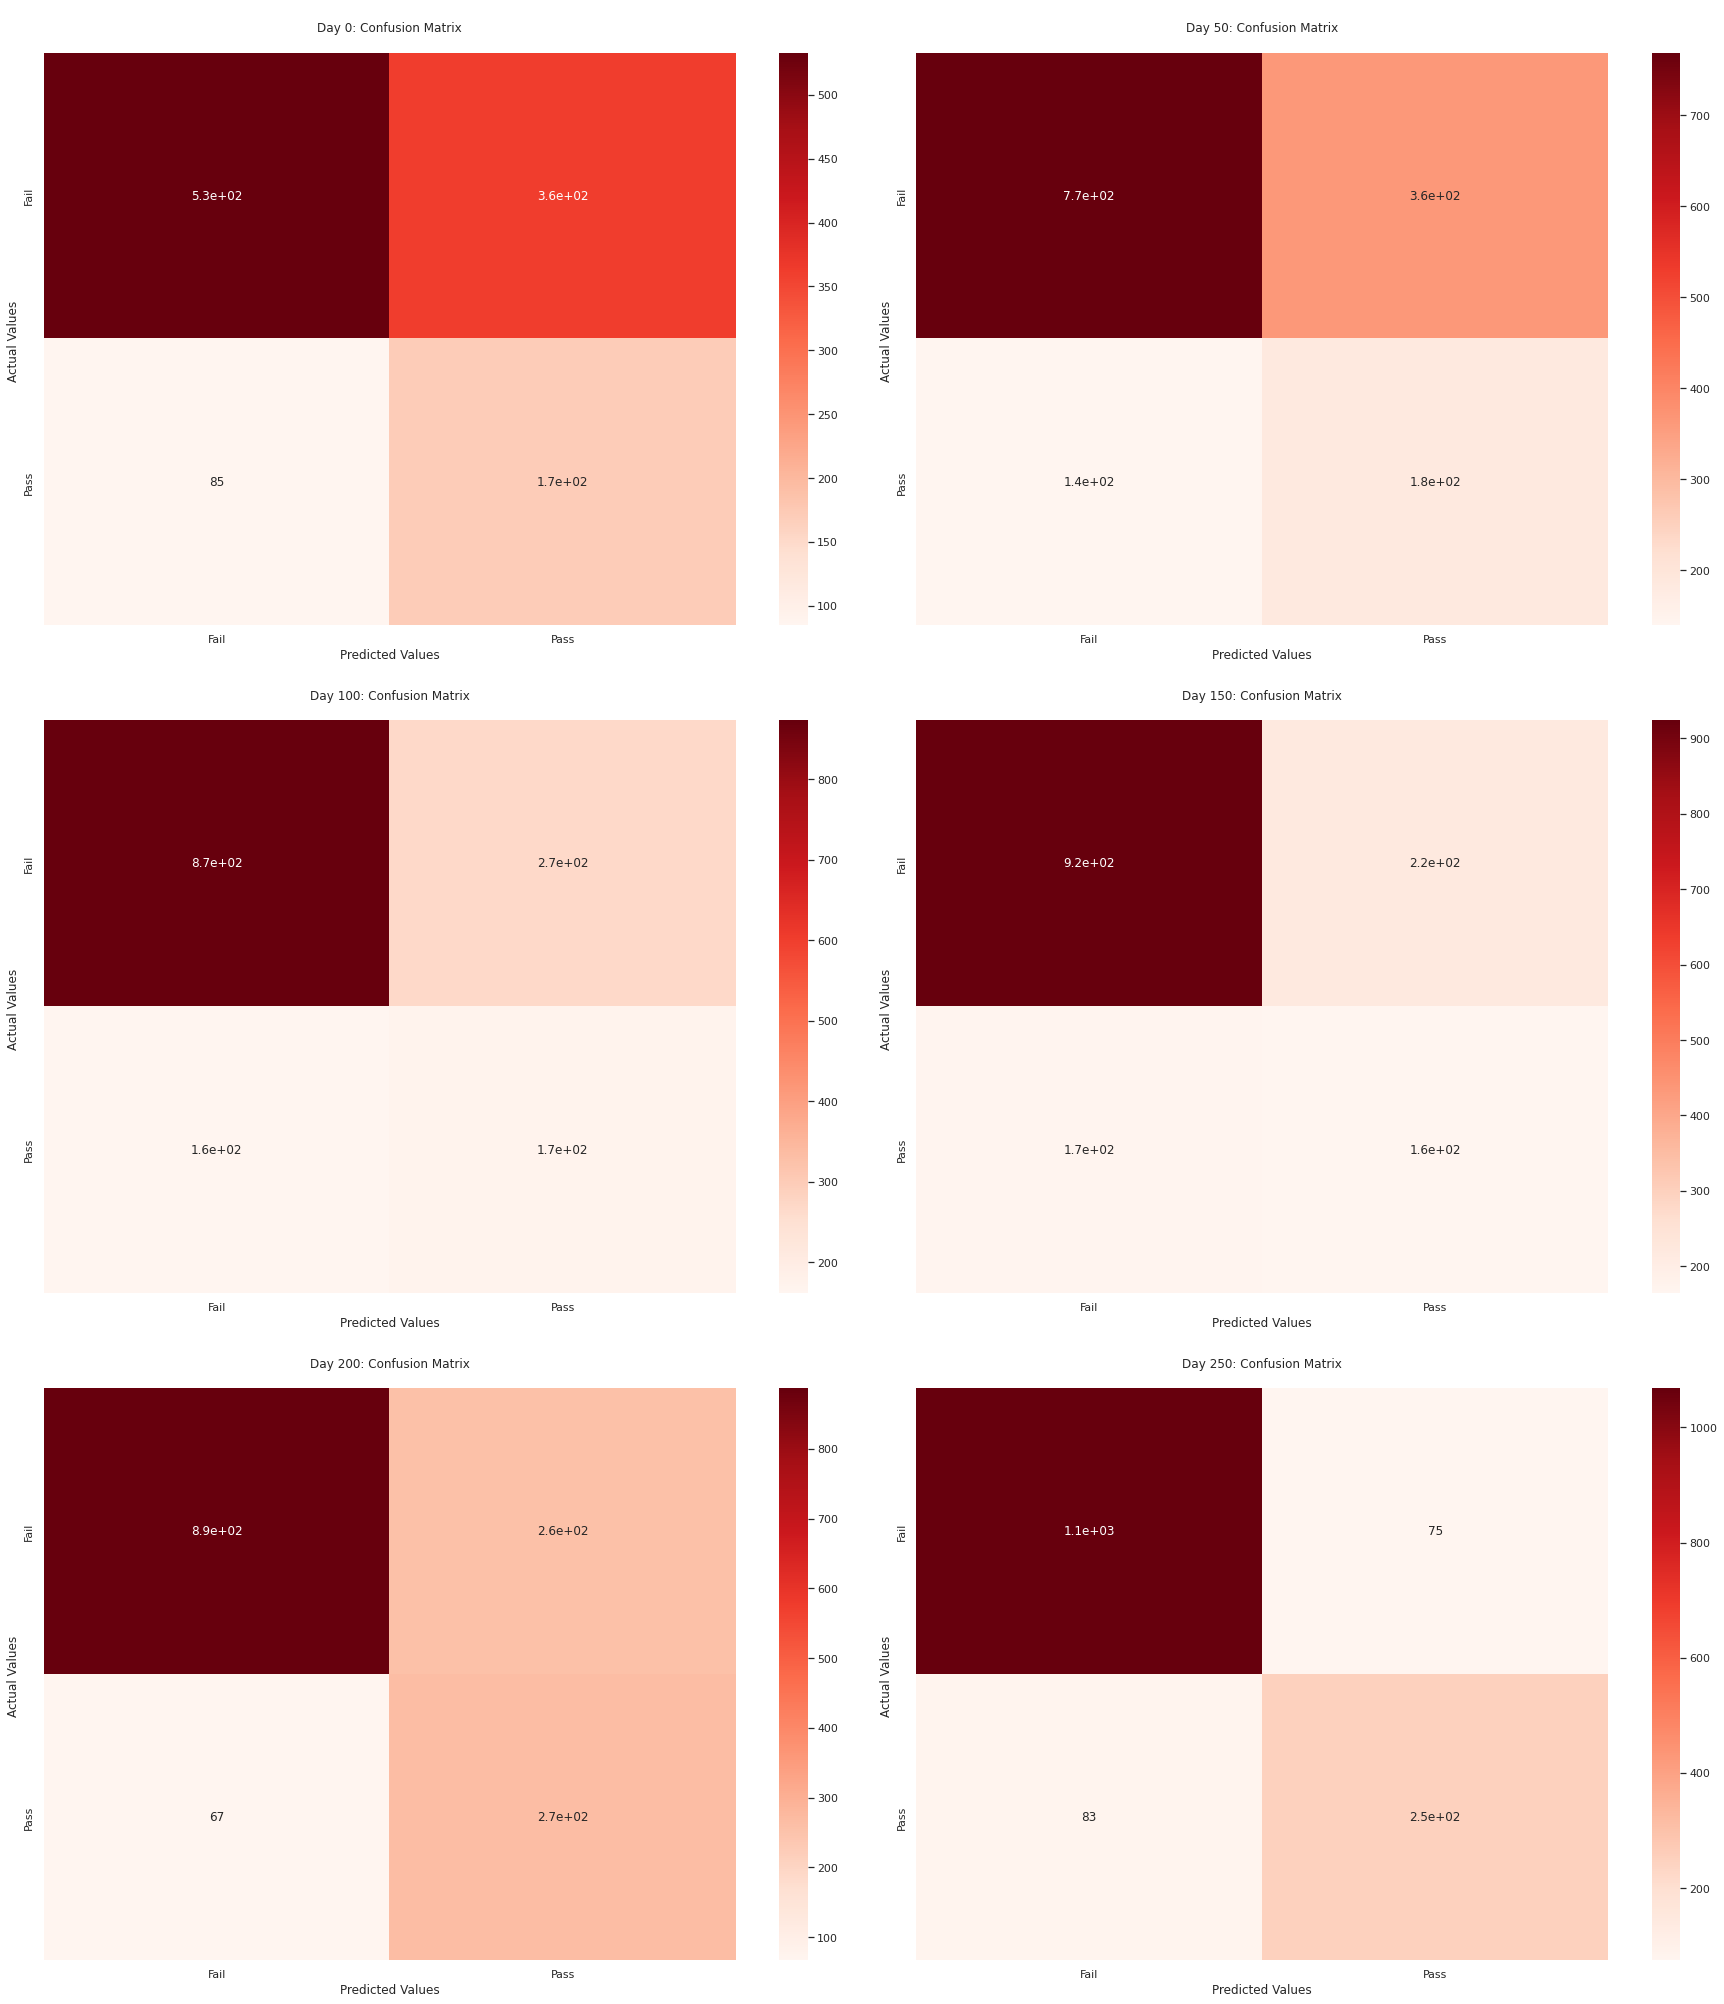

In [ ]:
plot_confusion_matrix(all_results_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

all_results_rf = []
all_results_predict_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_rf.append([acc, f1, prec, recall, conf])
  all_results_predict_rf.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.555
Best parameters set:
	clf__n_estimators: 120
Accuracy: 0.7549956559513467, F1 Score: 0.2122905027932961, Precision: 0.37254901960784315, Recall: 0.1484375


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.551
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.766803840877915, F1 Score: 0.25764192139737985, Precision: 0.44360902255639095, Recall: 0.18153846153846154


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.601
Best parameters set:
	clf__n_estimators: 130

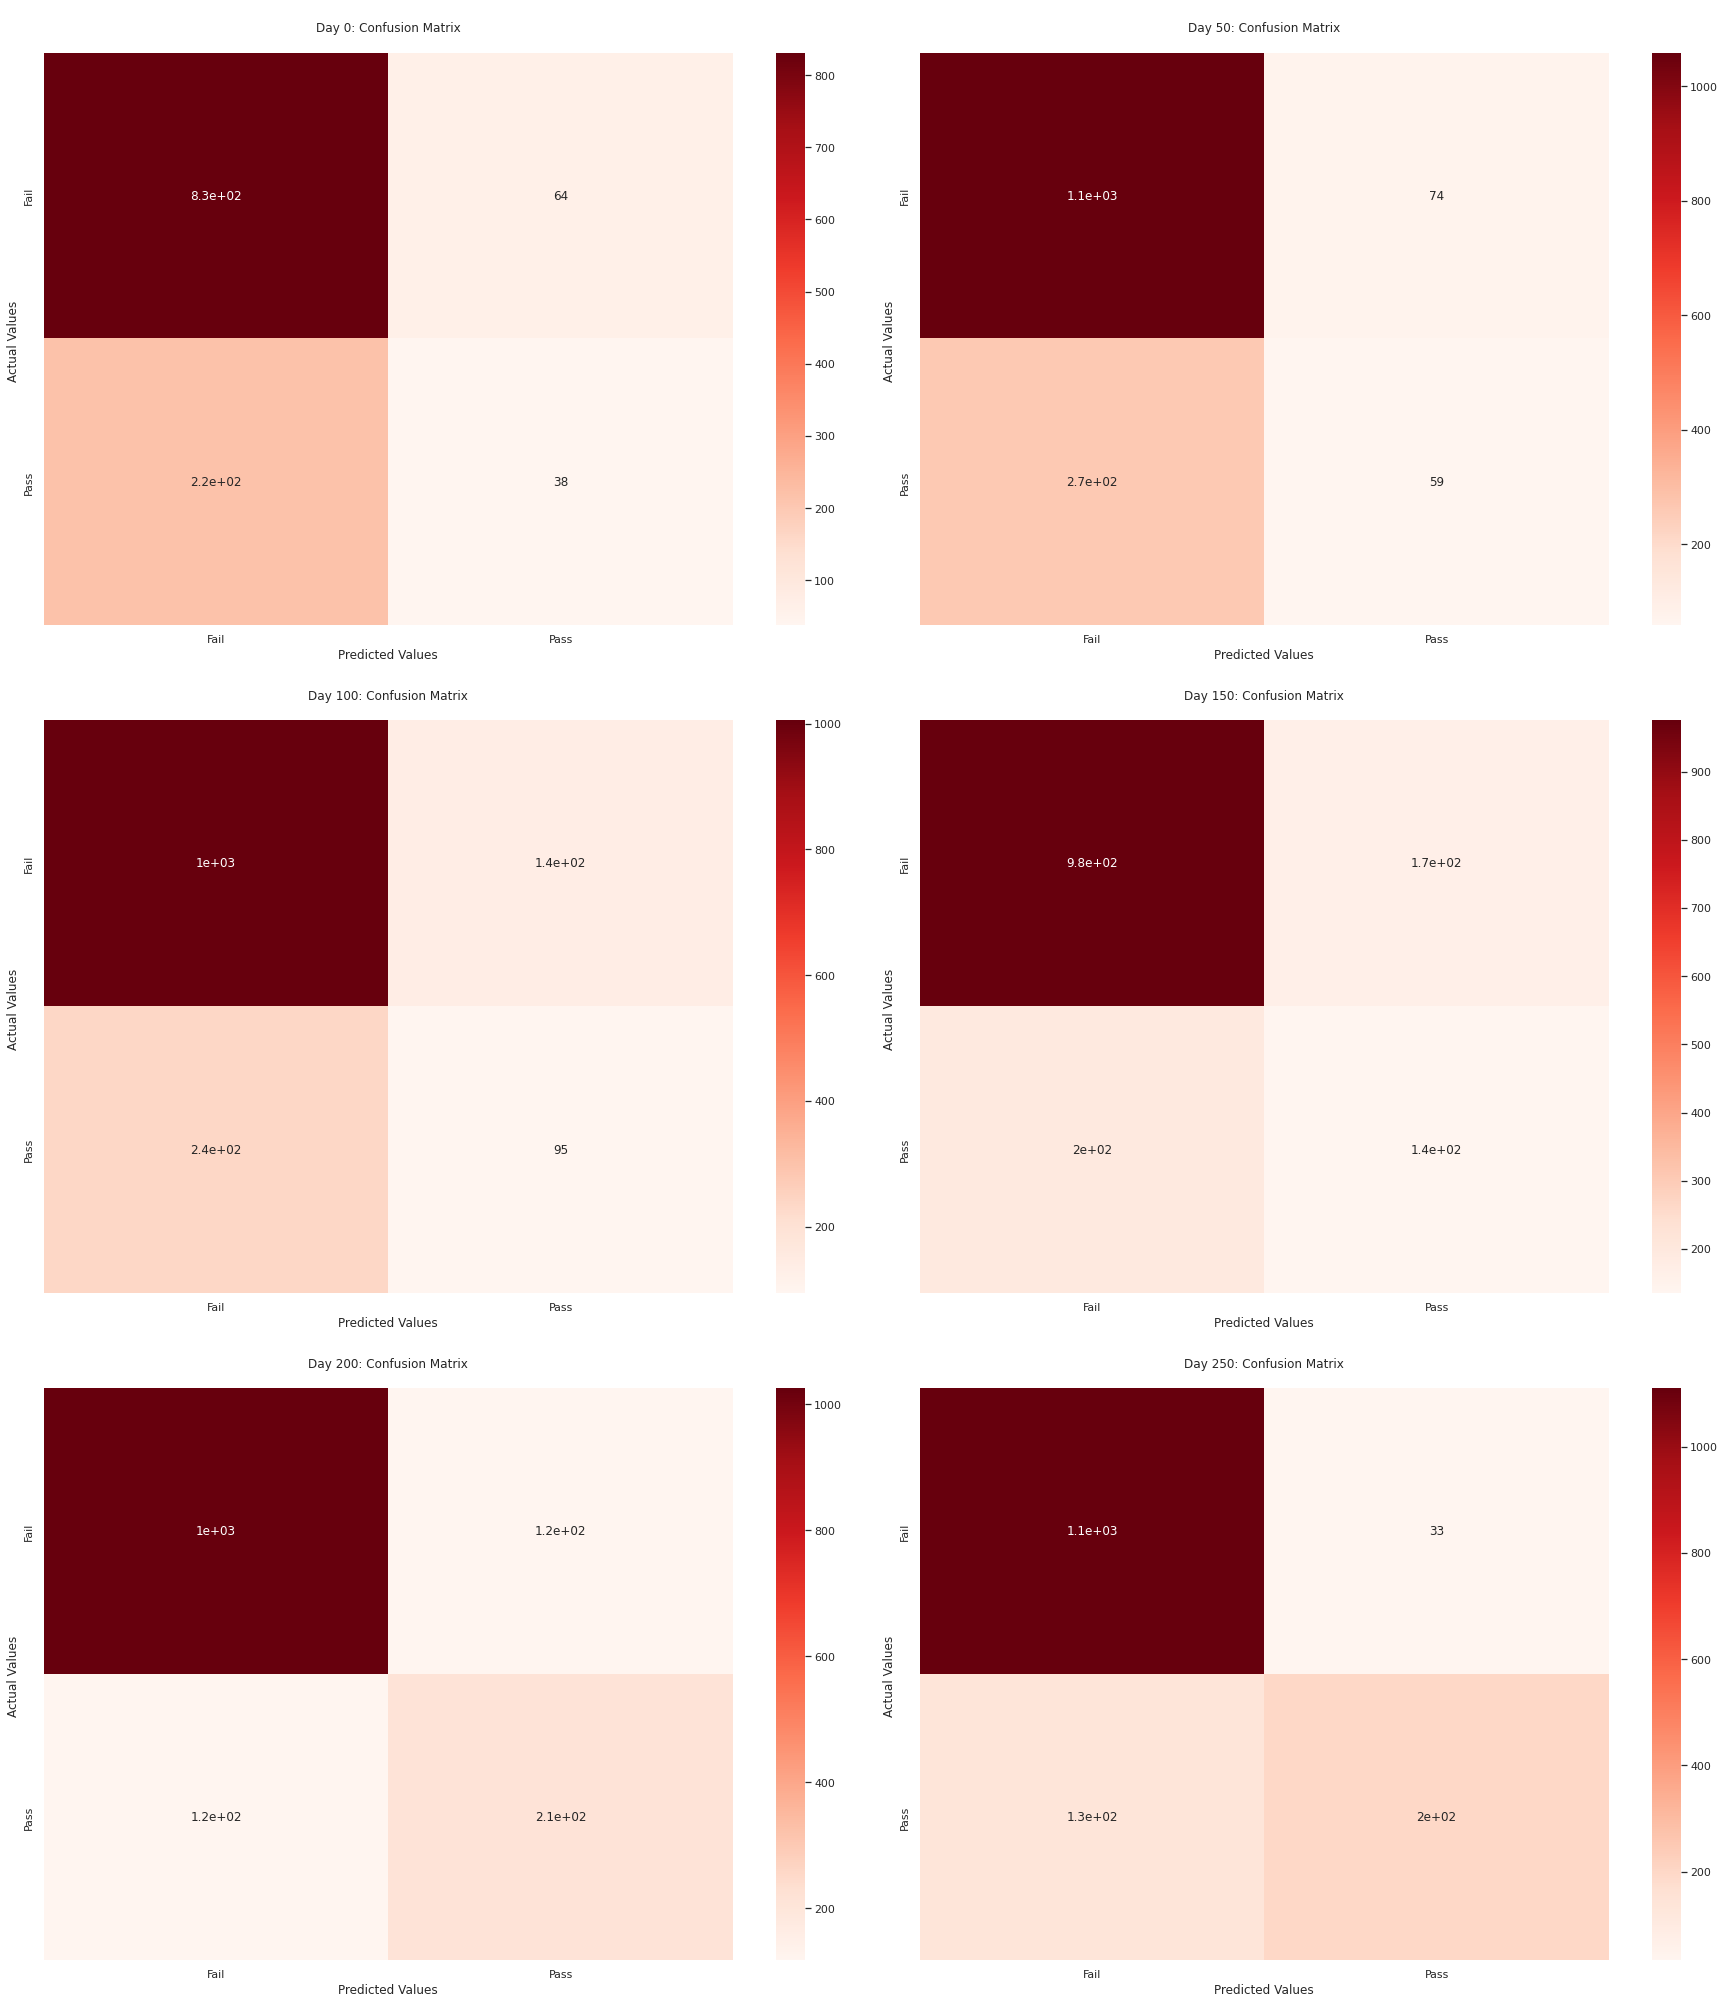

In [ ]:
plot_confusion_matrix(all_results_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

all_results_ab = []
all_results_predict_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_ab.append([acc, f1, prec, recall, conf])
  all_results_predict_ab.append(predictions)
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.592
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.6976542137271937, F1 Score: 0.24675324675324675, Precision: 0.2766990291262136, Recall: 0.22265625


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.613
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.6920438957475995, F1 Score: 0.37725381414701803, Precision: 0.3434343434343434, Recall: 0.41846153846153844


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.642
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7222222222222222, F1 Sco

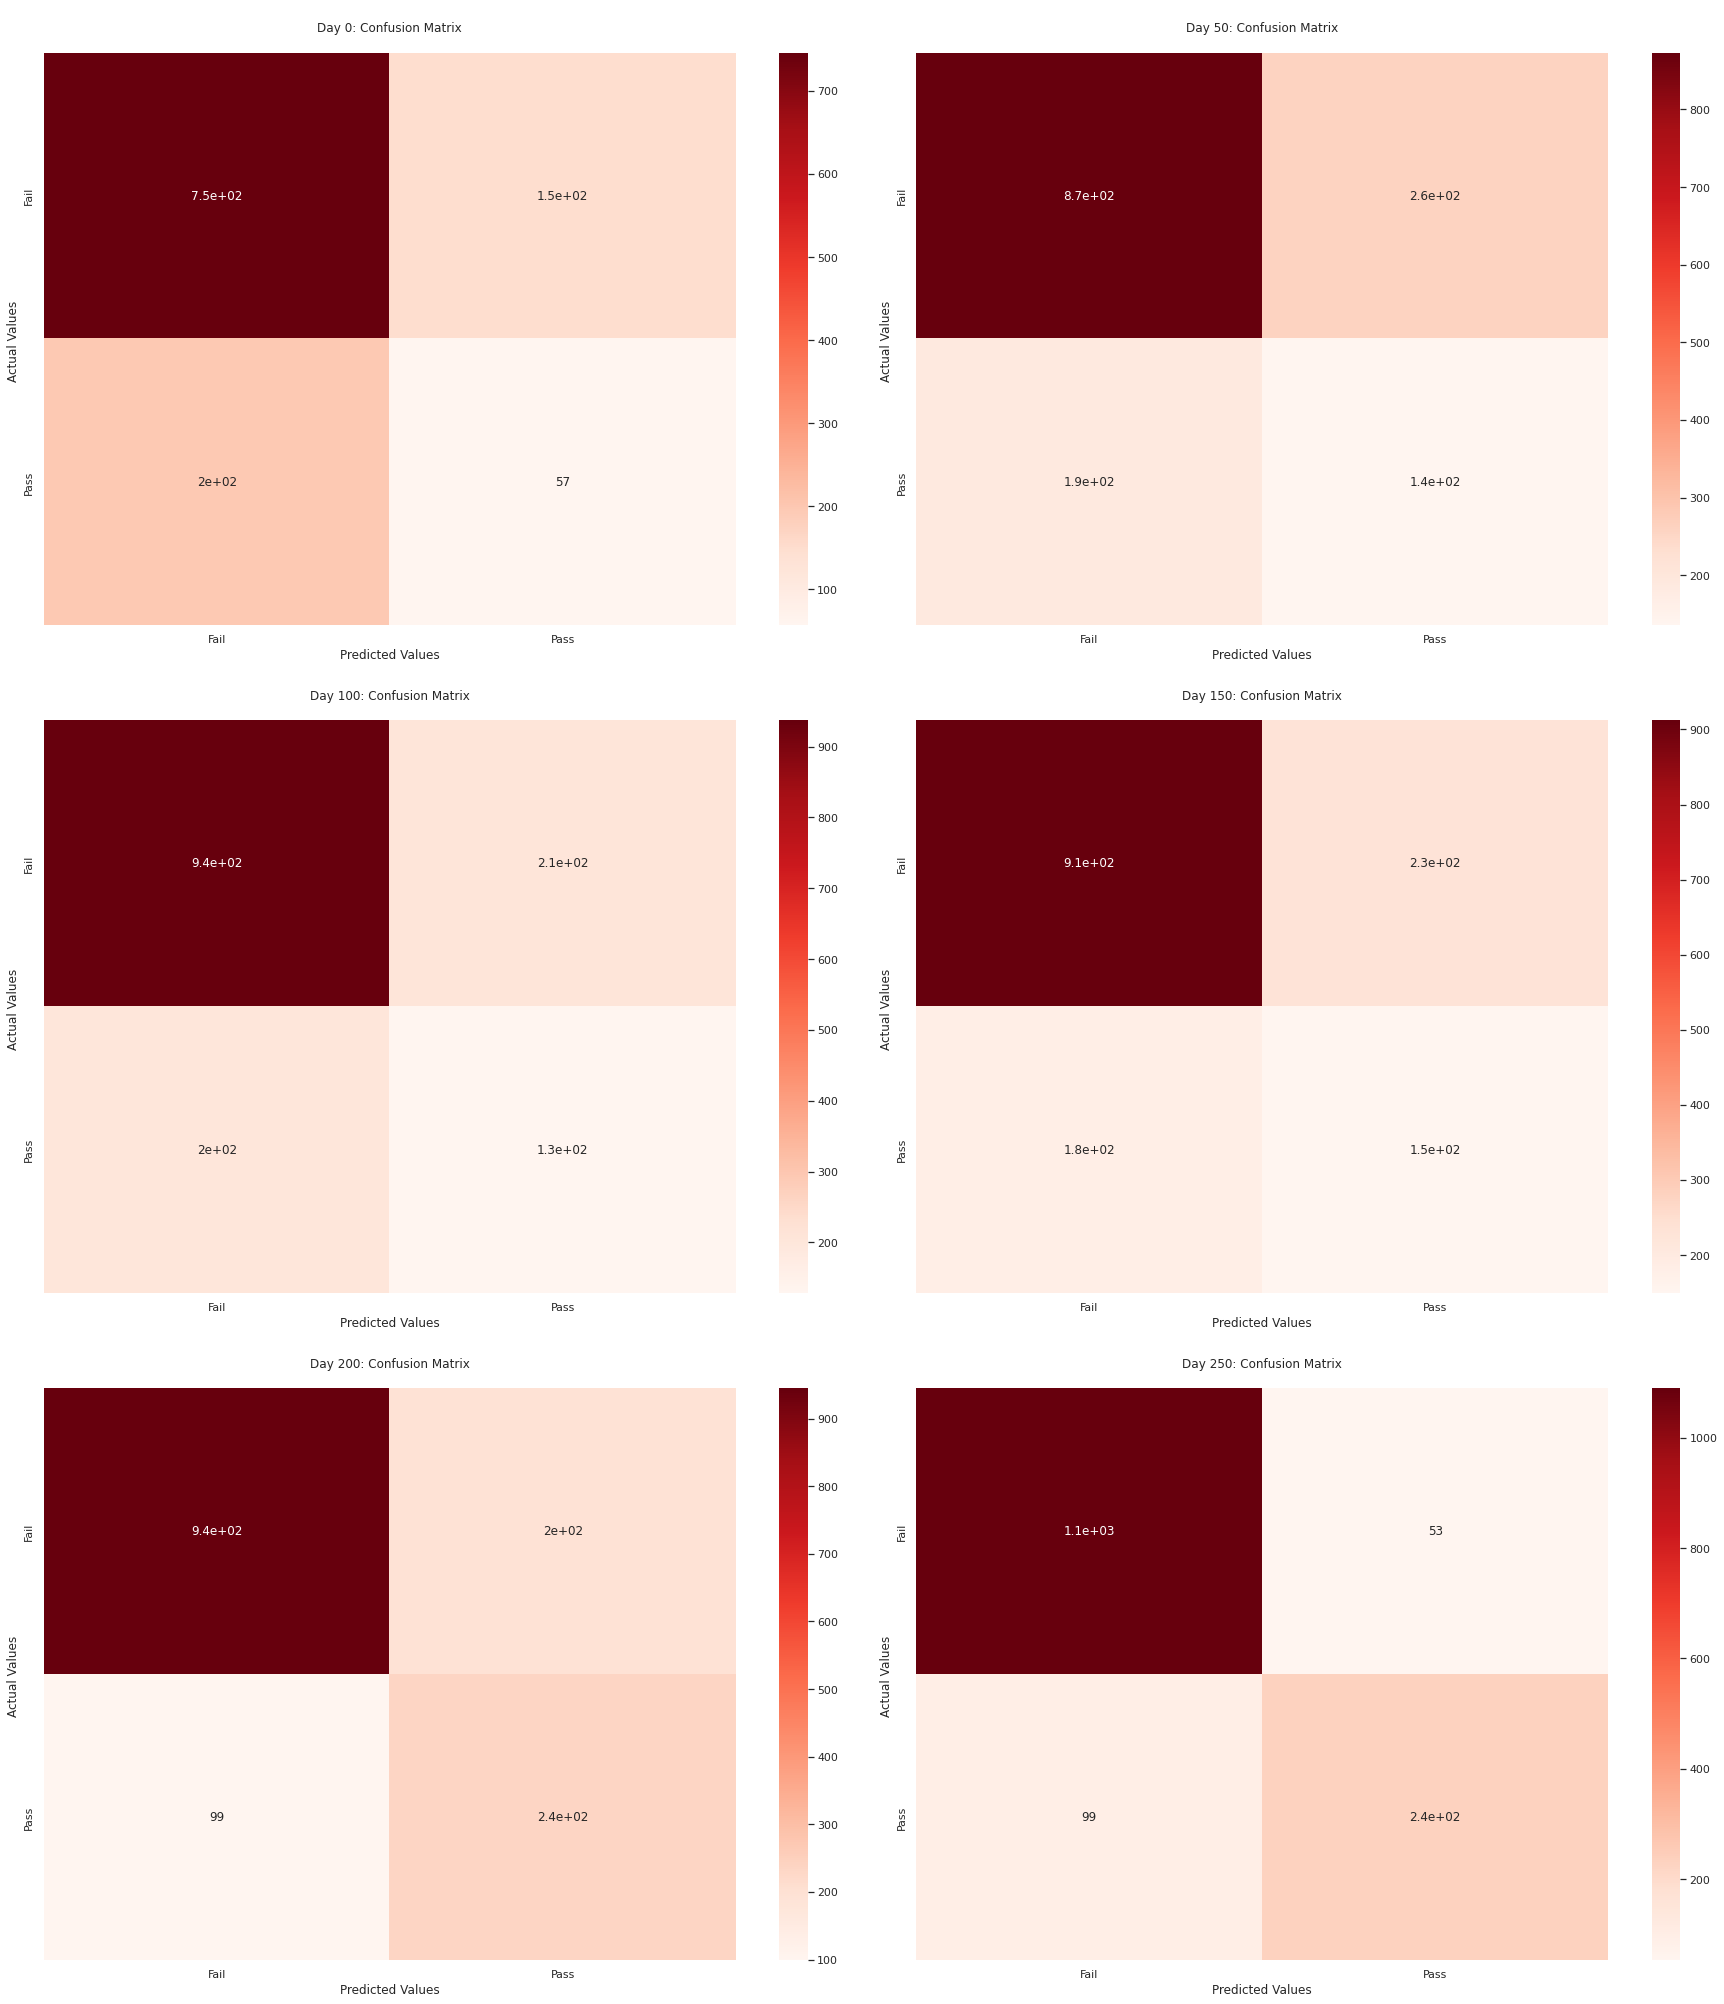

In [ ]:
plot_confusion_matrix(all_results_ab)

##### Plot results overview

In [ ]:
all_classifier_results = [all_results_du, all_results_nb, all_results_lr, all_results_lrw, all_results_rf, all_results_ab]
all_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

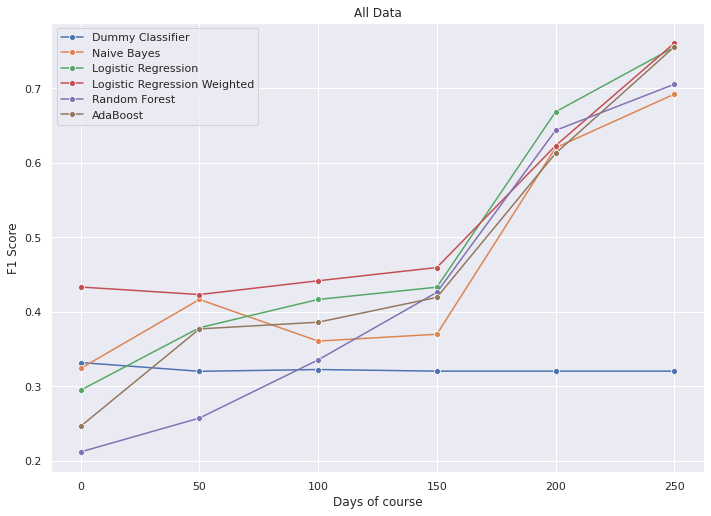

In [ ]:
plot_days_compare(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

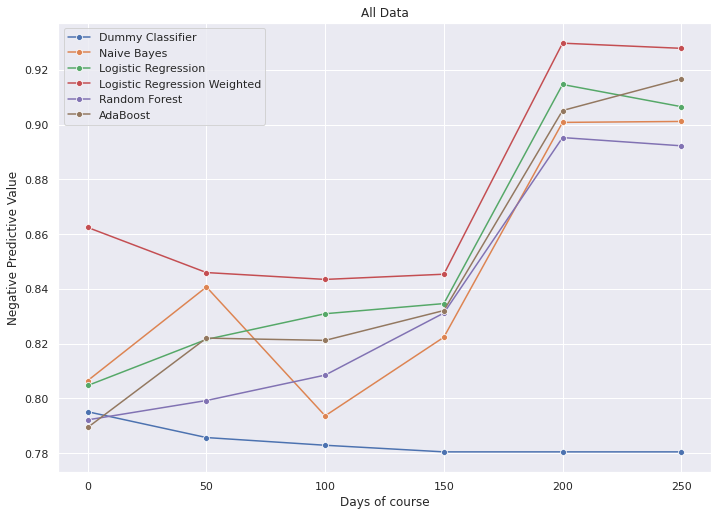

In [ ]:
plot_days_compare_npv(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

#### Three classifiers

In [ ]:
confusion_matrix_combine_three = []
keys= list(df)

for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine_three.append(np.zeros([2,2]))

  for j in range(len(all_results_predict_lr[i])):
    sum_predict = all_results_predict_lr[i][j] + all_results_predict_rf[i][j] + all_results_predict_ab[i][j]
    if sum_predict <= 1:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine_three[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,1] += 1
    else:
      confusion_matrix_combine_three[i][1,1] += 1


0
1
2
3
4
5


In [ ]:
for i in range(len(confusion_matrix_combine_three)):
  print(confusion_matrix_combine_three[i])

[[824.  71.]
 [211.  45.]]
[[994. 139.]
 [230.  95.]]
[[953. 190.]
 [207. 126.]]
[[946. 197.]
 [190. 144.]]
[[1004.  139.]
 [ 104.  230.]]
[[1113.   30.]
 [ 117.  217.]]


824.0 71.0 211.0 45.0
994.0 139.0 230.0 95.0
953.0 190.0 207.0 126.0
946.0 197.0 190.0 144.0
1004.0 139.0 104.0 230.0
1113.0 30.0 117.0 217.0


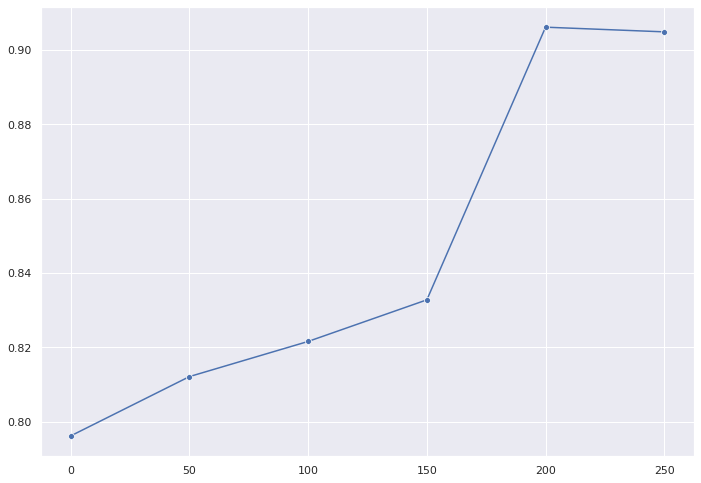

In [ ]:
npv = []
for i in confusion_matrix_combine_three:
  tn, fp, fn, tp = i.ravel()

  print(tn,fp,fn,tp)

  # Prevent zero division error
  if fn == 0:
    npv.append(0)
  else:
    npv.append(tn/(tn+fn))

plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o")

#### Combine Classifier Results

In [ ]:
confusion_matrix_combine = []
performance_weight = [0,0,0,0.0,0.5,0.5]
keys= list(df)


for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine.append(np.zeros([2,2]))
  for j in range(len(all_results_predict_proba_lr[i])):
    all_result = all_results_predict_proba_lr[i][j] * (1-performance_weight[i])

    if performance_weight[i] != 0:
      performance_result = performance_predict_proba_nb[i-1][j] * (performance_weight[i])
    else:
      performance_result = 0
    
    final_result = all_result + performance_result
    
    if final_result[0]>0.55:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine[i][0,1] += 1
    else:
      confusion_matrix_combine[i][1,1] += 1


0
1
2
3
4
5


In [ ]:
for i in range(len(confusion_matrix_combine)):
  print(confusion_matrix_combine[i])

[[769. 126.]
 [178.  78.]]
[[913. 220.]
 [189. 136.]]
[[907. 236.]
 [183. 150.]]
[[939. 204.]
 [186. 148.]]
[[951. 192.]
 [ 81. 253.]]
[[1105.   38.]
 [ 101.  233.]]
